## Importing necessary libraries and dependencies

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import shap
import xgboost

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

seed = 77

In [4]:
data = pd.read_csv('CAD.csv')
data.head()

Age  Weight  Length    Sex        BMI  DM  HTN  Current Smoker  EX-Smoker  \
0   53      90     175   Male  29.387755   0    1               1          0   
1   67      70     157  Fmale  28.398718   0    1               0          0   
2   54      54     164   Male  20.077335   0    0               1          0   
3   66      67     158  Fmale  26.838648   0    1               0          0   
4   50      87     153  Fmale  37.165193   0    1               0          0   

   FH  ...    K   Na    WBC Lymph Neut  PLT EF-TTE  Region RWMA     VHD  \
0   0  ...  4.7  141   5700    39   52  261     50            0       N   
1   0  ...  4.7  156   7700    38   55  165     40            4       N   
2   0  ...  4.7  139   7400    38   60  230     40            2    mild   
3   0  ...  4.4  142  13000    18   72  742     55            0  Severe   
4   0  ...  4.0  140   9200    55   39  274     50            0  Severe   

     Cath  
0     Cad  
1     Cad  
2     Cad  
3  Normal  
4  Normal  

[5 rows x 55 columns]

## Check Missing Value

In [6]:
data.isnull().sum().sort_values(ascending=False)


Age                      0
HDL                      0
LowTH Ang                0
Q Wave                   0
St Elevation             0
St Depression            0
Tinversion               0
LVH                      0
Poor R Progression       0
FBS                      0
CR                       0
TG                       0
LDL                      0
BUN                      0
Nonanginal               0
ESR                      0
HB                       0
K                        0
Na                       0
WBC                      0
Lymph                    0
Neut                     0
PLT                      0
EF-TTE                   0
Region RWMA              0
VHD                      0
Exertional CP            0
Atypical                 0
Weight                   0
Airway disease           0
Length                   0
Sex                      0
BMI                      0
DM                       0
HTN                      0
Current Smoker           0
EX-Smoker                0
FH                       0
Obesity                  0
CRF                      0
CVA                      0
Thyroid Disease          0
Function Class           0
CHF                      0
DLP                      0
BP                       0
PR                       0
Edema                    0
Weak Peripheral Pulse    0
Lung rales               0
Systolic Murmur          0
Diastolic Murmur         0
Typical Chest Pain       0
Dyspnea                  0
Cath                     0
dtype: int64

No missing values in the data

## Checking for Duplicates

In [7]:
data.duplicated().sum()

0

No Duplicate rows found

## Check Unique Values

In [10]:
# Numerical variables:
num_cols = ['Age','Weight', 'Length','BMI', 'BP', 'PR', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE']

# Categorical variables:
cat_cols = ['Sex', 'DM', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Edema', 'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur', 'Diastolic Murmur', 'Typical Chest Pain', 'Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'Q Wave', 'St Elevation', 'St Depression', 'Tinversion', 'LVH', 'Poor R Progression', 'Cath']

# Ordinal variables
ord_cols = ['Function Class', "Region RWMA", "VHD"]

print(f"[Unique Values in {len(cat_cols)} Categorical Variables]\n")

for cat_col in cat_cols:
    print("* {} : {} Unique Values =>".format(cat_col, data[cat_col].nunique()), data[cat_col].unique())

[Unique Values in 31 Categorical Variables]

* Sex : 2 Unique Values => ['Male' 'Fmale']
* DM : 2 Unique Values => [0 1]
* HTN : 2 Unique Values => [1 0]
* Current Smoker : 2 Unique Values => [1 0]
* EX-Smoker : 2 Unique Values => [0 1]
* FH : 2 Unique Values => [0 1]
* Obesity : 2 Unique Values => ['Y' 'N']
* CRF : 2 Unique Values => ['N' 'Y']
* CVA : 2 Unique Values => ['N' 'Y']
* Airway disease : 2 Unique Values => ['N' 'Y']
* Thyroid Disease : 2 Unique Values => ['N' 'Y']
* CHF : 2 Unique Values => ['N' 'Y']
* DLP : 2 Unique Values => ['Y' 'N']
* Edema : 2 Unique Values => [0 1]
* Weak Peripheral Pulse : 2 Unique Values => ['N' 'Y']
* Lung rales : 2 Unique Values => ['N' 'Y']
* Systolic Murmur : 2 Unique Values => ['N' 'Y']
* Diastolic Murmur : 2 Unique Values => ['N' 'Y']
* Typical Chest Pain : 2 Unique Values => [0 1]
* Dyspnea : 2 Unique Values => ['N' 'Y']
* Atypical : 2 Unique Values => ['N' 'Y']
* Nonanginal : 2 Unique Values => ['N' 'Y']
* Exertional CP : 1 Unique Values => 

In [11]:
print(f"[Unique Values in {len(ord_cols)} Ordinal Variables]\n")

for ord_col in ord_cols:
    print("* {} : {} Unique Values =>".format(ord_col, data[ord_col].nunique()), data[ord_col].unique())

[Unique Values in 3 Ordinal Variables]

* Function Class : 4 Unique Values => [0 3 2 1]
* Region RWMA : 5 Unique Values => [0 4 2 3 1]
* VHD : 4 Unique Values => ['N' 'mild' 'Severe' 'Moderate']


In [12]:
print(f"[Unique Values in {len(num_cols)} Numerical Variables]\n")

for num_col in num_cols:
    print("* {} : {} Unique Values".format(num_col, data[num_col].nunique()))

[Unique Values in 21 Numerical Variables]

* Age : 46 Unique Values
* Weight : 54 Unique Values
* Length : 44 Unique Values
* BMI : 262 Unique Values
* BP : 17 Unique Values
* PR : 21 Unique Values
* FBS : 113 Unique Values
* CR : 18 Unique Values
* TG : 147 Unique Values
* LDL : 110 Unique Values
* HDL : 47 Unique Values
* BUN : 33 Unique Values
* ESR : 58 Unique Values
* HB : 66 Unique Values
* K : 27 Unique Values
* Na : 25 Unique Values
* WBC : 78 Unique Values
* Lymph : 50 Unique Values
* Neut : 52 Unique Values
* PLT : 135 Unique Values
* EF-TTE : 11 Unique Values


## Data Shape

In [13]:
print(f"Dataset : {data.shape[0]} rows X {data.shape[1]} columns")

Dataset : 303 rows X 55 columns


## Data Statistics

In [14]:
data[num_cols[:10]].describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95])

Age      Weight      Length         BMI          BP          PR  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    58.897690   73.831683  164.716172   27.248339  129.554455   75.141914   
std     10.392278   11.987358    9.327661    4.098865   18.938105    8.911801   
min     30.000000   48.000000  140.000000   18.115413   90.000000   50.000000   
10%     47.000000   60.000000  152.000000   22.338318  110.000000   70.000000   
25%     51.000000   65.000000  158.000000   24.514380  120.000000   70.000000   
50%     58.000000   74.000000  165.000000   26.775510  130.000000   70.000000   
75%     66.000000   81.000000  171.000000   29.411765  140.000000   80.000000   
90%     73.000000   89.000000  176.000000   33.105234  160.000000   85.800000   
95%     76.000000   93.900000  179.000000   34.805948  160.000000   90.000000   
max     86.000000  120.000000  188.000000   40.900658  190.000000  110.000000   

              FBS          CR           TG         LDL  
count  303.000000  303.000000   303.000000  303.000000  
mean   119.184818    1.055611   150.343234  104.643564  
std     52.079653    0.264296    97.959451   35.396688  
min     62.000000    0.500000    37.000000   18.000000  
10%     80.000000    0.800000    76.000000   65.200000  
25%     88.500000    0.900000    90.000000   80.000000  
50%     98.000000    1.000000   122.000000  100.000000  
75%    130.000000    1.200000   177.000000  122.000000  
90%    191.800000    1.400000   250.000000  152.800000  
95%    218.900000    1.500000   308.600000  169.800000  
max    400.000000    2.200000  1050.000000  232.000000

In [15]:
data[num_cols[10:]].describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95])

HDL         BUN         ESR          HB           K          Na  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    40.233993   17.501650   19.462046   13.153465    4.230693  140.996700   
std     10.559077    6.956761   15.936475    1.610452    0.458202    3.807885   
min     15.900000    6.000000    1.000000    8.900000    3.000000  128.000000   
10%     28.000000   11.000000    4.000000   11.000000    3.700000  137.000000   
25%     33.500000   13.000000    9.000000   12.200000    3.900000  139.000000   
50%     39.000000   16.000000   15.000000   13.200000    4.200000  141.000000   
75%     45.500000   20.000000   26.000000   14.200000    4.500000  143.000000   
90%     52.800000   25.000000   41.000000   15.080000    4.800000  145.000000   
95%     55.000000   31.000000   51.000000   15.600000    4.990000  146.900000   
max    111.000000   52.000000   90.000000   17.600000    6.600000  156.000000   

                WBC       Lymph        Neut         PLT      EF-TTE  
count    303.000000  303.000000  303.000000  303.000000  303.000000  
mean    7562.046205   32.399340   60.148515  221.488449   47.231023  
std     2413.739323    9.972592   10.182493   60.796199    8.927194  
min     3700.000000    7.000000   32.000000   25.000000   15.000000  
10%     5100.000000   19.000000   49.000000  170.000000   35.000000  
25%     5800.000000   26.000000   52.500000  183.500000   45.000000  
50%     7100.000000   32.000000   60.000000  210.000000   50.000000  
75%     8800.000000   39.000000   67.000000  250.000000   55.000000  
90%    10400.000000   44.000000   72.800000  292.800000   55.000000  
95%    12100.000000   49.000000   78.000000  330.000000   55.000000  
max    18000.000000   60.000000   89.000000  742.000000   60.000000

Distribution of continuous features are not uniform, and has a certain skewness. Especially, feature `TG` (max value = 1050), `FBS` (max value = 400), and `HDL` (max value = 111) and other features has some outliers. We will check outliers by plotting `boxplot` in the next part.

## Mapping some of the column values

In [16]:
vhd = {"N": 0, "mild": 1, "Moderate": 2, "Severe": 3}
sex = {"Male": "Male", "Fmale": "Female"}

data['VHD'] = data['VHD'].map(vhd)
data['Sex'] = data['Sex'].map(sex)

data.replace('N', 0, inplace=True)
data.replace('Y', 1, inplace=True)

For feature `VHD` (Valvular heart disease), let's change `N` (=Normal) to `0`, `mild` to `1`, `Moderate` to `2`, and `Severe` to `3`. And for consistency, Let's change `N` to `0`, and `Y` to `1`. After mapping some of the values, let's check uniqueness again to identify if there are any errors.

In [17]:
print(f"[Unique Values in {len(cat_cols)} Categorical Variables]\n")

for cat_col in cat_cols:
    print("* {} : {} Unique Values =>".format(cat_col, data[cat_col].nunique()), data[cat_col].unique())

[Unique Values in 31 Categorical Variables]

* Sex : 2 Unique Values => ['Male' 'Female']
* DM : 2 Unique Values => [0 1]
* HTN : 2 Unique Values => [1 0]
* Current Smoker : 2 Unique Values => [1 0]
* EX-Smoker : 2 Unique Values => [0 1]
* FH : 2 Unique Values => [0 1]
* Obesity : 2 Unique Values => [1 0]
* CRF : 2 Unique Values => [0 1]
* CVA : 2 Unique Values => [0 1]
* Airway disease : 2 Unique Values => [0 1]
* Thyroid Disease : 2 Unique Values => [0 1]
* CHF : 2 Unique Values => [0 1]
* DLP : 2 Unique Values => [1 0]
* Edema : 2 Unique Values => [0 1]
* Weak Peripheral Pulse : 2 Unique Values => [0 1]
* Lung rales : 2 Unique Values => [0 1]
* Systolic Murmur : 2 Unique Values => [0 1]
* Diastolic Murmur : 2 Unique Values => [0 1]
* Typical Chest Pain : 2 Unique Values => [0 1]
* Dyspnea : 2 Unique Values => [0 1]
* Atypical : 2 Unique Values => [0 1]
* Nonanginal : 2 Unique Values => [0 1]
* Exertional CP : 1 Unique Values => [0]
* LowTH Ang : 2 Unique Values => [0 1]
* Q Wave : 2

In [18]:
print(f"[Unique Values in {len(ord_cols)} Ordinal Variables]\n")

for ord_col in ord_cols:
    print("* {} : {} Unique Values =>".format(ord_col, data[ord_col].nunique()), data[ord_col].unique())

[Unique Values in 3 Ordinal Variables]

* Function Class : 4 Unique Values => [0 3 2 1]
* Region RWMA : 5 Unique Values => [0 4 2 3 1]
* VHD : 4 Unique Values => [0 1 3 2]


Mapping was successful and data preparation is done. There are no missing values or duplicated rows.

# 2.2 - Univariate Analysis

## Categorical Variables

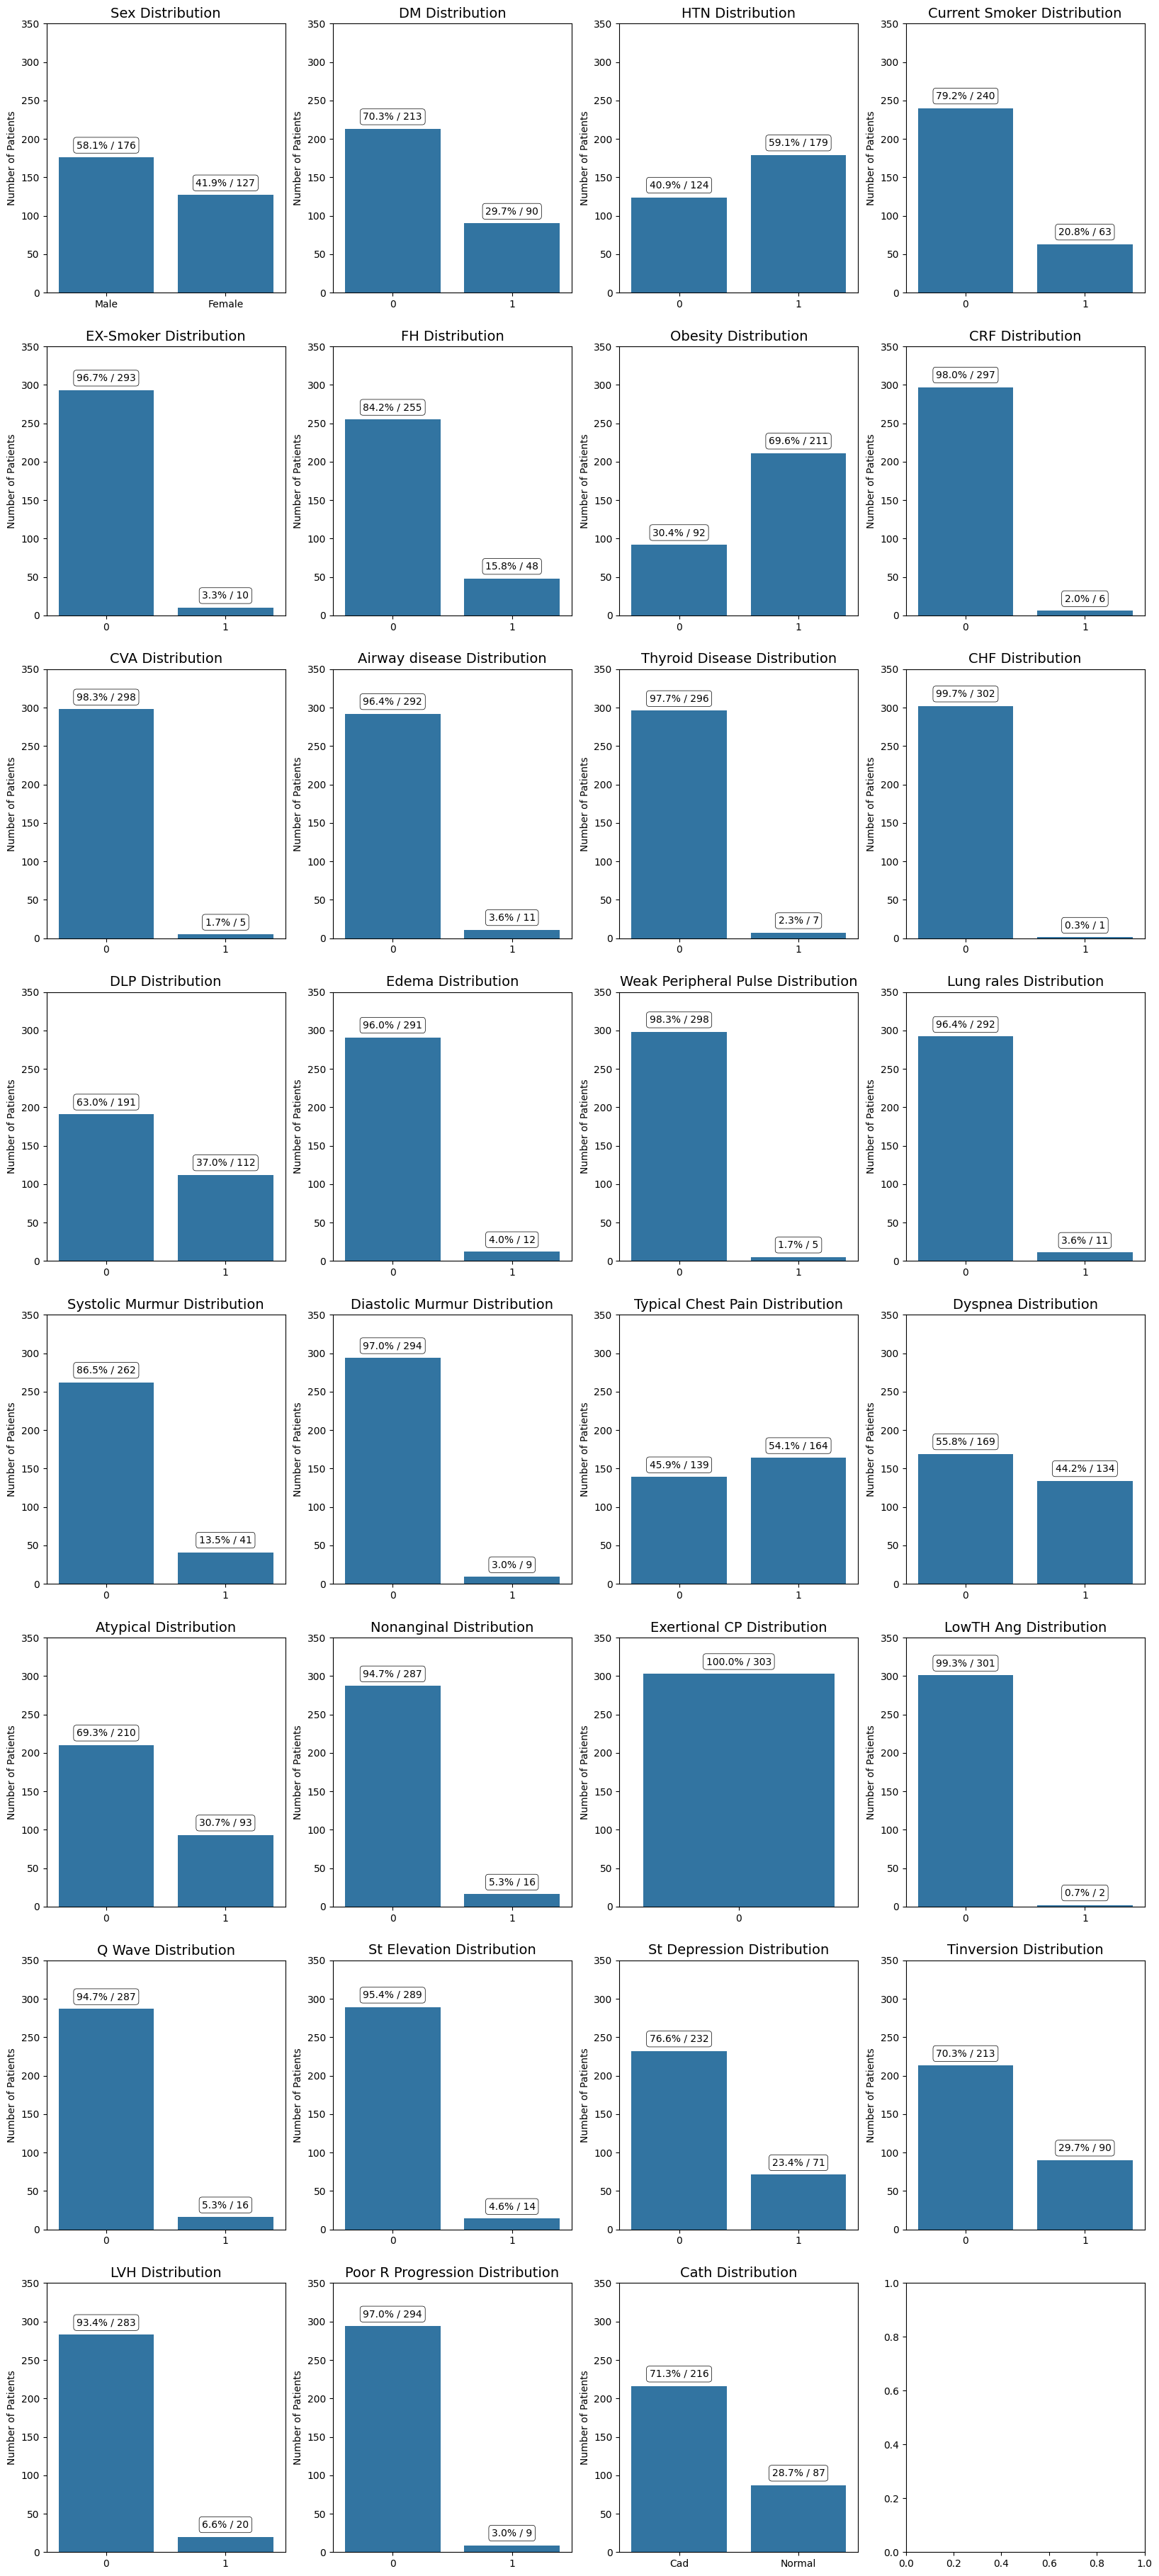

In [19]:
n_rows, n_cols = 8, 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,30))

for i, cat_col in enumerate(cat_cols):
    i, j = i//n_cols, i%n_cols
    rects = sns.countplot(x=cat_col, data=data, ax=ax[i,j])

    for rect in rects.patches:
        height = rect.get_height()
        ax[i,j].text(rect.get_x()+rect.get_width()/2., height+12, "{:1.1f}% / {:d}".format(height/len(data)*100, height.astype(int)), ha='center', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    ax[i,j].set_title(f'{cat_col} Distribution', fontsize=14)
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("Number of Patients")
    ax[i,j].set_ylim([0, 350])

fig.subplots_adjust(top=1.3)
fig.show()

From above graph, it can be seen that the dataset has the following characteristics:
- `Exertional CP` feature does not contribute to the classification prediction of CAD. (`0` - 100%). Therefore this feature will be deleted automatically in encoding process by `OneHotEncoder` (by setting `drop_first = True`).
- The dataset has **severe class imbalance problem**. And likewise, the target variable `Cath` (`Cad` - 71.3%, `Normal` - 28.7%) is also imbalenced. This dataset is not about healthy people. As we saw in the dataset description part, this dataset derived from 303 cases who **visited hospital in Iran because of chest pain**. That's why `Cad` accounts for 71.3% of the data.


## Ordinal Variables

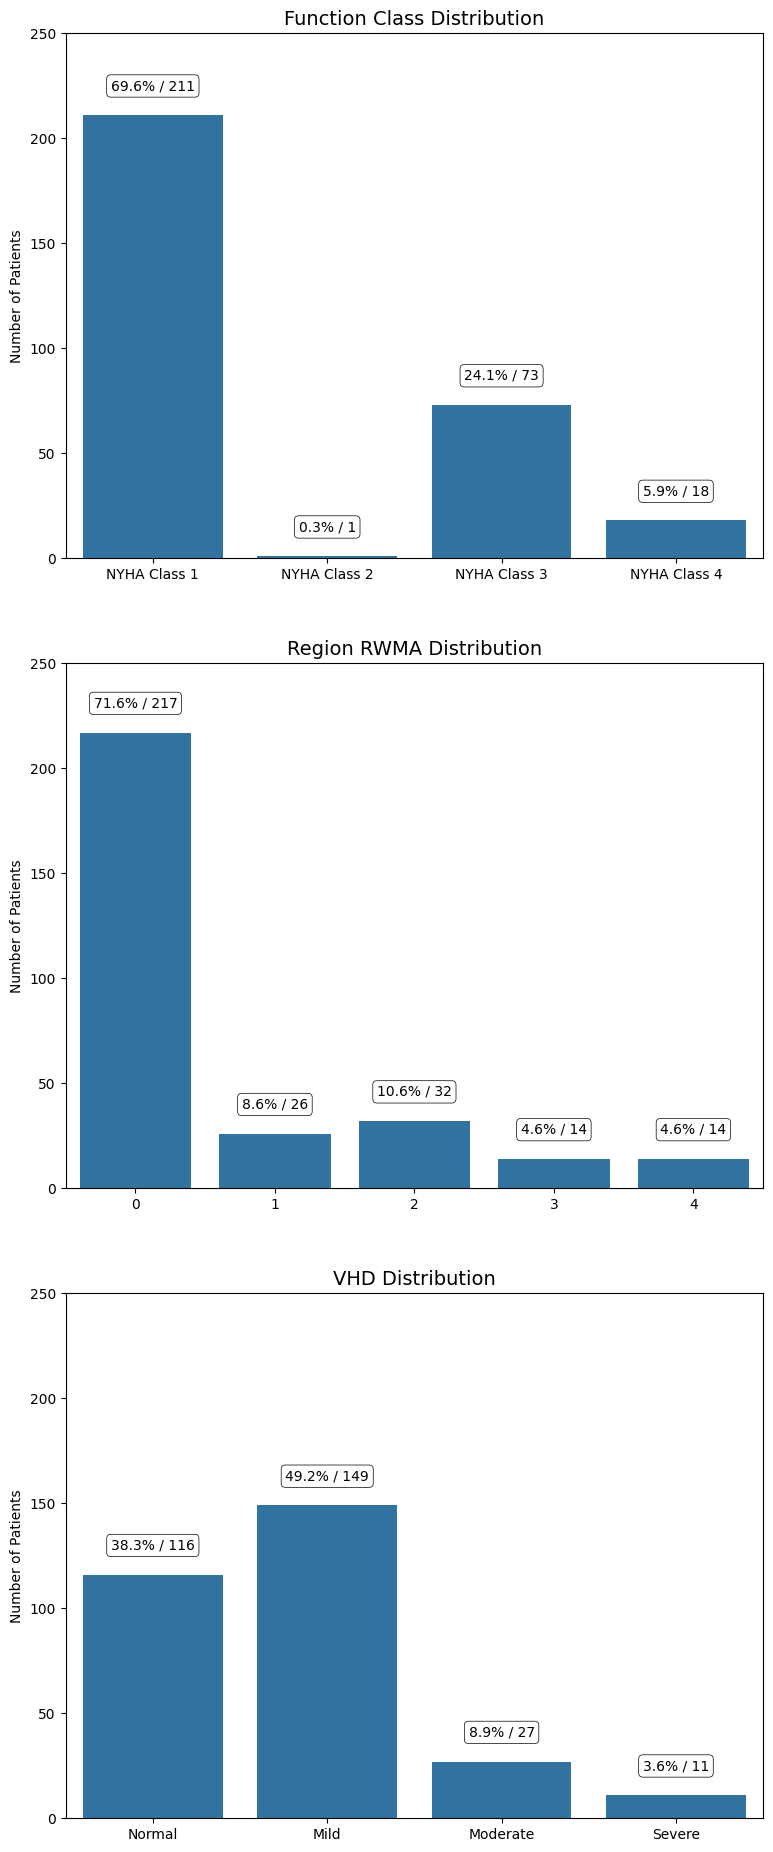

In [20]:
n_rows, n_cols = 3, 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(9,15))

for i, ord_col in enumerate(ord_cols):
    i, j = i//n_cols, i%n_cols
    rects = sns.countplot(x=ord_col, data=data, ax=ax[i])

    for rect in rects.patches:
        height = rect.get_height()
        ax[i].text(rect.get_x()+rect.get_width()/2., height+12, "{:1.1f}% / {:d}".format(height/len(data)*100, height.astype(int)), ha='center', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    ax[i].set_title(f'{ord_col} Distribution', fontsize=14)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Number of Patients")
    ax[i].set_ylim([0, 250])

ax[0].set_xticklabels(['NYHA Class 1', 'NYHA Class 2', 'NYHA Class 3', 'NYHA Class 4'])
ax[2].set_xticklabels(['Normal', 'Mild', 'Moderate', 'Severe'])

fig.subplots_adjust(top=1.3)
fig.show()

Also we can see the class imbalance problem in the ordinal variables.

## Numerical Variables

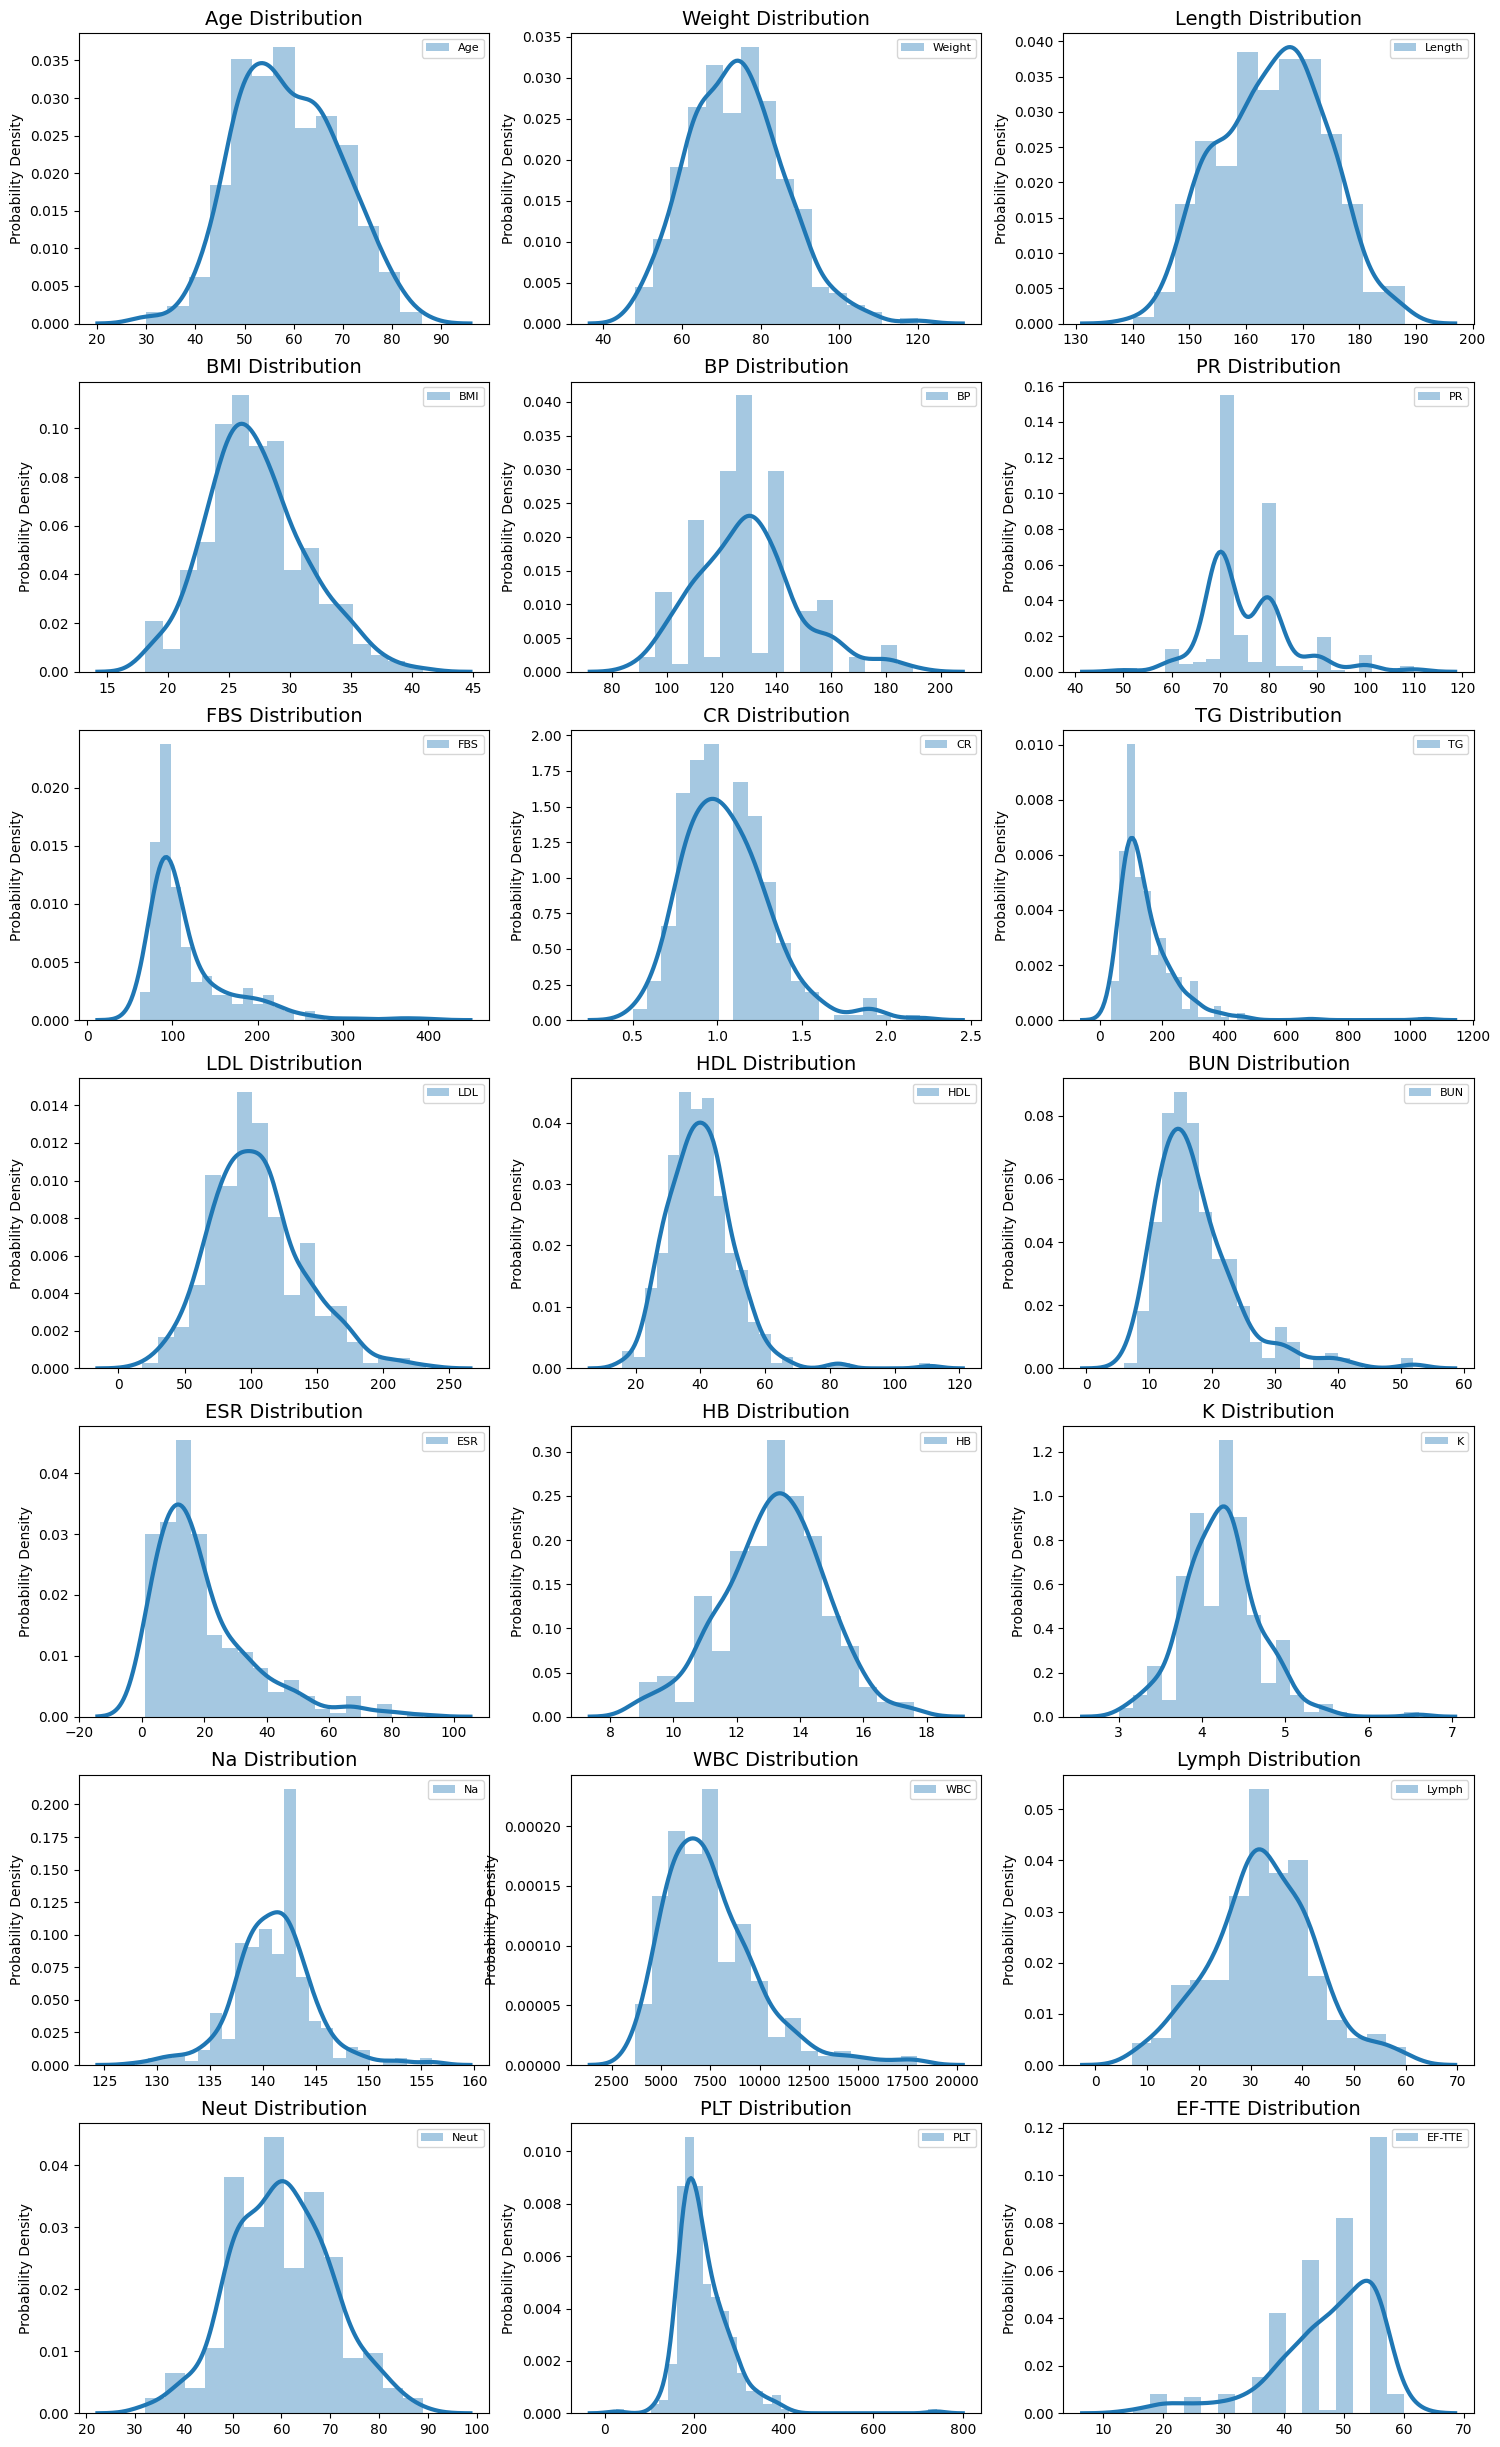

In [21]:
n_rows, n_cols = 7, 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(18,20))

for i, num_col in enumerate(num_cols):
    i, j = i//n_cols, i%n_cols

    figure = sns.distplot(data[num_col], label=num_col, norm_hist=True, ax=ax[i,j], kde_kws={"lw":3})
    figure = figure.legend(loc='best', fontsize=8)

    ax[i,j].set_title(f'{num_col} Distribution', fontsize=14)
    ax[i,j].set_ylabel("Probability Density", fontsize="medium")
    ax[i,j].set_xlabel("")

fig.subplots_adjust(top=1.3)
fig.show()

Distribution of continuous features are not uniform, and has a certain skewness. Let's check outliers by plotting `boxplot`.

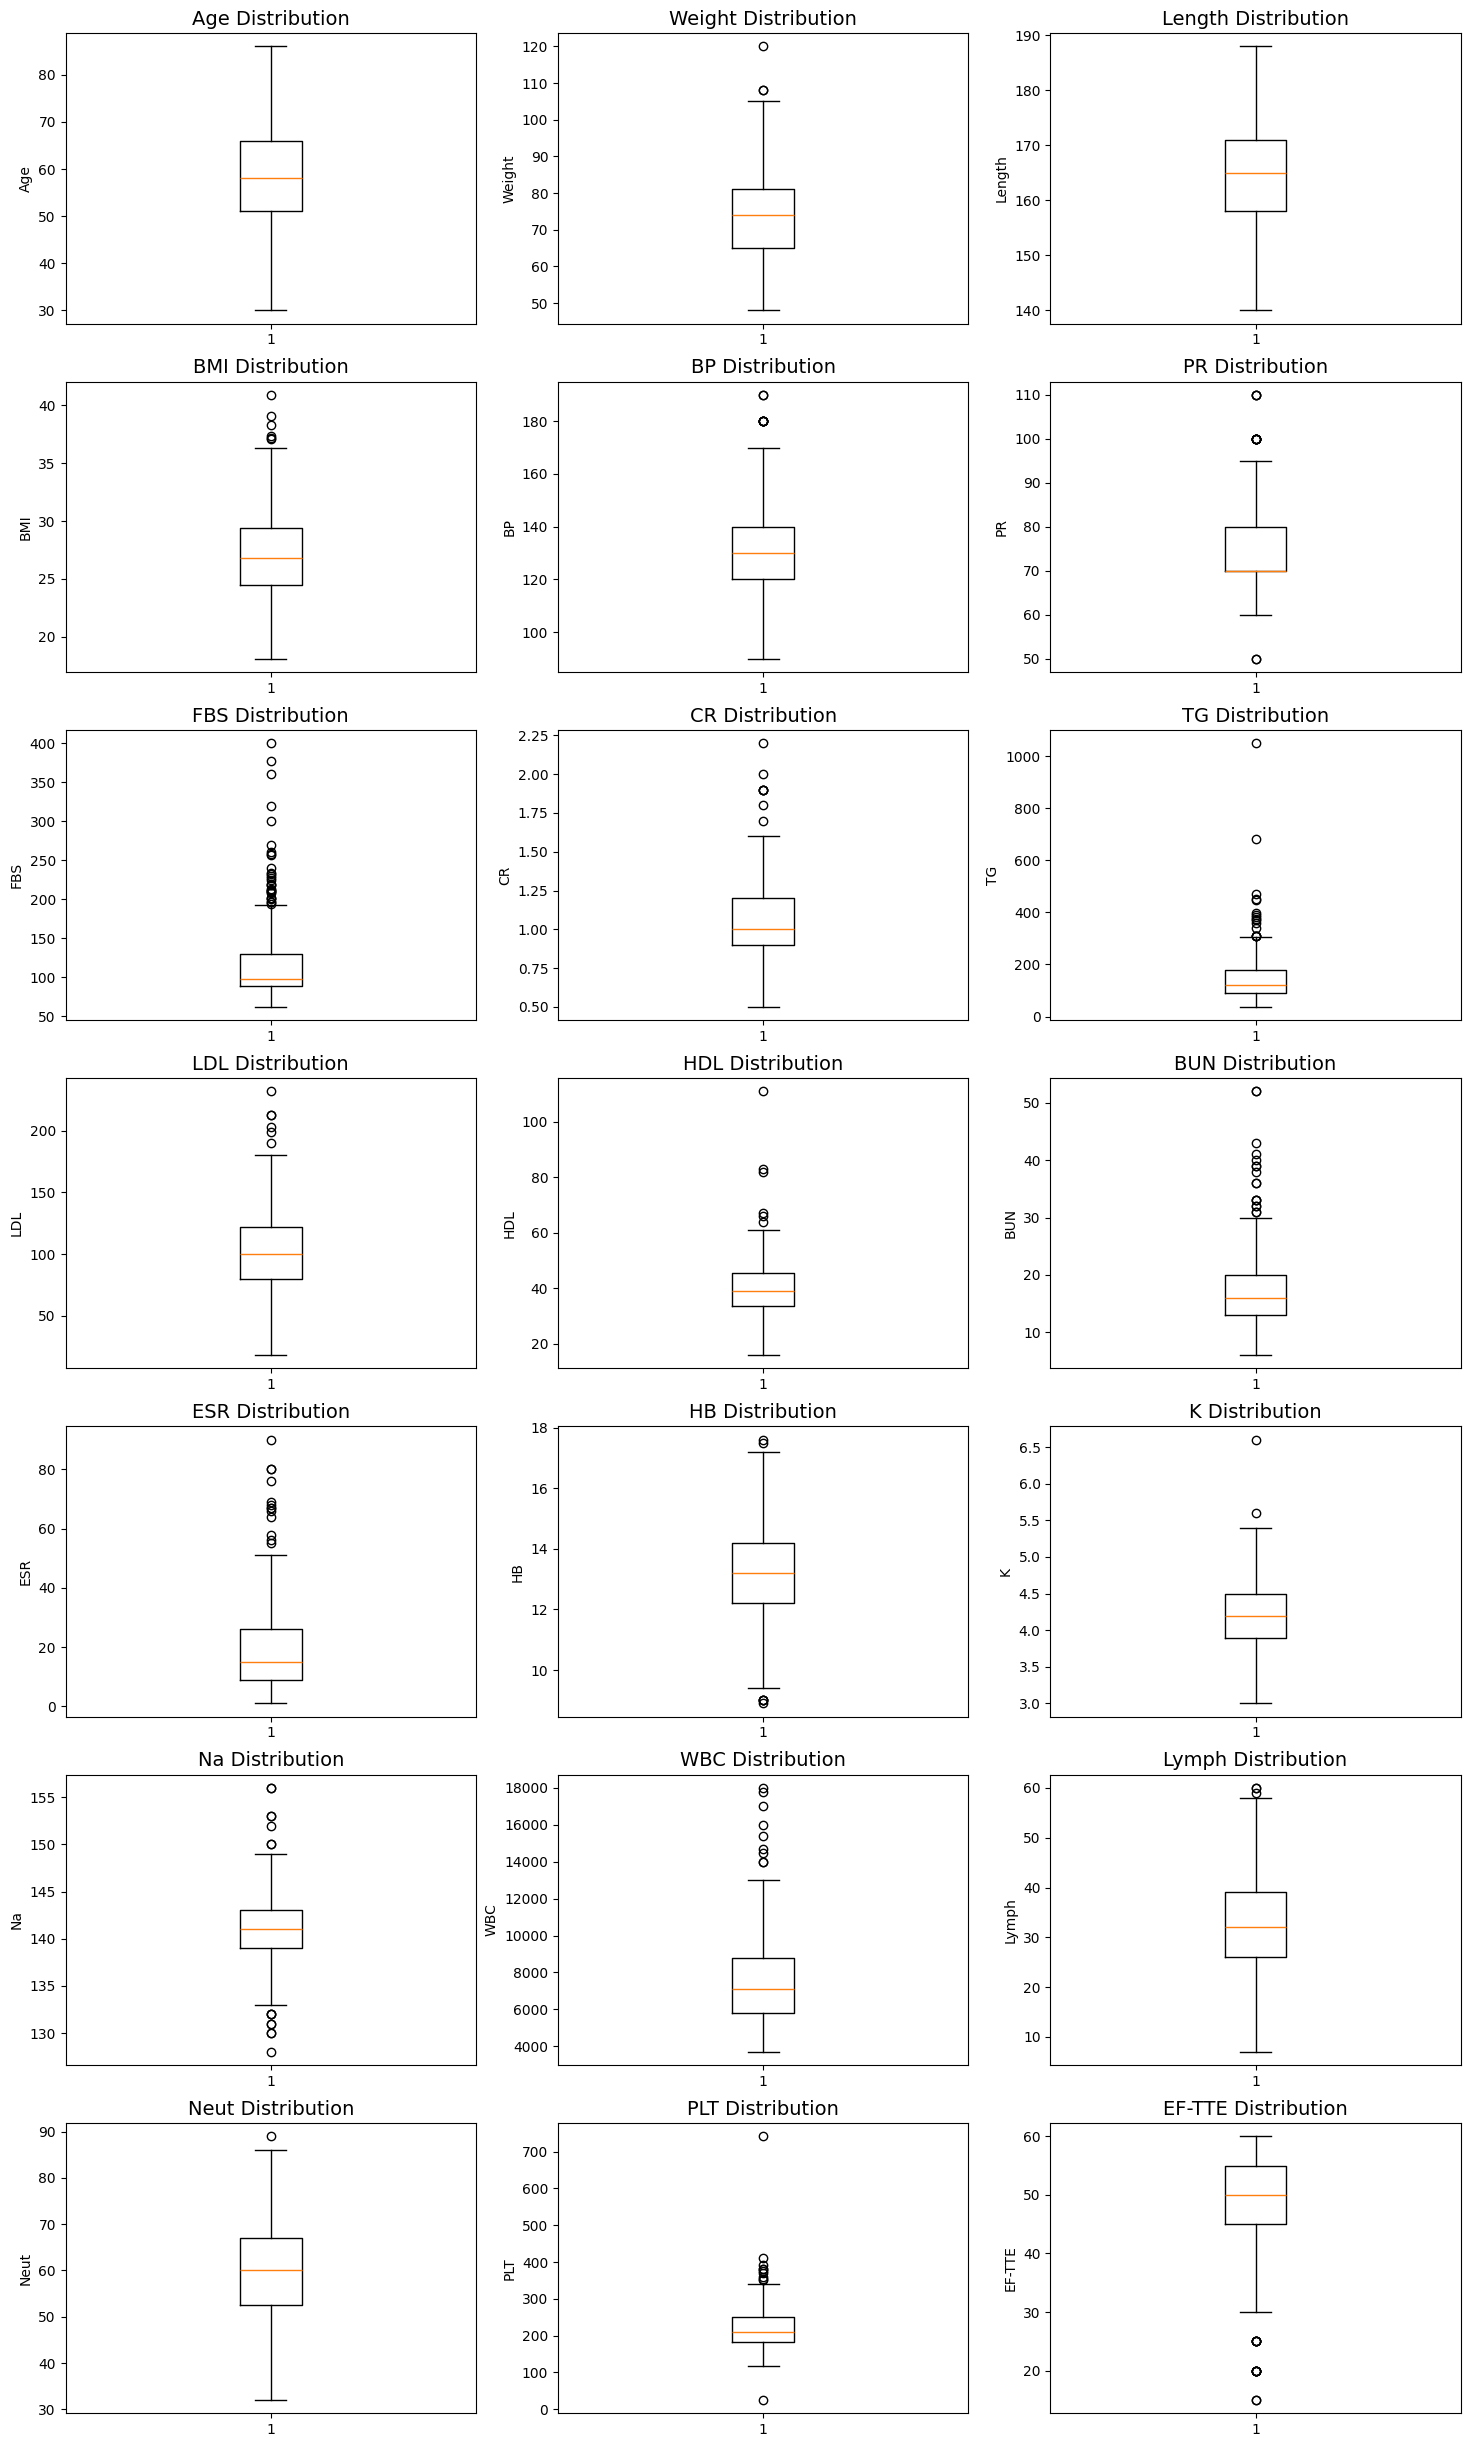

In [22]:
n_rows, n_cols = 7, 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(18,20))

for i, num_col in enumerate(num_cols):
    i, j = i//n_cols, i%n_cols

    ax[i,j].set_title(f'{num_col} Distribution', fontsize=14)
    ax[i,j].set_ylabel(f"{num_col}", fontsize="medium")
    ax[i,j].set_xlabel("")

    ax[i,j].boxplot(data[num_col])

fig.subplots_adjust(top=1.3)
fig.show()

Feature `BMI`, `FBS`, `CR`, `TG`, `ESR`, `Na`, `WBC`, `PLT` have a lot of outliers.

# 2.3 - Bivariate Analysis

# 2.3.1 - Categorical Variables

In [23]:
cat_cols = ['Sex', 'DM', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Edema', 'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur', 'Diastolic Murmur', 'Typical Chest Pain','Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'Q Wave', 'St Elevation', 'St Depression', 'Tinversion','LVH', 'Poor R Progression', 'Cath']

# Patient Characteristics (4)
cat_cols_char = ['Sex', 'Current Smoker', 'EX-Smoker', 'FH']

# Underlying disease (9)
cat_cols_dz = ['DM', 'HTN', 'Obesity', 'CRF', 'CVA', 'Airway disease', 'Thyroid Disease', 'CHF', 'DLP']

# Physical exam (5)
cat_cols_pe = ['Edema', 'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur', 'Diastolic Murmur']

# Symptoms (6)
cat_cols_sx = ['Typical Chest Pain', 'Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang']

# ECG Data (6)
cat_cols_ecg = ['Q Wave', 'St Elevation', 'St Depression', 'Tinversion', 'LVH', 'Poor R Progression']

df = data.copy()
df["Cath_binary"] = df["Cath"].apply(lambda x: 1 if x=="Cad" else 0)

We will divide categorical variables into five groups:

1. Patient Characteristics
2. Underlying disease
3. Physical exam
4. Symptoms
5. ECG Data

To compare number of CAD cases between `Features`=0 and `Features`=1, I made `Cath_binary` variable.

## Patient Characteristics vs CAD

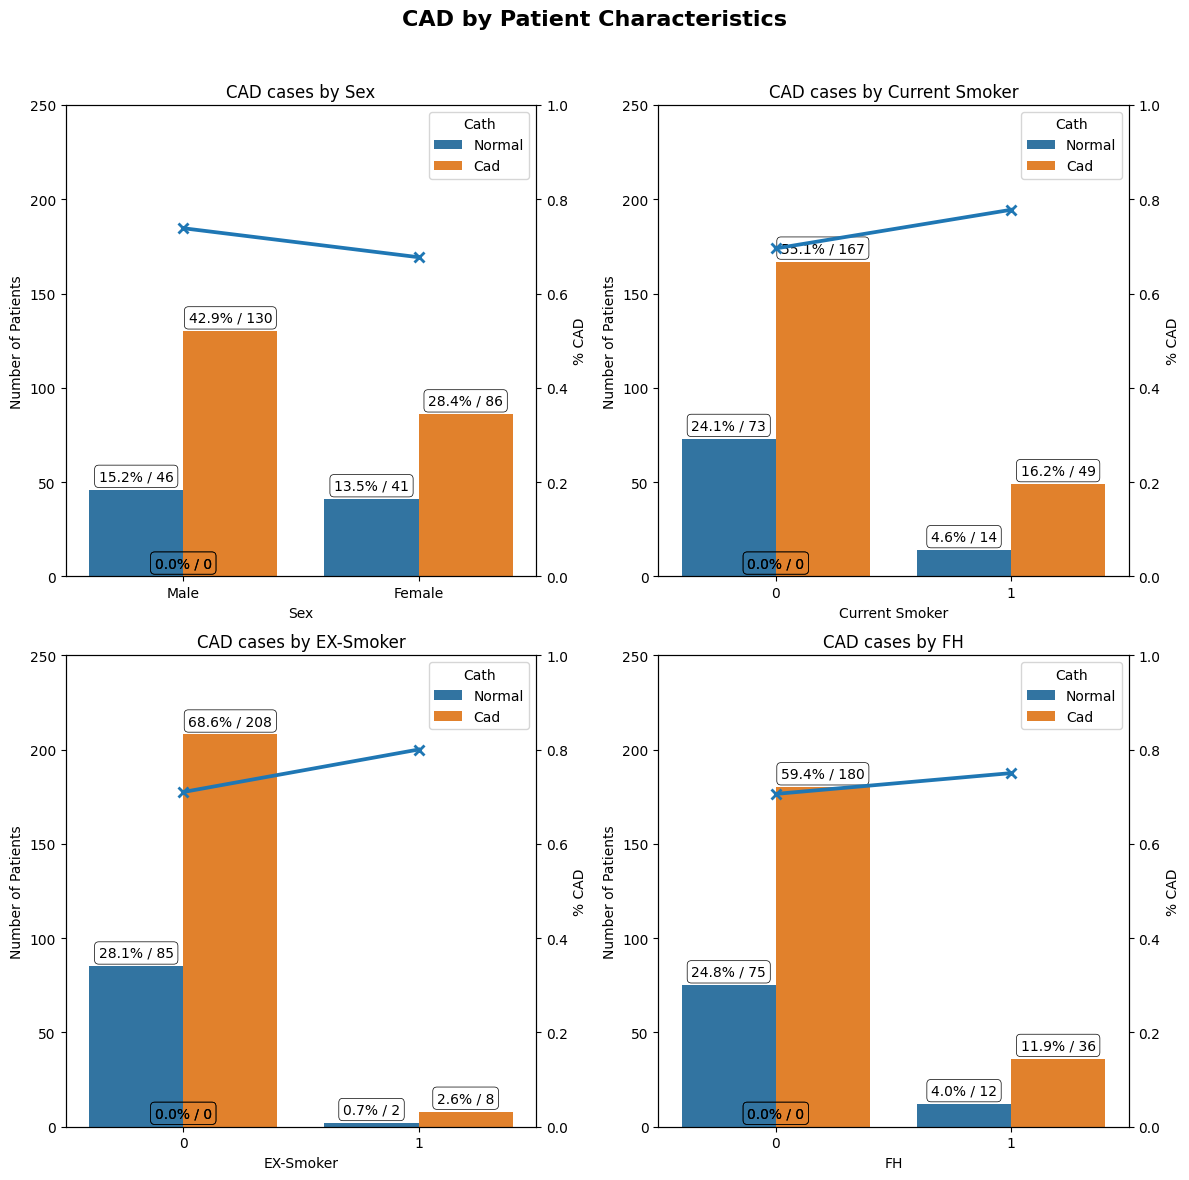

In [24]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
fig.suptitle("CAD by Patient Characteristics\n", fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

for idx, col in enumerate(cat_cols_char):
    ax = axes[idx]  # Access the correct subplot

    # Plot countplot
    rects = sns.countplot(x=col, hue="Cath", hue_order=['Normal', 'Cad'], data=df, ax=ax)

    # Add annotations
    for rect in rects.patches:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,  # X position
            height + 5,  # Y position
            "{:1.1f}% / {:d}".format(height / len(df) * 100, int(height)),  # Format percentage and count
            ha='center',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5)
        )

    # Set labels and title
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    ax.set_ylim([0, 250])
    ax.set_title(f'CAD cases by {col}', fontsize=12)

    # Add secondary axis
    ax2 = ax.twinx()
    sns.pointplot(x=col, y="Cath_binary", data=df, markers='x', ax=ax2, errorbar=None)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% CAD", color='black')

# Hide unused axes
for idx in range(len(cat_cols_char), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(top=0.9)  # Space for the title
plt.show()


- `Sex`=Male, `Current smoker`=1, `Ex-Smoker`=1, and `FH`=1 group have more CAD cases than the opposite.

## Underlying Disease vs CAD

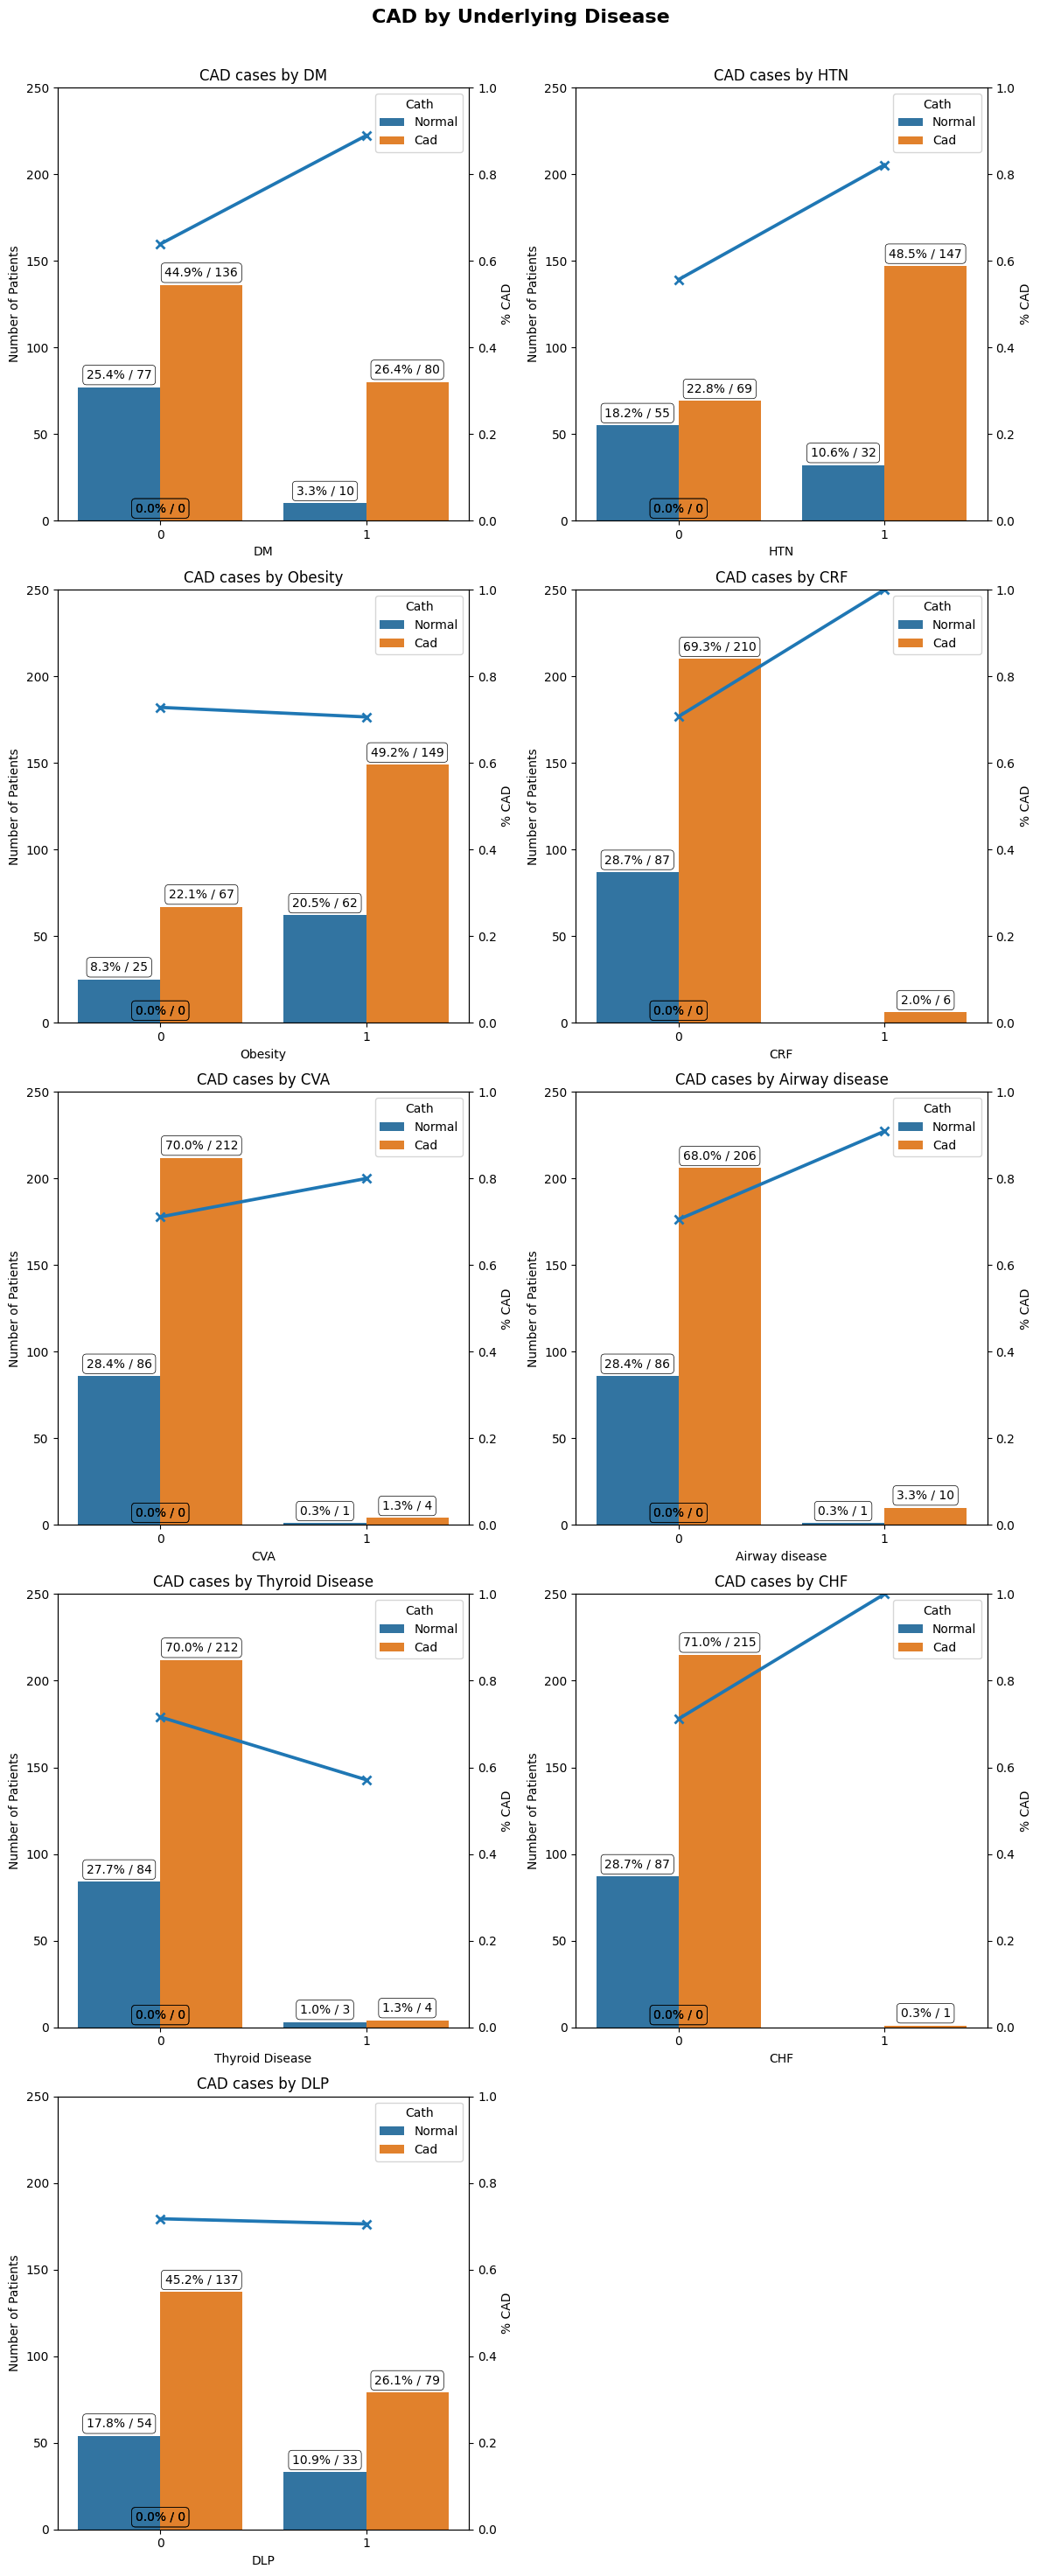

In [25]:
n_rows, n_cols = 5, 2

# Create the subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 30))
fig.suptitle("CAD by Underlying Disease\n", fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through columns in cat_cols_dz
for i, col in enumerate(cat_cols_dz):
    ax = axes[i]  # Access the correct subplot

    # Plot countplot
    rects = sns.countplot(x=col, hue="Cath", hue_order=['Normal', 'Cad'], data=df, ax=ax)

    # Add annotations
    for rect in rects.patches:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,  # X position
            height + 5,  # Y position
            "{:1.1f}% / {:d}".format(height / len(df) * 100, int(height)),  # Format percentage and count
            ha='center',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5)
        )

    # Set labels and title
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    ax.set_ylim([0, 250])
    ax.set_title(f'CAD cases by {col}', fontsize=12)

    # Add secondary axis
    ax2 = ax.twinx()
    sns.pointplot(x=col, y="Cath_binary", data=df, markers='x', ax=ax2, errorbar=None)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% CAD", color='black')

# Hide unused axes
for i in range(len(cat_cols_dz), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(top=0.95)  # Space for the title
plt.show()


- `DM`=1, `HTN`=1, `CRF`=1, `CVA`=1, `Airway disease`=1, `CHF`=1 group have more CAD cases than the opposite.

- `Obesity`=1, `Thyroid disease`=1, `DLP`=1 group have less CAD cases than the opposite.

## Physical Exam vs CAD

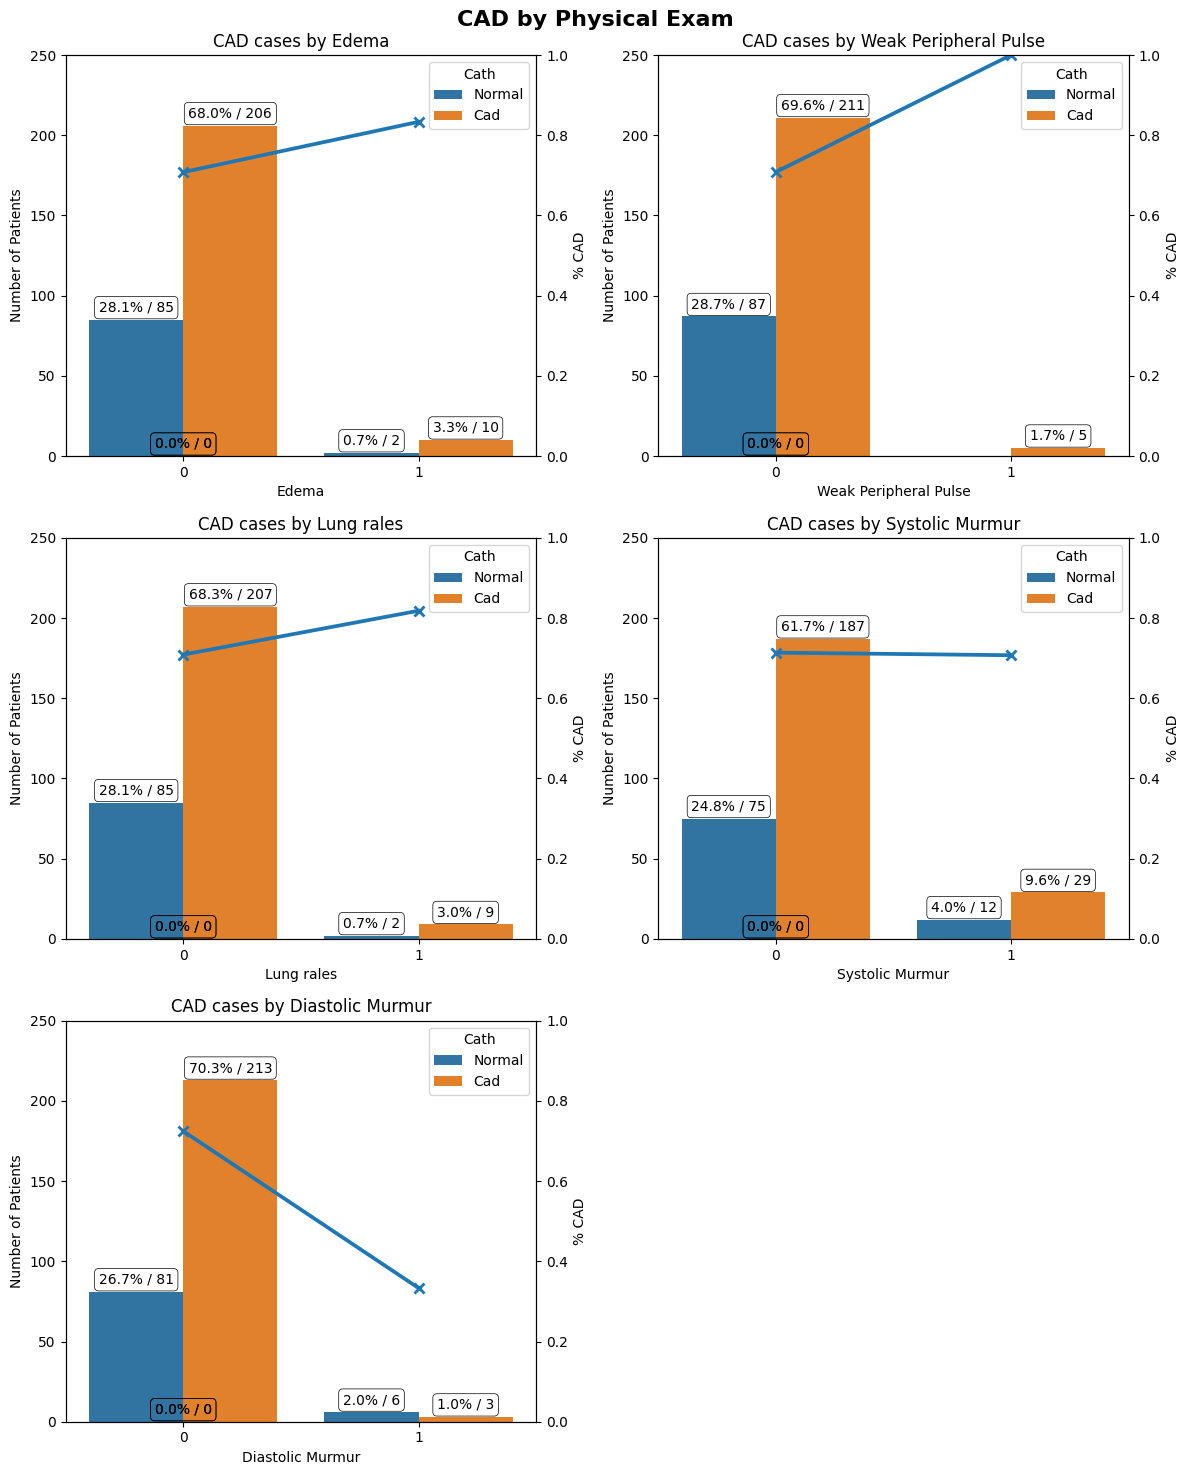

In [26]:
n_rows, n_cols = 3, 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 15))
fig.suptitle("CAD by Physical Exam\n", fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through the columns in cat_cols_pe
for i, col in enumerate(cat_cols_pe):
    ax = axes[i]  # Access the correct subplot

    # Plot countplot for each feature
    rects = sns.countplot(x=col, hue="Cath", hue_order=['Normal', 'Cad'], data=df, ax=ax)

    # Add annotations to the bars
    for rect in rects.patches:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,  # X position
            height + 5,  # Y position
            "{:1.1f}% / {:d}".format(height / len(df) * 100, int(height)),  # Format percentage and count
            ha='center',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5)
        )

    # Set labels and title for each subplot
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    ax.set_ylim([0, 250])
    ax.set_title(f'CAD cases by {col}', fontsize=12)

    # Add secondary axis for pointplot
    ax2 = ax.twinx()
    sns.pointplot(x=col, y="Cath_binary", data=df, markers='x', ax=ax2, errorbar=None)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% CAD", color='black')

# Hide any unused axes
for i in range(len(cat_cols_pe), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(top=0.95)  # Space for the title
plt.show()


- `Edema`=1, `Weak Peripheral Pulse`=1, and `Lung rales`=1 group have more CAD cases than the opposite.

- `Systolic murmur`=1 and`Diastolic murmur`=1 group have less CAD cases than the opposite.


## Symptoms vs CAD

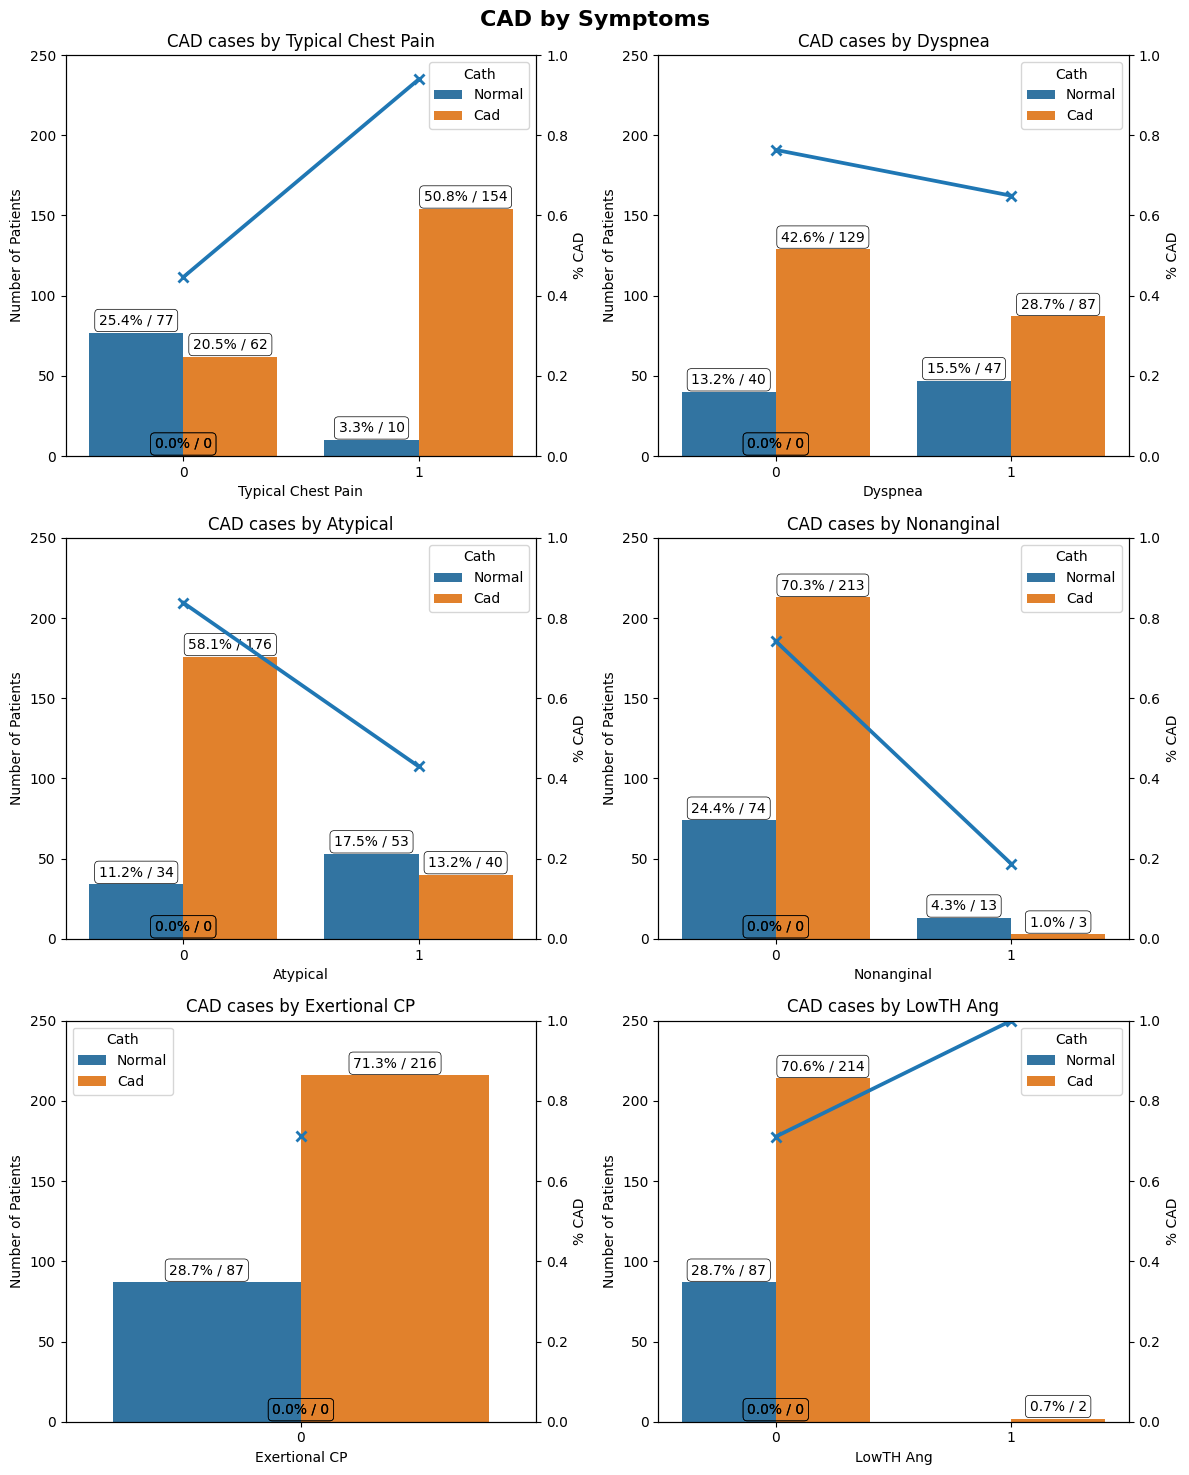

In [27]:
n_rows, n_cols = 3, 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 15))
fig.suptitle("CAD by Symptoms\n", fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through the columns in cat_cols_sx
for i, col in enumerate(cat_cols_sx):
    ax = axes[i]  # Access the correct subplot

    # Plot countplot for each feature
    rects = sns.countplot(x=col, hue="Cath", hue_order=['Normal', 'Cad'], data=df, ax=ax)

    # Add annotations to the bars
    for rect in rects.patches:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,  # X position
            height + 5,  # Y position
            "{:1.1f}% / {:d}".format(height / len(df) * 100, int(height)),  # Format percentage and count
            ha='center',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5)
        )

    # Set labels and title for each subplot
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    ax.set_ylim([0, 250])
    ax.set_title(f'CAD cases by {col}', fontsize=12)

    # Add secondary axis for pointplot
    ax2 = ax.twinx()
    sns.pointplot(x=col, y="Cath_binary", data=df, markers='x', ax=ax2, errorbar=None)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% CAD", color='black')

# Hide any unused axes
for i in range(len(cat_cols_sx), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(top=0.95)  # Space for the title
plt.show()


- `Typical Chest Pain`=1 and `LowTH Ang`=1 group have more CAD cases than the opposite.

- `Dyspnea`=1, `Atypical`=1, and `Nonanginal` group have less CAD cases than the opposite.

## ECG Data vs CAD

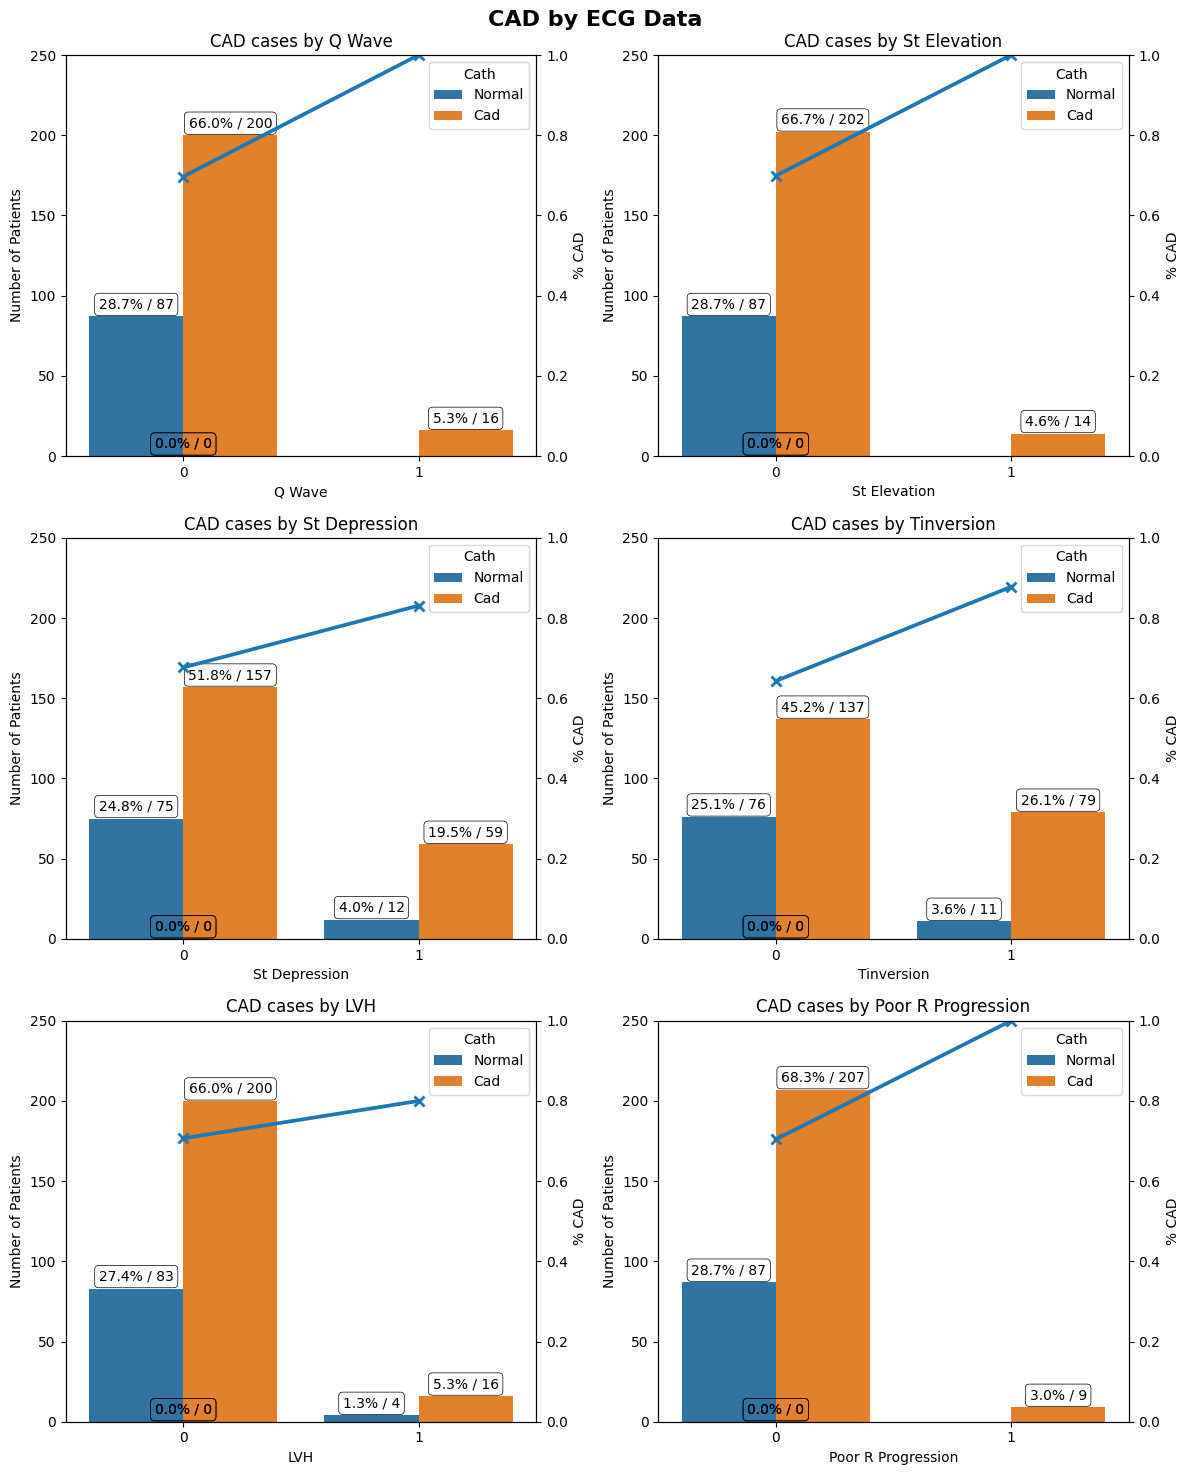

In [28]:
n_rows, n_cols = 3, 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 15))
fig.suptitle("CAD by ECG Data\n", fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through the columns in cat_cols_ecg
for i, col in enumerate(cat_cols_ecg):
    ax = axes[i]  # Access the correct subplot

    # Plot countplot for each ECG feature
    rects = sns.countplot(x=col, hue="Cath", hue_order=['Normal', 'Cad'], data=df, ax=ax)

    # Add annotations to the bars
    for rect in rects.patches:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,  # X position
            height + 5,  # Y position
            "{:1.1f}% / {:d}".format(height / len(df) * 100, int(height)),  # Format percentage and count
            ha='center',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5)
        )

    # Set labels and title for each subplot
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    ax.set_ylim([0, 250])
    ax.set_title(f'CAD cases by {col}', fontsize=12)

    # Add secondary axis for pointplot
    ax2 = ax.twinx()
    sns.pointplot(x=col, y="Cath_binary", data=df, markers='x', ax=ax2, errorbar=None)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% CAD", color='black')

# Hide any unused axes
for i in range(len(cat_cols_ecg), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(top=0.95)  # Space for the title
plt.show()


- `Q wave`=1, `St elevation`=1, `St Depression`=1, `Tinversion`=1, `LVH`=1, and `Poor R Progression`=1 group have more CAD cases than the opposite. (All ECG Abnormalities)

# 2.3.2 - Ordinal Variables

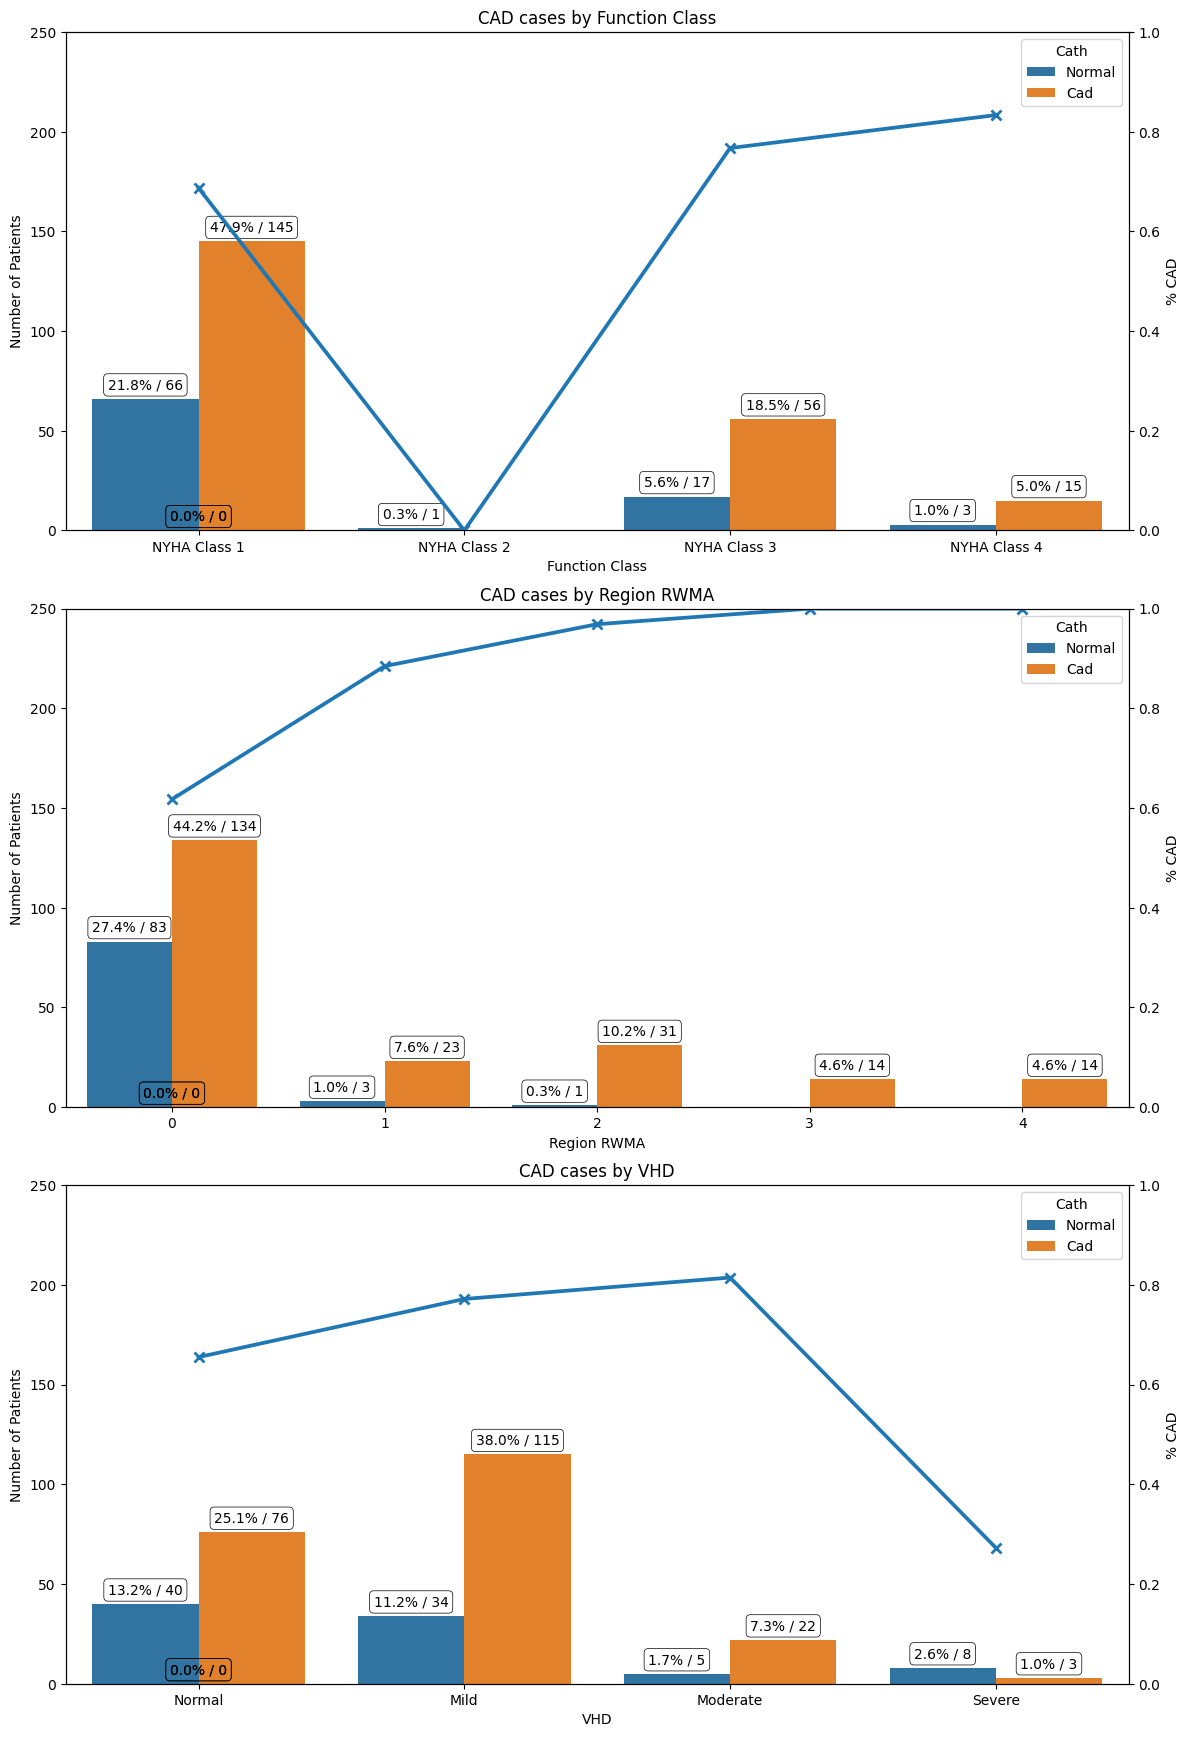

In [29]:
ord_cols = ['Function Class', "Region RWMA", "VHD"]

n_rows, n_cols = 3, 1

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 18))

# Iterate through each ordinal column
for i, col in enumerate(ord_cols):
    ax = axes[i]  # Directly access the i-th subplot

    # Plot the countplot
    rects = sns.countplot(x=col, hue="Cath", hue_order=['Normal', 'Cad'], data=df, ax=ax)

    # Annotate each bar with percentage and count
    for rect in rects.patches:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,  # X position
            height + 5,  # Y position
            "{:1.1f}% / {:d}".format(height / len(df) * 100, int(height)),  # Format percentage and count
            ha='center',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5)
        )

    # Set labels and titles
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    ax.set_ylim([0, 250])
    ax.set_title(f'CAD cases by {col}', fontsize=12)

    # Add secondary axis for pointplot
    ax2 = ax.twinx()
    sns.pointplot(x=col, y="Cath_binary", data=df, markers='x', ax=ax2, errorbar=None)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel("% CAD", color='black')

# Set x-tick labels for the first and third subplots
axes[0].set_xticklabels(['NYHA Class 1', 'NYHA Class 2', 'NYHA Class 3', 'NYHA Class 4'])
axes[2].set_xticklabels(['Normal', 'Mild', 'Moderate', 'Severe'])

# Adjust layout to prevent overlap and show the plot
fig.tight_layout()
plt.subplots_adjust(top=0.95)  # Make space for the suptitle
plt.show()


- `Function Class`, `Regional RWMA` and `VHD` have positive correlation with target variables `Cath`.

# 2.3.3 - Numerical Variables

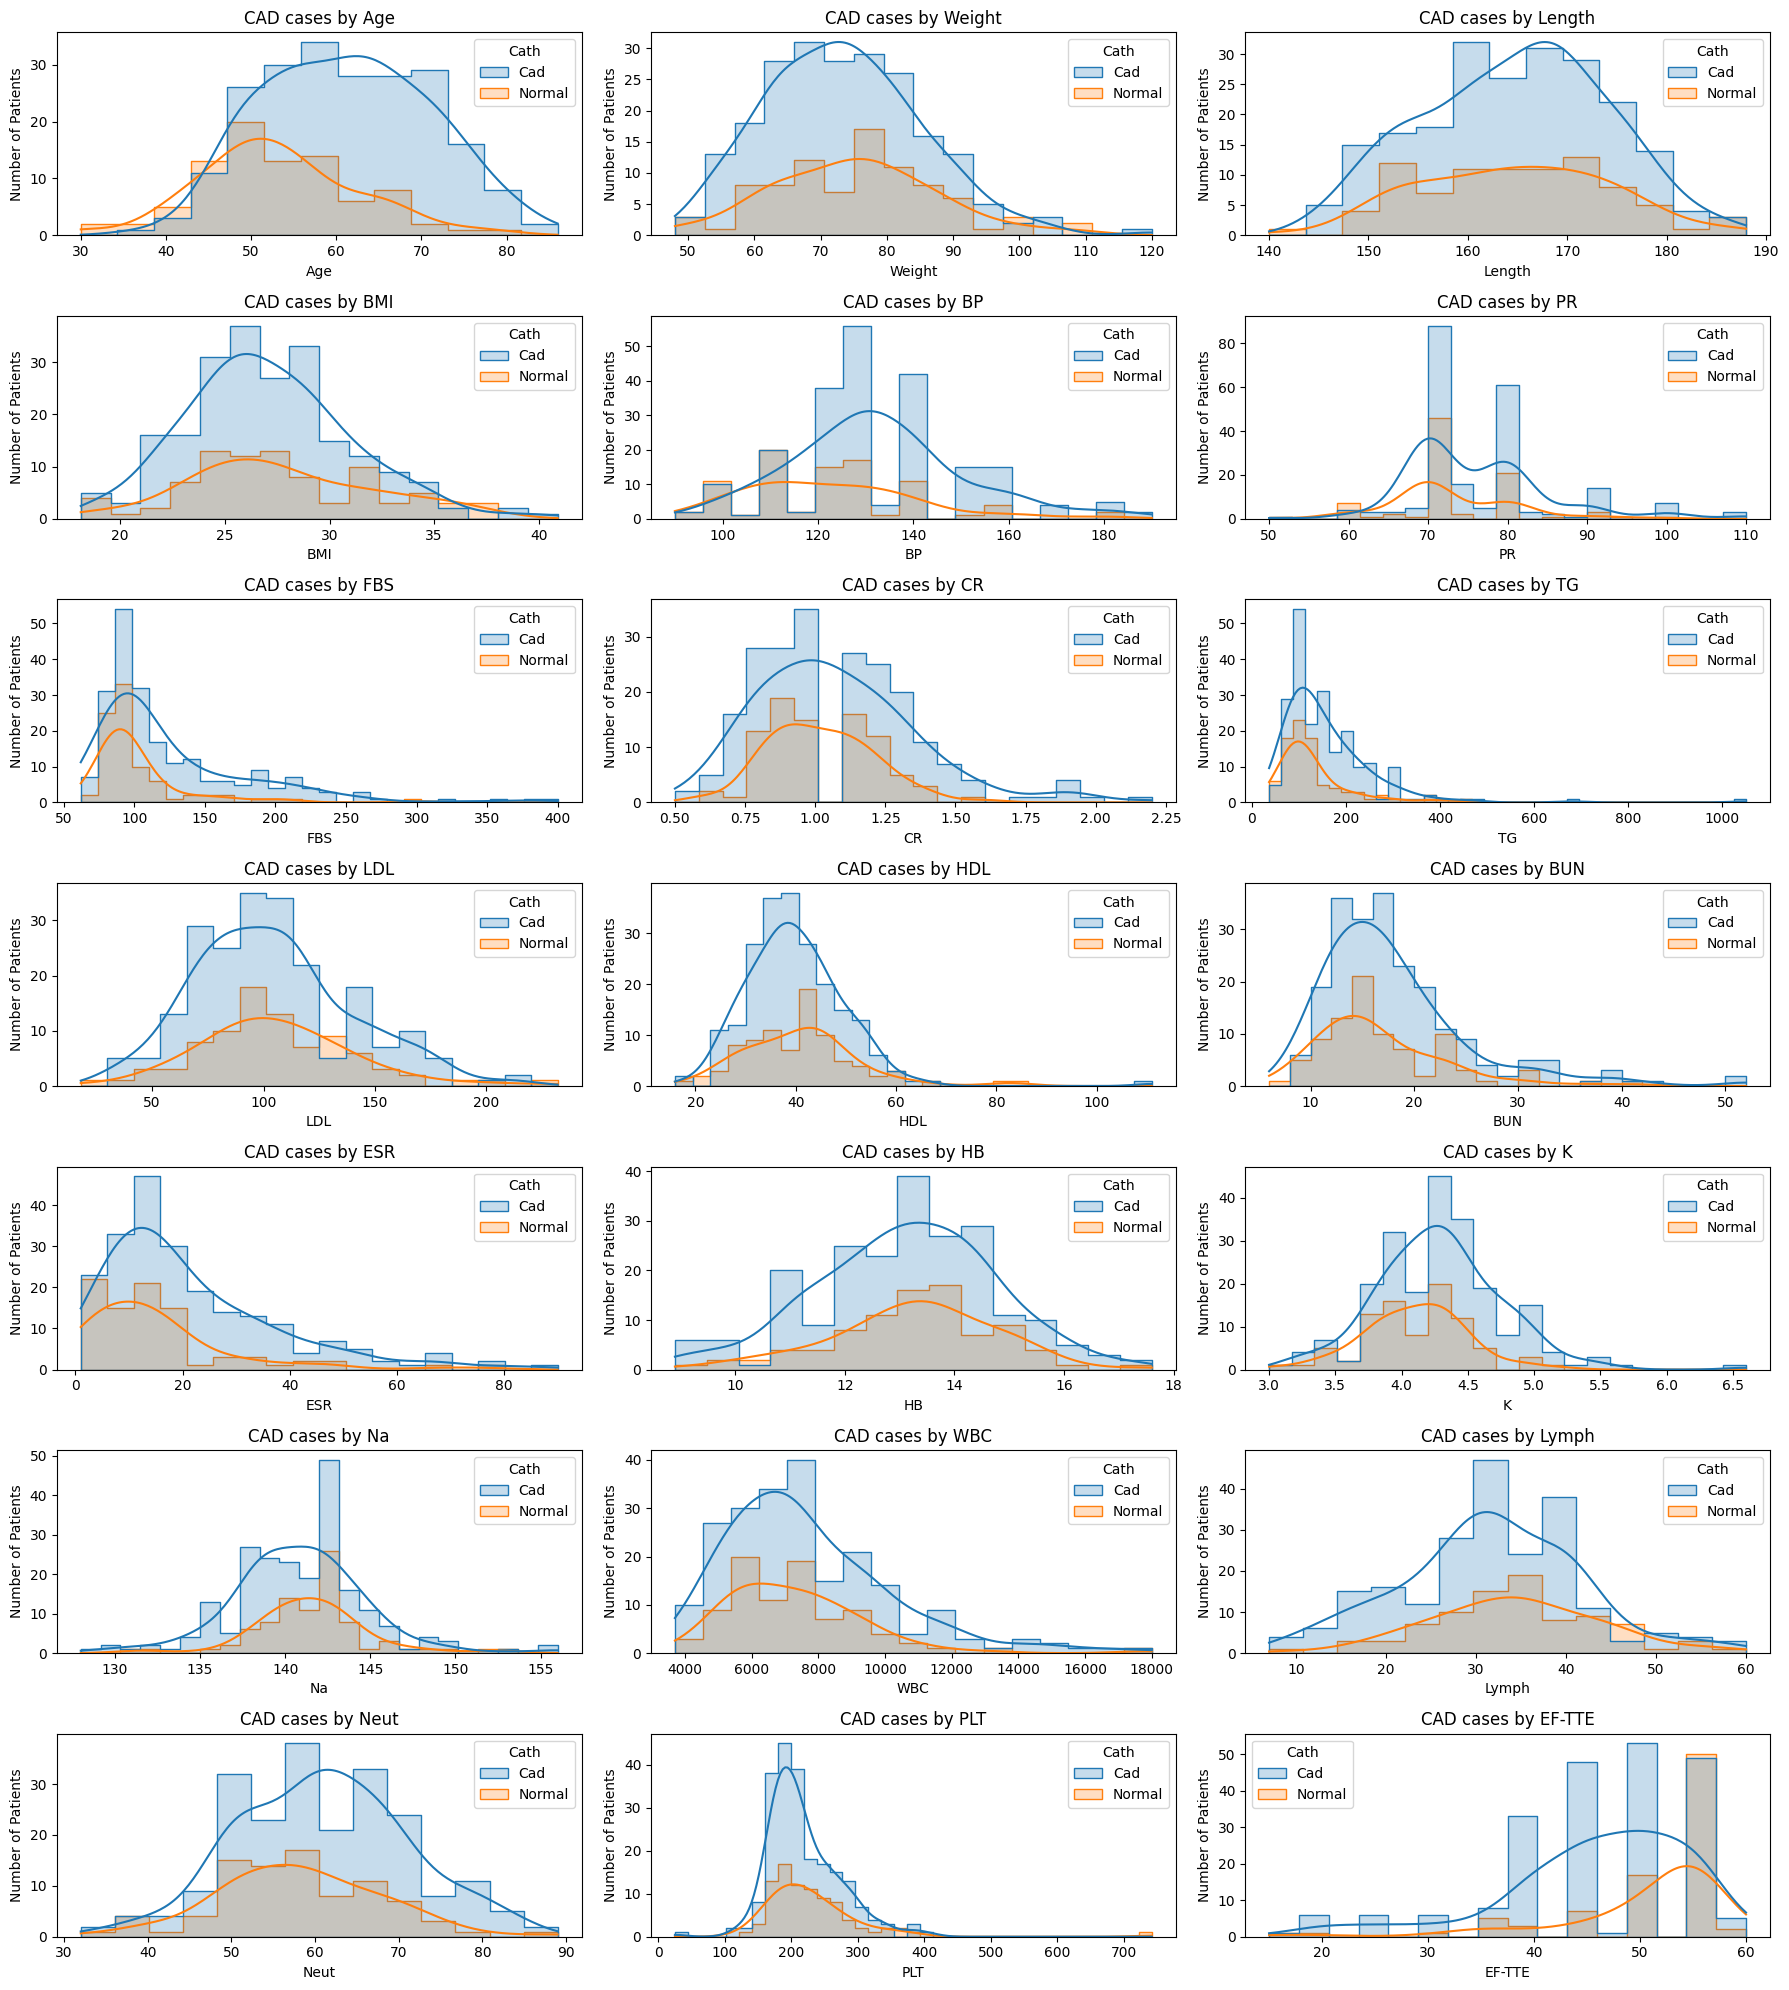

In [30]:
num_cols = ['Age','Weight', 'Length','BMI', 'BP', 'PR', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE']

n_rows, n_cols = 7, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))

for i, col in enumerate(num_cols):
    i, j = i//n_cols, i%n_cols
    ax = axes[i][j]

    #sns.set_style("darkgrid")
    ax = sns.histplot(data=data, x=col, hue="Cath", kde=True, ax=ax, element="step")

    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    #ax.set_ylim([0,100])
    ax.set_title(f'CAD cases by {col}', fontsize=12)


fig.tight_layout()
fig.show()

There is some distribution difference between `Cad` group and `Normal` group. Let's plot `boxplot` to compare more easily and detect outliers.

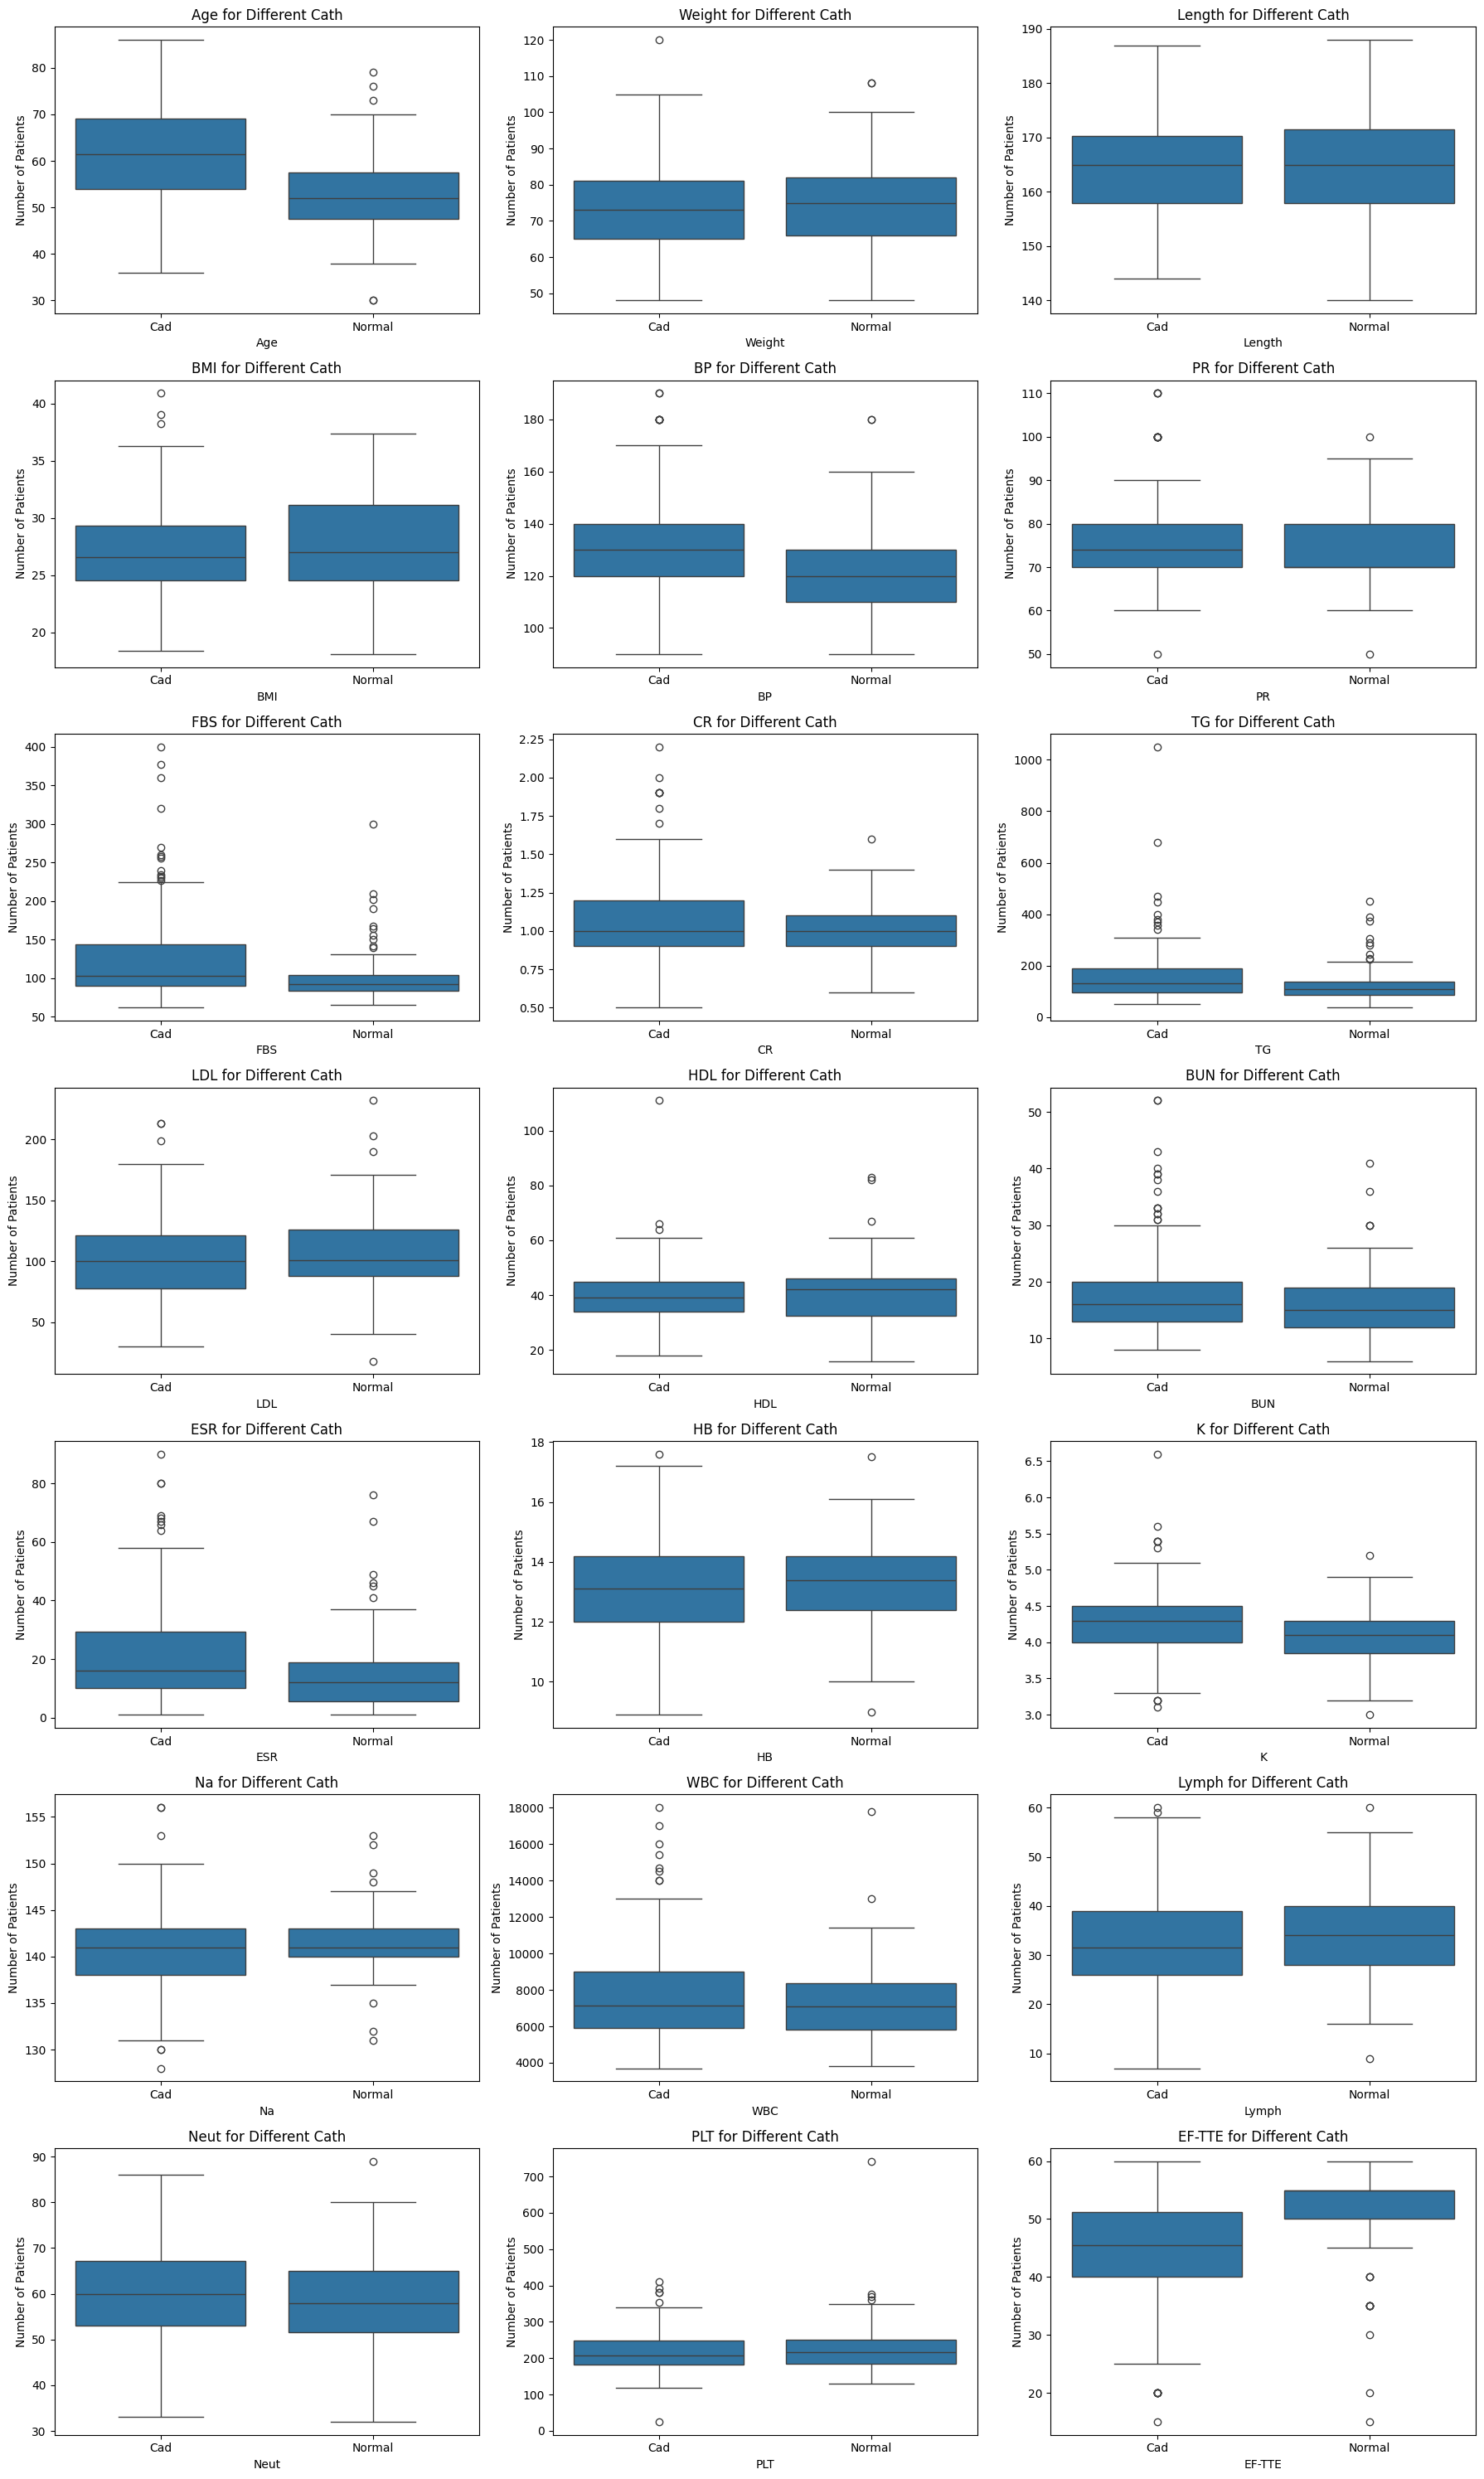

In [31]:
num_cols = ['Age','Weight', 'Length','BMI', 'BP', 'PR', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE']

n_rows, n_cols = 7, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))

for i, col in enumerate(num_cols):
    i, j = i//n_cols, i%n_cols
    ax = axes[i][j]

    #sns.set_style("darkgrid")
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Patients", fontsize="medium")
    #ax.set_ylim([0,100])
    ax.set_title(f'{col} for Different Cath', fontsize=12)
    figure = sns.boxplot(x='Cath', y=col, data=data, ax=ax)



fig.tight_layout()
fig.show()

# 2.4 - Multivariate Analysis

## Chest Pain Type vs CAD

 Chest pain is the cardinal symptom of coronary artery disease, and this dataset contains five variables about chest pain. So Let's analyze the relationship between chest pain type and CAD.

In [32]:
!pip install jinja2

In [34]:
data.groupby(['Typical Chest Pain', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang'])['Cath'].value_counts(normalize=False).to_frame(name="Number of Patients").style.background_gradient(cmap='Blues')

In [35]:
data.groupby(['Typical Chest Pain', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang'])['Cath'].value_counts(normalize=True).mul(100).round(3).to_frame(name="Percent within group (%)").style.background_gradient(cmap='Blues')

 As we saw in the Dataset Description part, chest pain can be classified into three categories, which are `Typical Chest Pain`, `Atypical`, and `Nonanginal`. And `Exertional CP` has only `0` values. And `LowTH Ang` has only two `1` values.

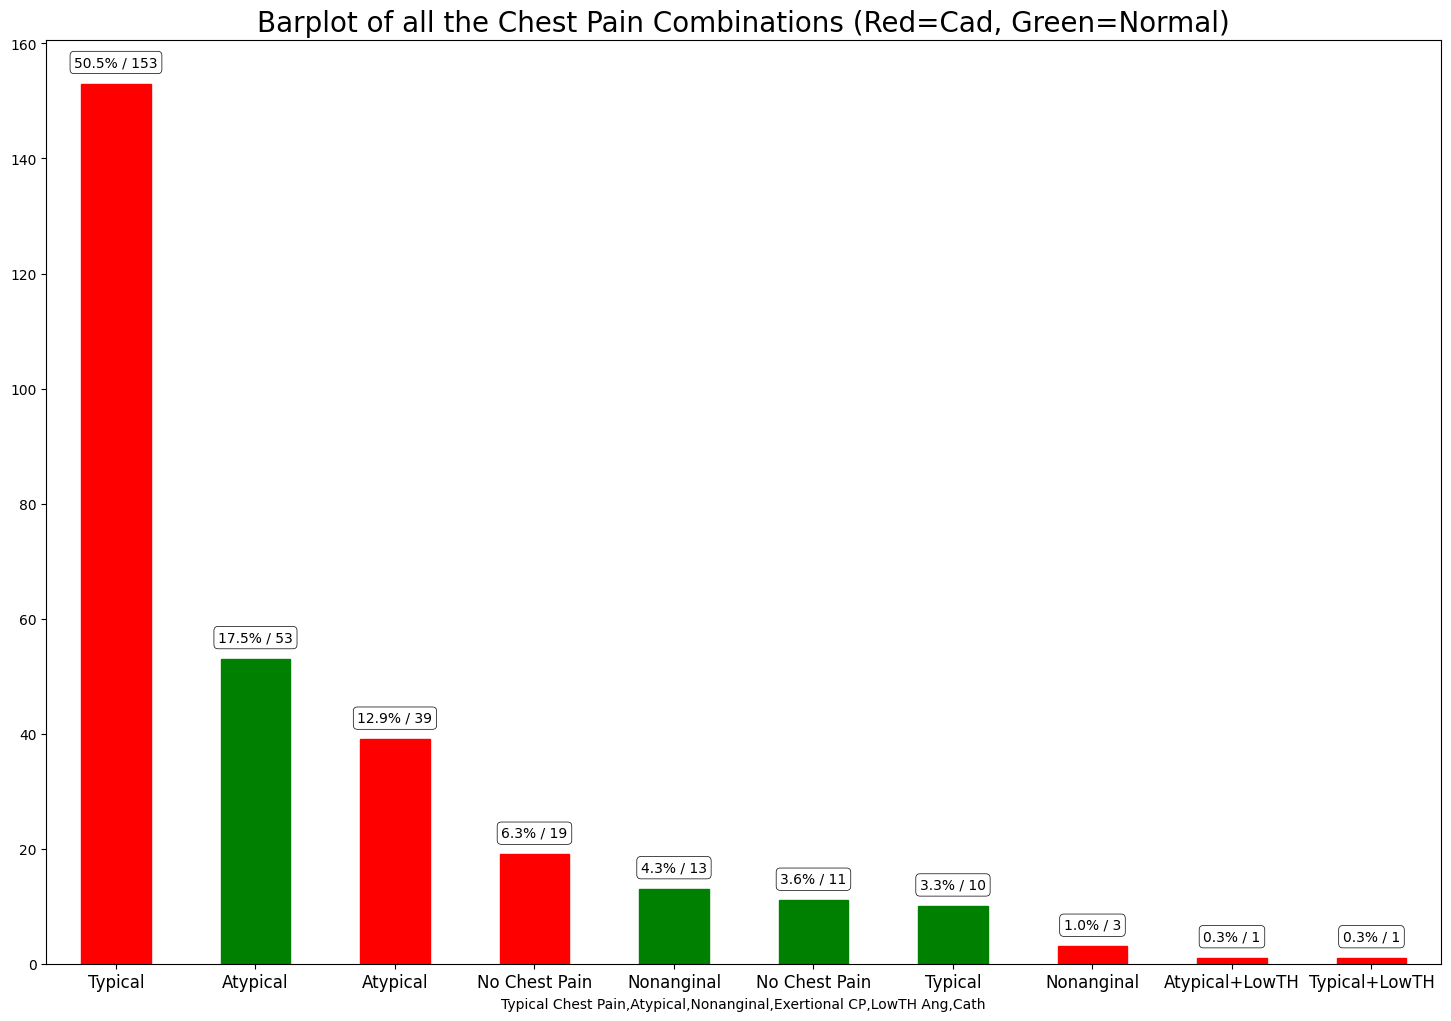

In [36]:
cp_dt = data.groupby(['Typical Chest Pain', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang'])['Cath'].value_counts(normalize=False).sort_values(ascending=False).to_frame(name="Number of Patients")

ax = cp_dt.plot(kind='bar', figsize=(18, 12), legend=None)
color_flg = [1,0,1,1,0,0,0,1,1,1]

for i, color in enumerate(color_flg):
    if color==1:
        ax.patches[i].set_color('red')
    else:
        ax.patches[i].set_color('green')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., height+3, "{:1.1f}% / {:d}".format(height/len(data)*100, height.astype(int)),ha='center', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))


ax.set_xticklabels(['Typical','Atypical','Atypical','No Chest Pain','Nonanginal','No Chest Pain','Typical','Nonanginal','Atypical+LowTH','Typical+LowTH'], rotation=0, fontsize=12)
plt.title('Barplot of all the Chest Pain Combinations (Red=Cad, Green=Normal)', fontsize=20)
plt.show()

# 2.5 - Correlation

In [37]:
df.drop(labels='Cath_binary', axis=1, inplace=True)

In [38]:
# Numerical variables:
num_cols = ['Age','Weight', 'Length','BMI', 'BP', 'PR', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC','Lymph', 'Neut', 'PLT', 'EF-TTE']

# Categorical variables:
cat_cols = ['Sex', 'DM', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway disease', 'Thyroid Disease','CHF', 'DLP', 'Edema', 'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur', 'Diastolic Murmur', 'Typical Chest Pain','Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'Q Wave', 'St Elevation', 'St Depression', 'Tinversion','LVH', 'Poor R Progression','Cath']
cat_cols.remove('Cath')

# Ordinal variables
ord_cols = ['Function Class', "Region RWMA", "VHD"]

dummy_variables = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [39]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[num_cols])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=num_cols)

In [40]:
dummy_variables = dummy_variables.drop(num_cols+ord_cols+['Cath'], axis=1)
cath = {"Cad": 1, "Normal":0}
df['Cath'] = df['Cath'].map(cath)
processed_df = pd.concat([dummy_variables, scaled_numerical_df, df[ord_cols], df['Cath']], axis=1)

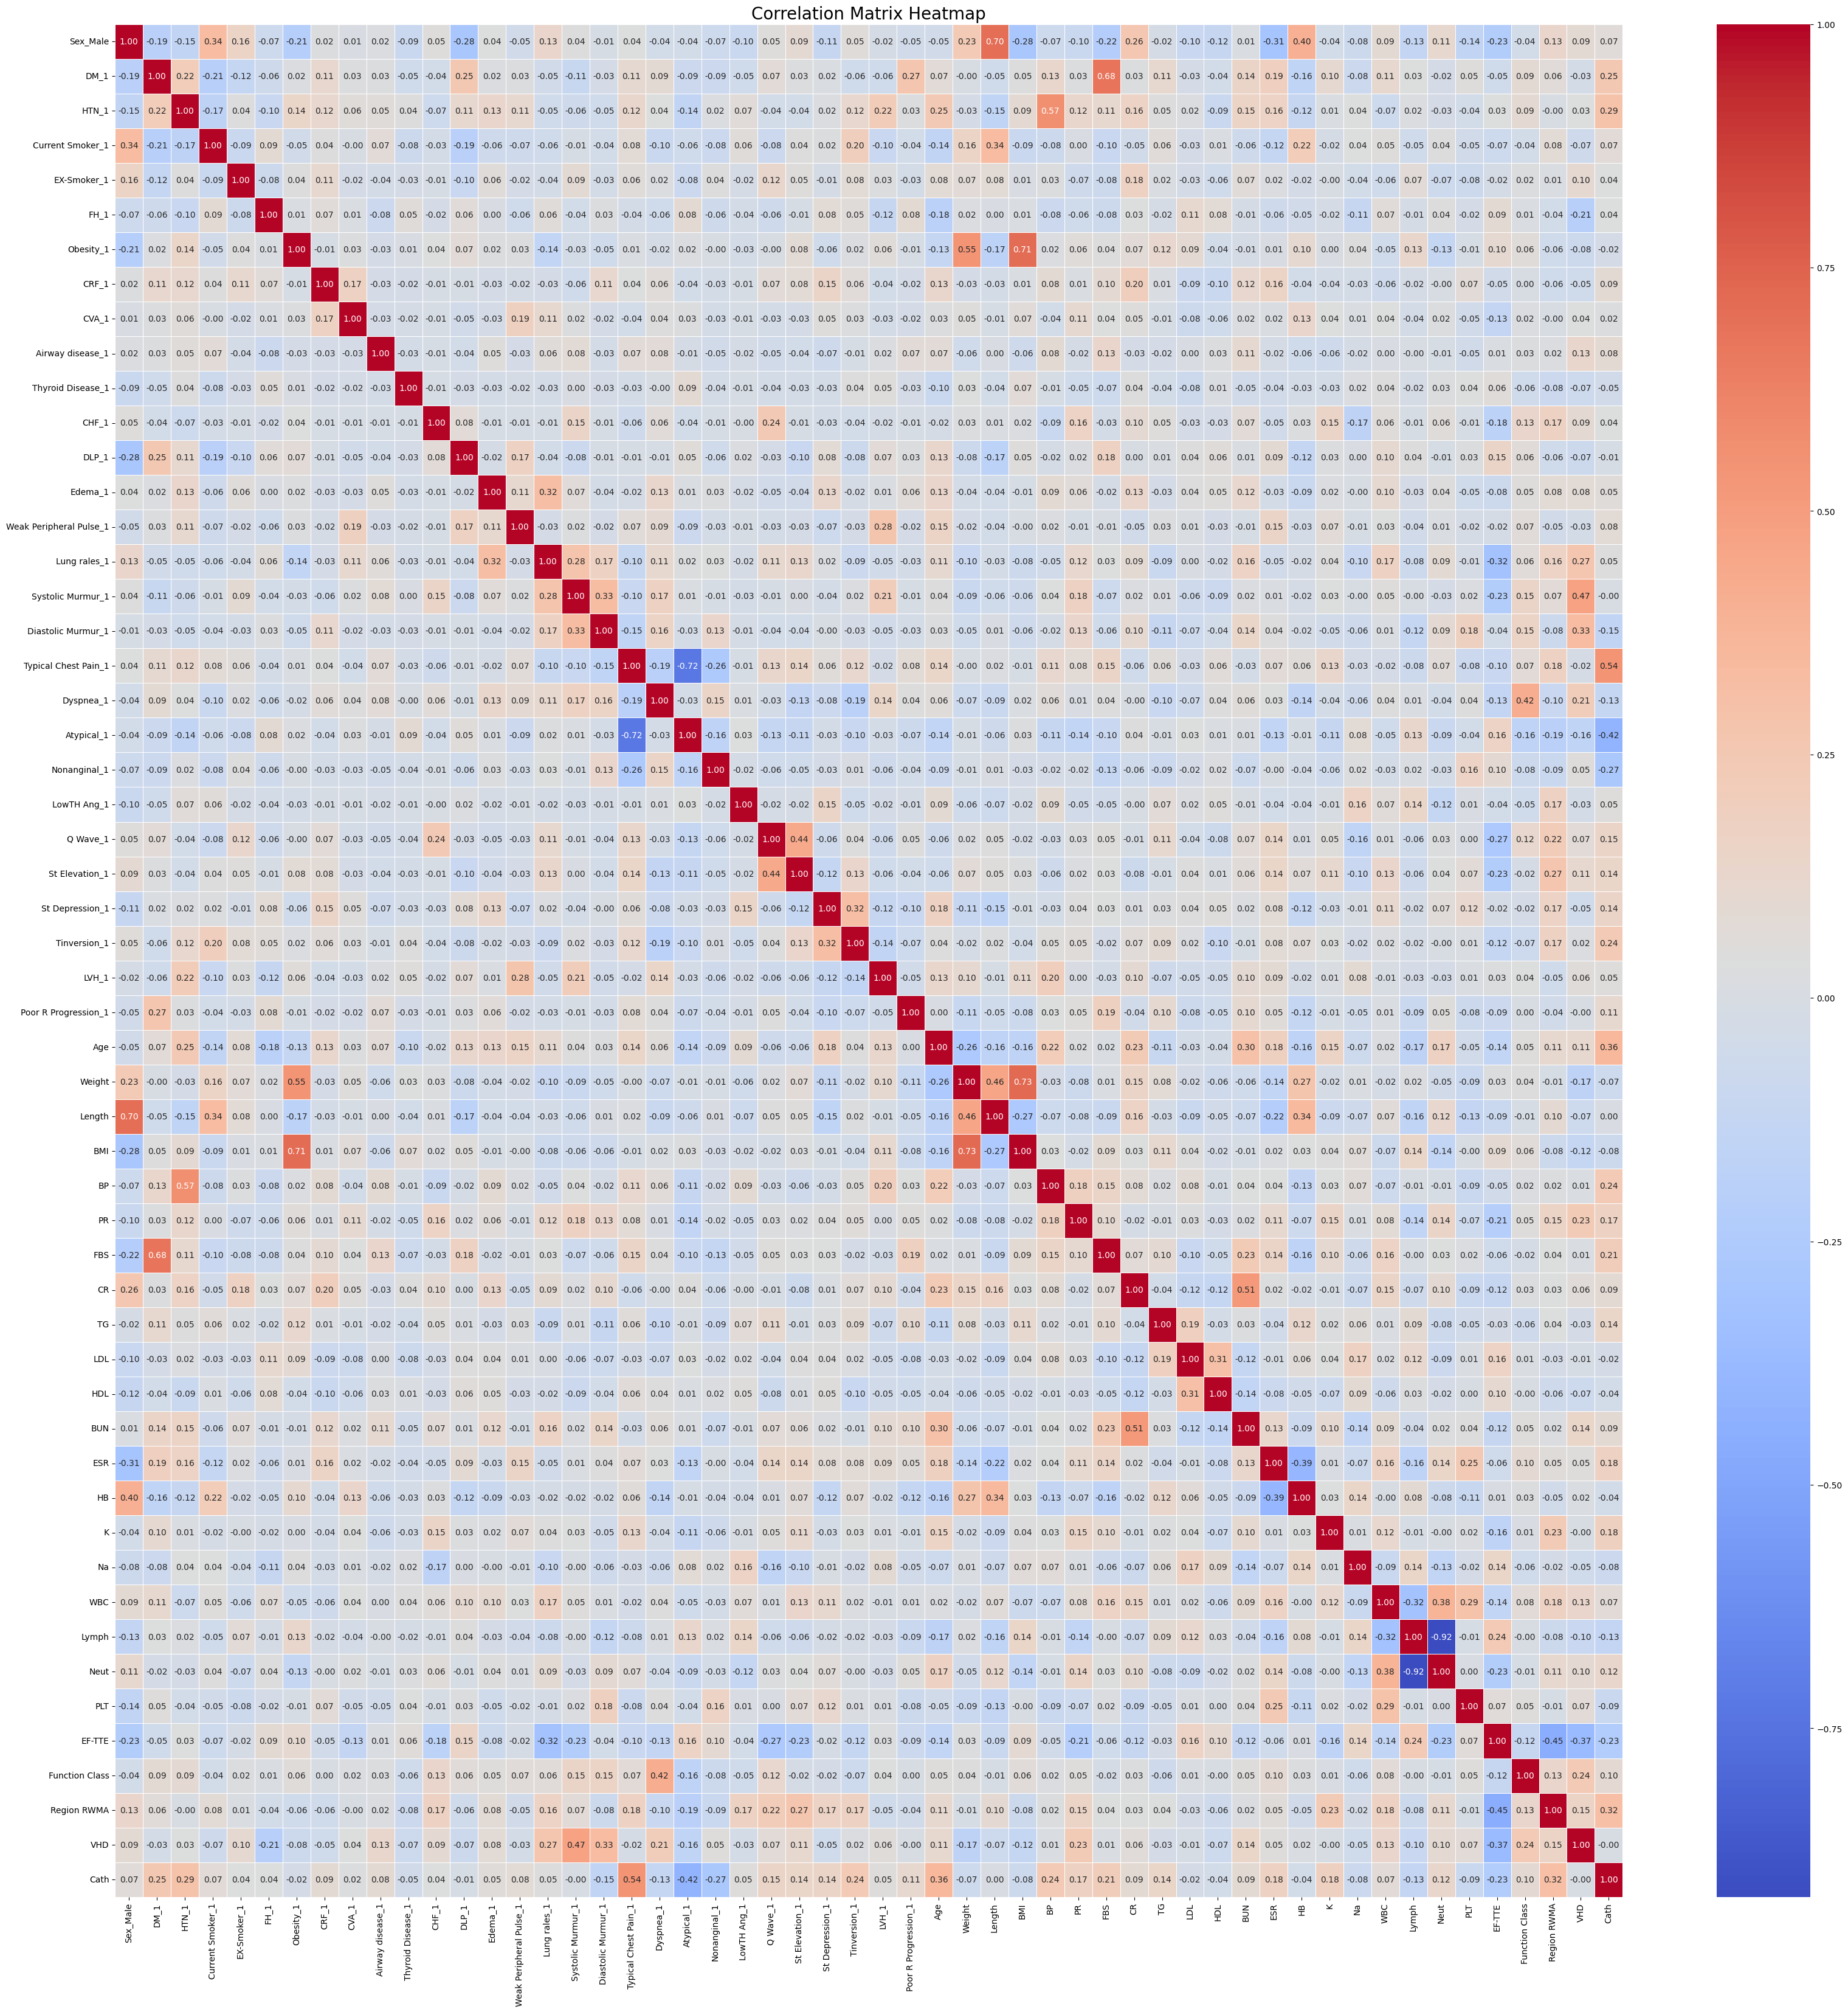

In [41]:
correlation_matrix = processed_df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap", fontsize=20)
plt.show()

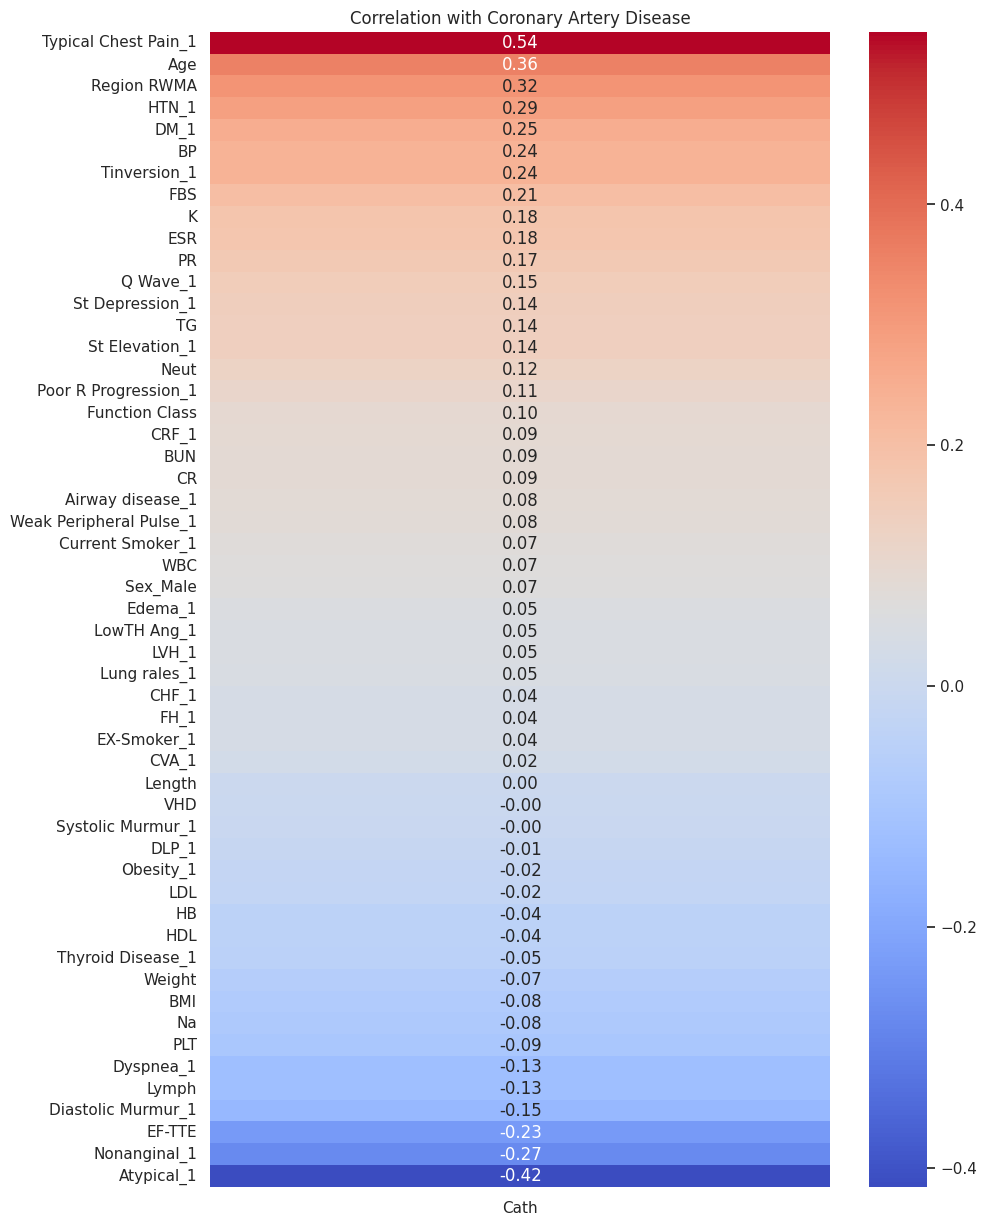

In [42]:
corr = processed_df.corr()
target_corr = corr['Cath'].drop('Cath')

target_corr_sorted = target_corr.sort_values(ascending=False)

plt.figure(figsize=(10,15))
sns.set(font_scale=1.0)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title("Correlation with Coronary Artery Disease")
plt.show()

### ***Positive correlations with Coronary artery disease***

#### 1. Typical chest pain (Typical chest pain_1, 0.54)

#### 2. Age (Age, 0.36)

#### 3. Regional Wall Motion Abnormality (Region RWMA, 0.32)

#### 4. Hypertension (HTN_1, 0.29)

#### 5. Diabetes (DM_1, 0.25)

#### 6. Blood Pressure (BP, 0.24)

#### 7. T inversion (Tinversion_1, 0.24)

### ***Negative correlations with Coronary artery disease***

#### 1. Atypical chest pain (Atypical_1, -0.42)

#### 2. Nonanginal chest pain (Nonanginal_1, -0.27)

#### 3. Ejection fraction (EF_TTE, -0.23)

#### 4. Diastolic murmur (Diastolic murmur_1, -0.15)

#### 5. Lymphocyte to WBC ratio (Lymph, -0.13)

#### 6. Dyspnea (Dyspnea_1, -0.13)


# 2.6 - Mutual Information

Mutual Information between two random variables is a non-negative value, which **measures the dependency between the variables**. It is equal to zero if and only if two random variables are independent, and **higher values mean higher dependency**.

The function relies on **nonparametric methods based on entropy estimation from k-nearest neighbors distances**. And It can be used for **feature selection**.

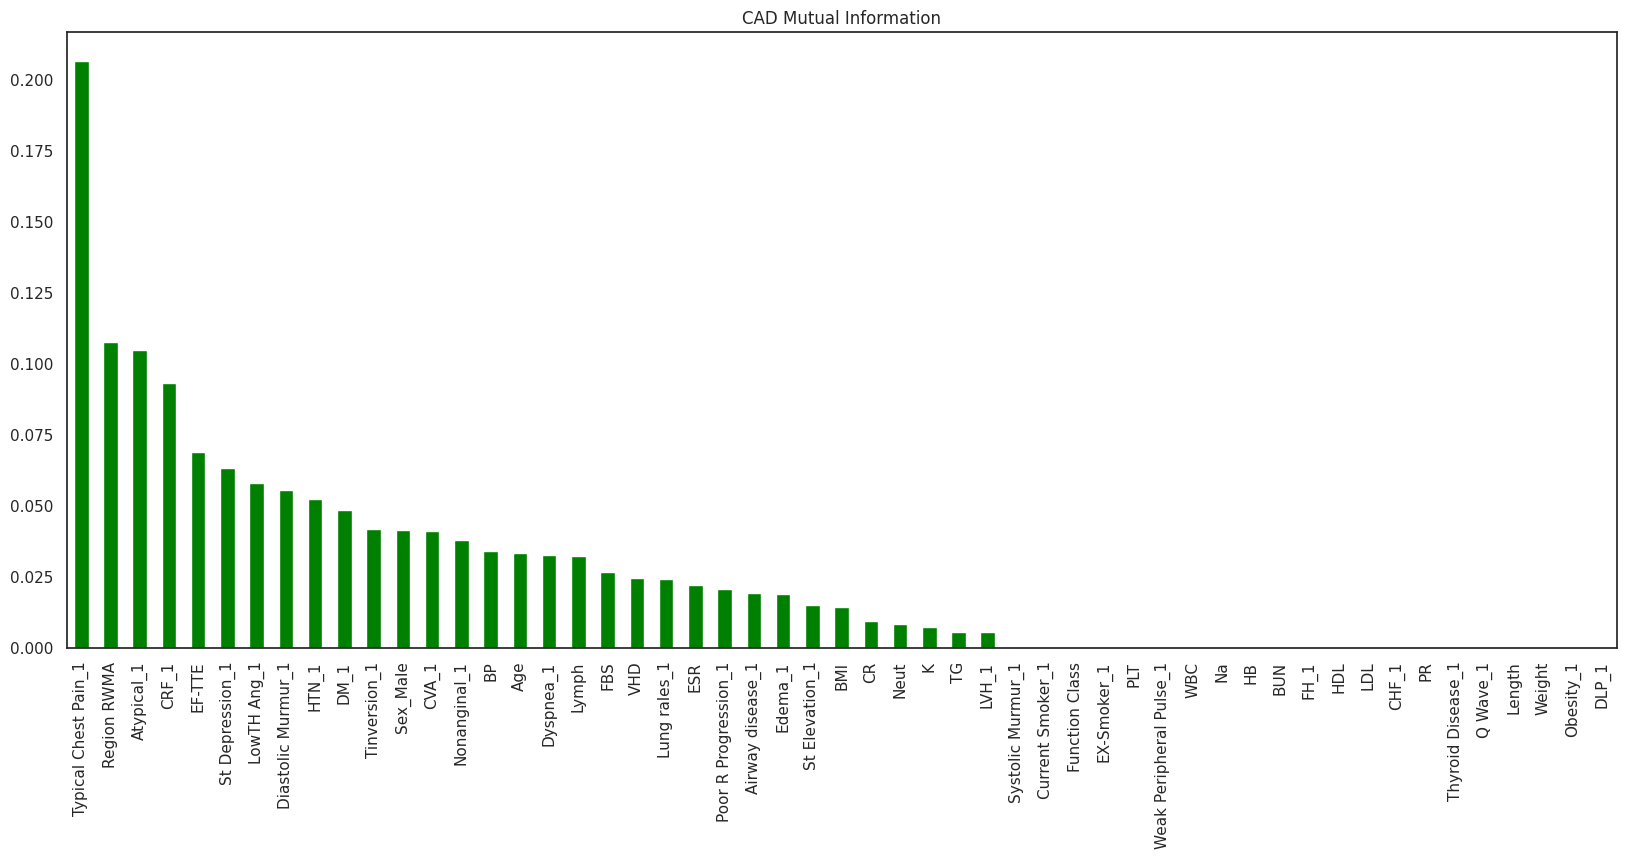

In [43]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

mutual_info = mutual_info_classif(processed_df.drop(['Cath'], axis=1), processed_df['Cath'], random_state=seed)
mutual_info = pd.Series(mutual_info)
mutual_info.index = processed_df.drop(['Cath'], axis=1).columns
columns = mutual_info.sort_values(ascending=False)
columns.plot.bar(title='CAD Mutual Information', figsize=(20, 8), color="green")
plt.show()

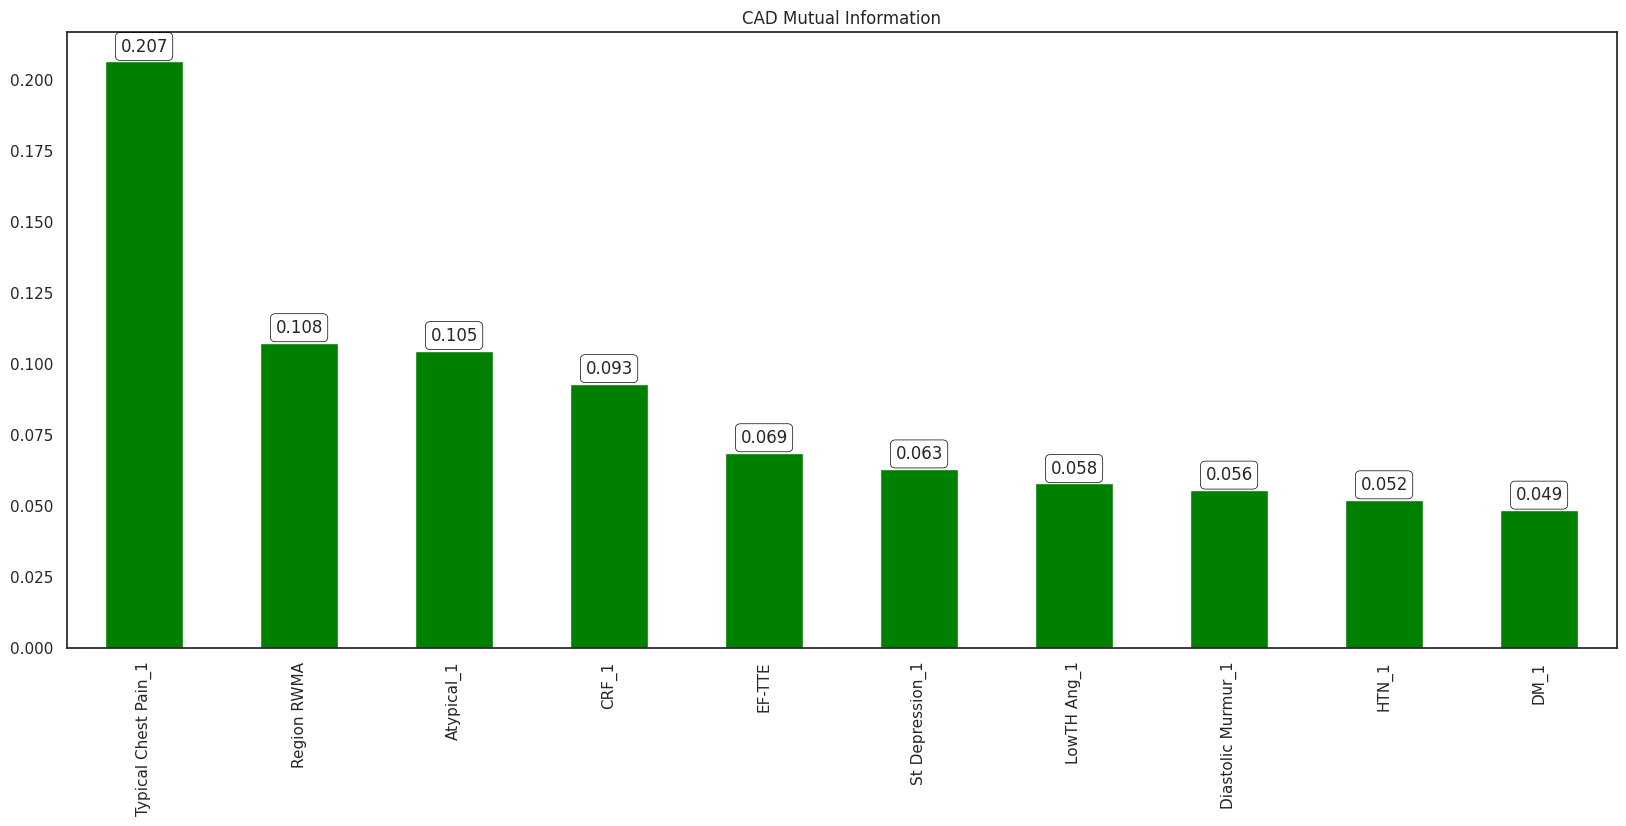

In [44]:
columns = mutual_info.sort_values(ascending=False)[:10]
ax = columns.plot.bar(title='CAD Mutual Information', figsize=(20, 8), color="green")
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., height+0.0035, "{:1.3f}".format(height), ha='center', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

plt.show()

### ***Top 10 Mutual information with CAD***

#### 1. Typical Chest Pain (Typical Chest Pain_1, 0.207)

#### 2. Regional Wall Motion Abnormality (Region RWMA, 0.108)

#### 3. Atypical Chest Pain (Atypical_1, 0.105)

#### 4. Chronic Renal Failure (CRF_1, 0.093)

#### 5. Ejection Fraction (EF_TTE, 0.069)

#### 6. ST Depression (St Depression_1, 0.063)

#### 7. Low Threshold Angina (LowTH Ang_1, 0.058)

#### 8. Diastolic Murmur (Diastolic Murmur_1, 0.056)

#### 9. Hypertension (HTN_1, 0.052)

#### 10. Diabetes (DM_1, 0.049)

# **3 - Predictive Analysis**

# 3.1 - Introduction

In ***Predictive Analysis*** part, we will preprocess the data, and split the data into training set and test set. And we will oversample the data by `SMOTENC`, and develop predictive models with hyperparameter tuning by `Optuna`.  

 Since hyperparameter tuning process takes a comparatively long time, I made variable `optuna_switch`, which is initally set to `False`. If you want to tune the hyperparameter of the models, just change `optuna_switch = False` into `optuna_switch = True`. Then optuna will tune the hyperparameter of the three models, which are `CatBoost`, `XGBoost`, and `LightGBM`.

 We will build six models, `CatBoost`, `XGBoost`, `LightGBM`, and three *Ensemble Models*. Then we will compare these six models with metrics, which are accuracy, precision, recall, F1 score, and roc_auc score. And we will choose one model to analyze explainability in next part.

# 3.2 - Preprocessing

In [45]:
data.head()

Age  Weight  Length     Sex        BMI  DM  HTN  Current Smoker  EX-Smoker  \
0   53      90     175    Male  29.387755   0    1               1          0   
1   67      70     157  Female  28.398718   0    1               0          0   
2   54      54     164    Male  20.077335   0    0               1          0   
3   66      67     158  Female  26.838648   0    1               0          0   
4   50      87     153  Female  37.165193   0    1               0          0   

   FH  ...    K   Na    WBC  Lymph  Neut  PLT  EF-TTE  Region RWMA  VHD  \
0   0  ...  4.7  141   5700     39    52  261      50            0    0   
1   0  ...  4.7  156   7700     38    55  165      40            4    0   
2   0  ...  4.7  139   7400     38    60  230      40            2    1   
3   0  ...  4.4  142  13000     18    72  742      55            0    3   
4   0  ...  4.0  140   9200     55    39  274      50            0    3   

     Cath  
0     Cad  
1     Cad  
2     Cad  
3  Normal  
4  Normal  

[5 rows x 55 columns]

In [46]:
X = data.drop("Cath", axis=1)
y = data['Cath']

In [47]:
map_label = {"Cad":1, "Normal":0}
y = y.map(map_label)

In [48]:
# Numerical variables:
num_cols = ['Age','Weight', 'Length','BMI', 'BP', 'PR', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE']

# Categorical variables:
cat_cols = ['Sex', 'DM', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Edema', 'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur', 'Diastolic Murmur', 'Typical Chest Pain', 'Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'Q Wave', 'St Elevation', 'St Depression', 'Tinversion', 'LVH', 'Poor R Progression', 'Cath']
cat_cols.remove('Cath')

# Ordinal variables
ord_cols = ['Function Class', "Region RWMA", "VHD"]

In [49]:
preprocessor = ColumnTransformer(transformers = [('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first', dtype=np.int64), cat_cols),
                                                 ('Scaler', StandardScaler(), num_cols)],
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False).set_output(transform = 'pandas')
X_prep = preprocessor.fit_transform(X)

In [50]:
X_prep.head()

Sex_Male  DM_1  HTN_1  Current Smoker_1  EX-Smoker_1  FH_1  Obesity_1  \
0         1     0      1                 1            0     0          1   
1         0     0      1                 0            0     0          1   
2         1     0      0                 1            0     0          0   
3         0     0      1                 0            0     0          1   
4         0     0      1                 0            0     0          1   

   CRF_1  CVA_1  Airway disease_1  ...         K        Na       WBC  \
0      0      0                 0  ...  1.025931  0.000868 -0.772712   
1      0      0                 0  ...  1.025931  3.946579  0.057248   
2      0      0                 0  ...  1.025931 -0.525227 -0.067246   
3      0      0                 0  ...  0.370114  0.263916  2.256644   
4      0      0                 0  ... -0.504308 -0.262179  0.679719   

      Lymph      Neut       PLT    EF-TTE  Function Class  Region RWMA  VHD  
0  0.662975 -0.801571  0.650977  0.310686               0            0    0  
1  0.562534 -0.506461 -0.930681 -0.811339               0            4    0  
2  0.562534 -0.014609  0.140233 -0.811339               0            2    1  
3 -1.446280  1.165833  8.575744  0.871699               3            0    3  
4  2.270027 -2.080384  0.865160  0.310686               2            0    3  

[5 rows x 53 columns]

In [51]:
X_prep.columns

Index(['Sex_Male', 'DM_1', 'HTN_1', 'Current Smoker_1', 'EX-Smoker_1', 'FH_1',
       'Obesity_1', 'CRF_1', 'CVA_1', 'Airway disease_1', 'Thyroid Disease_1',
       'CHF_1', 'DLP_1', 'Edema_1', 'Weak Peripheral Pulse_1', 'Lung rales_1',
       'Systolic Murmur_1', 'Diastolic Murmur_1', 'Typical Chest Pain_1',
       'Dyspnea_1', 'Atypical_1', 'Nonanginal_1', 'LowTH Ang_1', 'Q Wave_1',
       'St Elevation_1', 'St Depression_1', 'Tinversion_1', 'LVH_1',
       'Poor R Progression_1', 'Age', 'Weight', 'Length', 'BMI', 'BP', 'PR',
       'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC',
       'Lymph', 'Neut', 'PLT', 'EF-TTE', 'Function Class', 'Region RWMA',
       'VHD'],
      dtype='object')

# 3.3 - Train Test Split

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, stratify=y, random_state=seed)
X_train_en, y_train_en = X_train, y_train

print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (242, 53) (242,)
Test Data Shape :  (61, 53) (61,)


# 3.4 - Oversampling by SMOTENC

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)
print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Validation Data Shape : ", X_valid.shape, y_valid.shape)

Training Data Shape :  (193, 53) (193,)
Validation Data Shape :  (49, 53) (49,)


In [54]:

from imblearn.over_sampling import SMOTENC

catord_cols = ['Sex_Male', 'DM_1', 'HTN_1', 'Current Smoker_1', 'EX-Smoker_1', 'FH_1', 'Obesity_1', 'CRF_1', 'CVA_1', 'Airway disease_1', 'Thyroid Disease_1', 'CHF_1', 'DLP_1', 'Edema_1', 'Weak Peripheral Pulse_1', 'Lung rales_1', 'Systolic Murmur_1', 'Diastolic Murmur_1', 'Typical Chest Pain_1', 'Dyspnea_1', 'Atypical_1', 'Nonanginal_1', 'LowTH Ang_1', 'Q Wave_1', 'St Elevation_1', 'St Depression_1', 'Tinversion_1', 'LVH_1', 'Poor R Progression_1', 'Function Class', "Region RWMA", "VHD"]
oversample = SMOTENC(random_state=seed, categorical_features=catord_cols)
print("Original Train Data : ", X_train.shape, y_train.shape)

X_smote, y_smote = oversample.fit_resample(X_train, y_train)
print("Smote Train Data : ", X_smote.shape, y_smote.shape)


Original Train Data :  (193, 53) (193,)
Smote Train Data :  (276, 53) (276,)


In [55]:
X_smote.columns

Index(['Sex_Male', 'DM_1', 'HTN_1', 'Current Smoker_1', 'EX-Smoker_1', 'FH_1',
       'Obesity_1', 'CRF_1', 'CVA_1', 'Airway disease_1', 'Thyroid Disease_1',
       'CHF_1', 'DLP_1', 'Edema_1', 'Weak Peripheral Pulse_1', 'Lung rales_1',
       'Systolic Murmur_1', 'Diastolic Murmur_1', 'Typical Chest Pain_1',
       'Dyspnea_1', 'Atypical_1', 'Nonanginal_1', 'LowTH Ang_1', 'Q Wave_1',
       'St Elevation_1', 'St Depression_1', 'Tinversion_1', 'LVH_1',
       'Poor R Progression_1', 'Age', 'Weight', 'Length', 'BMI', 'BP', 'PR',
       'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC',
       'Lymph', 'Neut', 'PLT', 'EF-TTE', 'Function Class', 'Region RWMA',
       'VHD'],
      dtype='object')

In [56]:
# Numerical variables:
num_cols = ['Age','Weight', 'Length','BMI', 'BP', 'PR', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE']

# Categorical variables:
cat_cols_ = ['Sex_Male', 'DM_1', 'HTN_1', 'Current Smoker_1', 'EX-Smoker_1', 'FH_1', 'Obesity_1', 'CRF_1', 'CVA_1', 'Airway disease_1', 'Thyroid Disease_1', 'CHF_1', 'DLP_1', 'Edema_1', 'Weak Peripheral Pulse_1', 'Lung rales_1', 'Systolic Murmur_1', 'Diastolic Murmur_1', 'Typical Chest Pain_1', 'Dyspnea_1', 'Atypical_1', 'Nonanginal_1', 'LowTH Ang_1', 'Q Wave_1', 'St Elevation_1', 'St Depression_1', 'Tinversion_1', 'LVH_1', 'Poor R Progression_1']

# Ordinal variables
ord_cols = ['Function Class', "Region RWMA", "VHD"]

print(f"[Unique Values in {len(cat_cols)} Categorical Variables]\n")

for cat_col in cat_cols_:
    print("* {} : {} Unique Values =>".format(cat_col, X_smote[cat_col].nunique()), X_smote[cat_col].unique())

[Unique Values in 30 Categorical Variables]

* Sex_Male : 2 Unique Values => [1 0]
* DM_1 : 2 Unique Values => [0 1]
* HTN_1 : 2 Unique Values => [1 0]
* Current Smoker_1 : 2 Unique Values => [0 1]
* EX-Smoker_1 : 2 Unique Values => [0 1]
* FH_1 : 2 Unique Values => [0 1]
* Obesity_1 : 2 Unique Values => [1 0]
* CRF_1 : 2 Unique Values => [0 1]
* CVA_1 : 2 Unique Values => [0 1]
* Airway disease_1 : 2 Unique Values => [0 1]
* Thyroid Disease_1 : 2 Unique Values => [0 1]
* CHF_1 : 1 Unique Values => [0]
* DLP_1 : 2 Unique Values => [1 0]
* Edema_1 : 2 Unique Values => [0 1]
* Weak Peripheral Pulse_1 : 2 Unique Values => [0 1]
* Lung rales_1 : 2 Unique Values => [0 1]
* Systolic Murmur_1 : 2 Unique Values => [0 1]
* Diastolic Murmur_1 : 2 Unique Values => [0 1]
* Typical Chest Pain_1 : 2 Unique Values => [0 1]
* Dyspnea_1 : 2 Unique Values => [0 1]
* Atypical_1 : 2 Unique Values => [1 0]
* Nonanginal_1 : 2 Unique Values => [0 1]
* LowTH Ang_1 : 2 Unique Values => [0 1]
* Q Wave_1 : 2 Uni

In [57]:
for ord_col in ord_cols:
    print("* {} : {} Unique Values =>".format(ord_col, X_smote[ord_col].nunique()), X_smote[ord_col].unique())

* Function Class : 4 Unique Values => [0 2 3 1]
* Region RWMA : 5 Unique Values => [0 2 3 1 4]
* VHD : 4 Unique Values => [0 1 3 2]


# ***Optuna Switch***

Since hyperparameter tuning process takes a comparatively long time, I made variable `optuna_switch`, which is initally set to `False`. If you want to tune the hyperparameter of the models, just change `optuna_switch = False` into `optuna_switch = True`. Then optuna will tune the hyperparameter of the three models, which are `CatBoost`, `XGBoost`, and `LightGBM`.

In [58]:
optuna_switch = False

# 3.5 - CatBoost

## Hyperparameter tuning by Optuna

In [59]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


In [60]:
import optuna
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [61]:
def objective(trial):

    params = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'od_wait':trial.suggest_int('od_wait', 500, 2000),
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose': False,
    }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)


    catord_cols = ['Sex_Male', 'DM_1', 'HTN_1', 'Current Smoker_1', 'EX-Smoker_1', 'FH_1', 'Obesity_1', 'CRF_1', 'CVA_1', 'Airway disease_1', 'Thyroid Disease_1', 'CHF_1', 'DLP_1', 'Edema_1', 'Weak Peripheral Pulse_1', 'Lung rales_1', 'Systolic Murmur_1', 'Diastolic Murmur_1', 'Typical Chest Pain_1', 'Dyspnea_1', 'Atypical_1', 'Nonanginal_1', 'LowTH Ang_1', 'Q Wave_1', 'St Elevation_1', 'St Depression_1', 'Tinversion_1', 'LVH_1', 'Poor R Progression_1', 'Function Class', "Region RWMA", "VHD"]
    model = CatBoostClassifier(**params)
    cat_model = model.fit(X_train, y_train, cat_features=catord_cols, eval_set=[(X_valid, y_valid)], use_best_model=True)

    pred = cat_model.predict(X_valid)
    #pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
    score = f1_score(y_valid, pred)
    #score = accuracy_score(y_valid, pred)
    #score = precision_score(y_valid, pred)
    #score = recall_score(y_valid, pred)
    #score = roc_auc_score(y_valid, pred_proba)

    return score

In [62]:
if optuna_switch == True:
    study_cb = optuna.create_study(direction='maximize')
    study_cb.optimize(objective, n_trials = 50, show_progress_bar=True)

In [63]:
if optuna_switch == True:
    print("Best Hyperparameters: ", study_cb.best_params)
    print("Best F1 Score: ", study_cb.best_value)

## Training Model

In [64]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label="ROC", color='green', linestyle='dashed', linewidth=4)
    plt.plot([0,1], [0,1], "k-", label="Random", linestyle='dashed', color='gray', linewidth=3)


    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("FPR( 1 - Specificity )")
    plt.ylabel("TPR( Recall )")
    plt.legend()

In [65]:
def get_clf_eval(y_test, pred, pred_proba):

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
    disp.plot()
    plt.show()

    roc_curve_plot(y_test, pred_proba)

    eval_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

    return eval_metrics

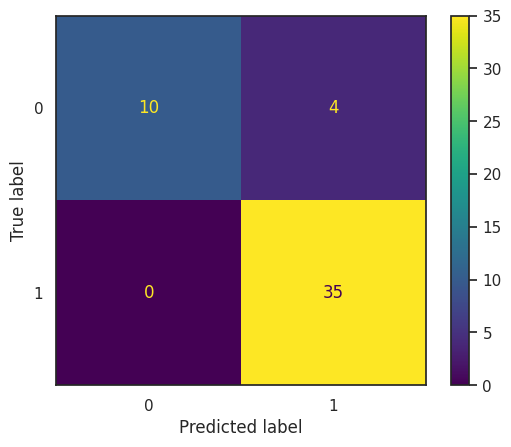

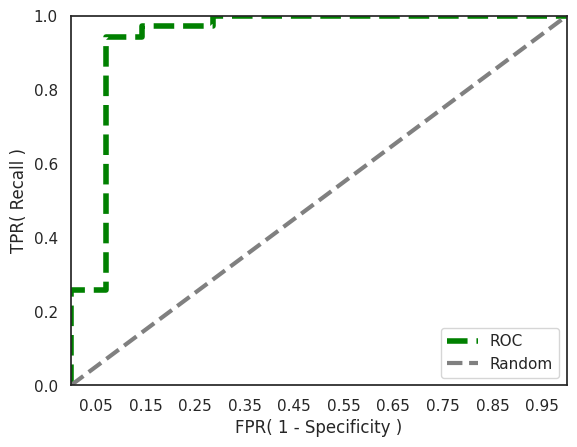

In [66]:
catord_cols = ['Sex_Male', 'DM_1', 'HTN_1', 'Current Smoker_1', 'EX-Smoker_1', 'FH_1', 'Obesity_1', 'CRF_1', 'CVA_1', 'Airway disease_1', 'Thyroid Disease_1', 'CHF_1', 'DLP_1', 'Edema_1', 'Weak Peripheral Pulse_1', 'Lung rales_1', 'Systolic Murmur_1', 'Diastolic Murmur_1', 'Typical Chest Pain_1', 'Dyspnea_1', 'Atypical_1', 'Nonanginal_1', 'LowTH Ang_1', 'Q Wave_1', 'St Elevation_1', 'St Depression_1', 'Tinversion_1', 'LVH_1', 'Poor R Progression_1', 'Function Class', "Region RWMA", "VHD"]

if optuna_switch == True:
    cb = CatBoostClassifier(random_state=seed, verbose=0, **study_cb.best_params)
else:
    cb = CatBoostClassifier(random_state=seed, verbose=0, iterations = 848, objective = 'CrossEntropy', bootstrap_type = 'Bernoulli', od_wait = 1785, learning_rate = 0.09967519851171666, reg_lambda = 14.530290657887146, random_strength = 48.95669246924815, depth = 4, min_data_in_leaf = 26, leaf_estimation_iterations = 6, subsample = 0.15606746339296185)

cat_model = cb.fit(X_train, y_train, cat_features=catord_cols)

pred = cat_model.predict(X_valid)
pred_proba = cat_model.predict_proba(X_valid)[:, 1]
metrics_train_cb = get_clf_eval(y_valid.values, pred, pred_proba)

In [67]:
!pip install ipykernel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [73]:
!pip install nbformat


In [74]:
print(metrics_train_cb)


{'accuracy': 0.9183673469387755, 'precision': 0.8974358974358975, 'recall': 1.0, 'f1': 0.9459459459459459, 'roc_auc': 0.9387755102040816}


In [75]:
import plotly.graph_objects as go

# Your metrics dictionary
metrics_train_cb = {
    'accuracy': 0.9183673469387755,
    'precision': 0.8974358974358975,
    'recall': 1.0,
    'f1': 0.9459459459459459,
    'roc_auc': 0.9387755102040816
}

# Create the Plotly Figure
fig = go.Figure()

# Add the table trace
fig.add_trace(
    go.Table(
        columnwidth=[80, 100],  # Column widths
        header=dict(
            values=['Metrics', 'CatBoost_Train'],  # Header names
            height=50,
            font_size=22,
            align='center',  # Center align the header
            fill_color='lightblue'  # Background color for header
        ),
        cells=dict(
            values=[
                ['Accuracy', 'Precision', 'Recall',
                    'F1 Score', 'ROC_AUC'],  # Metric names
                [
                    round(metrics_train_cb['accuracy'], 3),
                    round(metrics_train_cb['precision'], 3),
                    round(metrics_train_cb['recall'], 3),
                    round(metrics_train_cb['f1'], 3),
                    round(metrics_train_cb['roc_auc'], 3)
                ]  # Rounded metric values
            ],
            height=50,
            font_size=16,
            align='center',  # Center align the cells
            fill_color='white',  # Background color for cells
            line_color='black'  # Border color
        )
    )
)

# Show the plot
fig.show()


## Evaluate the Model

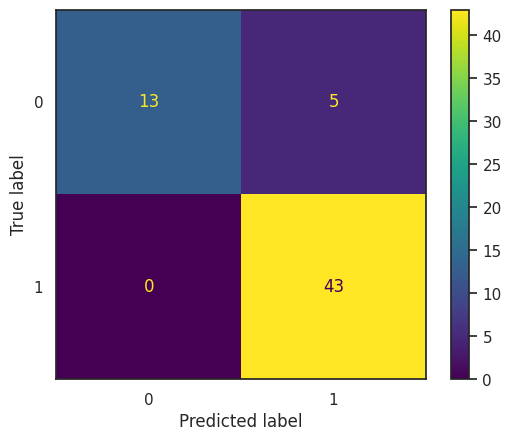

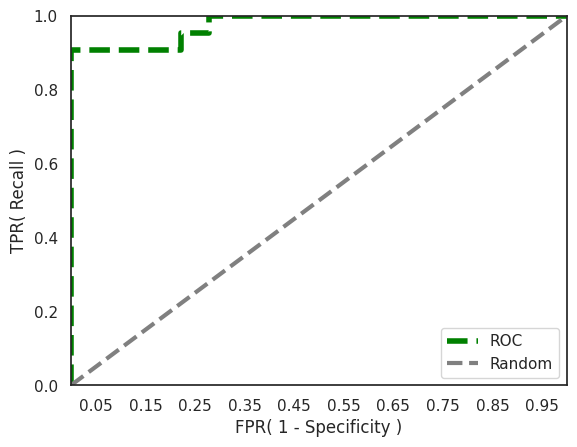

In [76]:
pred = cat_model.predict(X_test)
pred_proba = cat_model.predict_proba(X_test)[:, 1]
metrics_test_cb = get_clf_eval(y_test.values, pred, pred_proba)

In [77]:
# Round each metric value to 3 decimal places before passing them to the table
fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80, 100],
             header=dict(values=['Metrics', 'CatBoost_Test'],
                         height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_test_cb['accuracy'], 3),
                                 round(metrics_test_cb['precision'], 3),
                                 round(metrics_test_cb['recall'], 3),
                                 round(metrics_test_cb['f1'], 3),
                                 round(metrics_test_cb['roc_auc'], 3)]],
                        height=50, font_size=16)))
fig.show()


# 3.6 - XGBoost

In [78]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        'verbosity': 0,
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",
        "booster": "gbtree",
        "random_state" : seed,
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "grow_policy": trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }

    model = XGBClassifier(**params)
    xgb_model = model.fit(X_train, y_train)

    pred = xgb_model.predict(X_valid)
    pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
    score = f1_score(y_valid, pred)
    #score = accuracy_score(y_valid, pred)
    #score = precision_score(y_valid, pred)
    #score = recall_score(y_valid, pred)
    #score = roc_auc_score(y_valid, pred_proba)

    return score

## Training Model

In [79]:
if optuna_switch == True:
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective, n_trials = 50, show_progress_bar=True)

In [80]:
if optuna_switch == True:
    print("Best Hyperparameters: ", study_xgb.best_params)
    print("Best F1 Score: ", study_xgb.best_value)

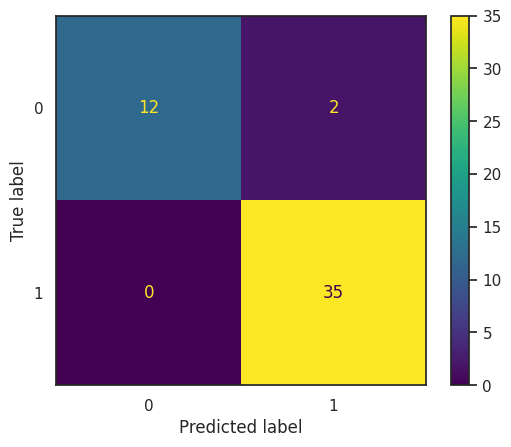

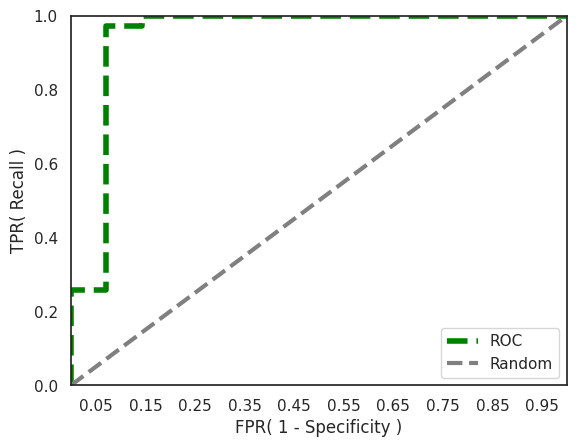

In [81]:
if optuna_switch == True:
    xgb = XGBClassifier(random_state=seed, **study_xgb.best_params)
else:
    xgb = XGBClassifier(random_state=seed, max_depth = 4, subsample = 0.8455445119537031, colsample_bytree = 0.7473353578505076, learning_rate = 0.2343253699229094, min_child_weight = 1, gamma = 0.3290797801781987, reg_alpha = 1.0280651442885607, reg_lambda = 2.990770634501404, n_estimators = 2450, scale_pos_weight = 1.1196755081865422, grow_policy = 'lossguide')

xgb_model = xgb.fit(X_train, y_train)

pred = xgb_model.predict(X_valid)
pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
metrics_train_xgb = get_clf_eval(y_valid.values, pred, pred_proba)

In [84]:
# metrics_train_xgb

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'XGBoost_Train'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_train_xgb['accuracy'], 3), round(metrics_train_xgb['precision'], 3), round(metrics_train_xgb['recall'], 3), round(metrics_train_xgb['f1'], 3), round(metrics_train_xgb['roc_auc'], 3)]], height=50, font_size=16)))

fig.show()

## Evaluate the Model

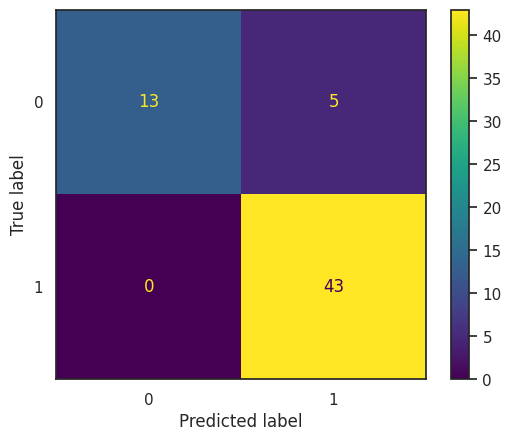

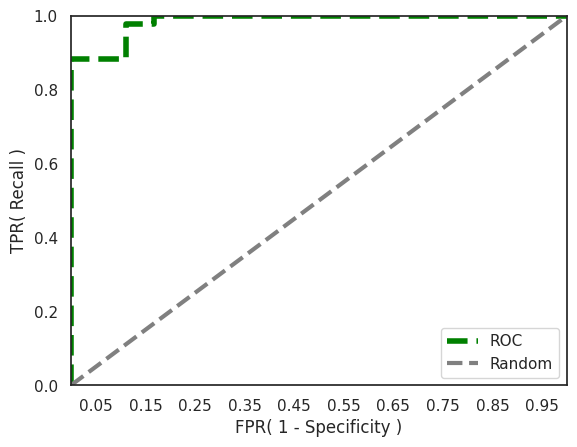

In [85]:
pred = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:, 1]
metrics_test_xgb = get_clf_eval(y_test.values, pred, pred_proba)

In [87]:
# metrics_test_xgb
fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'XGBoost_Test'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_test_xgb['accuracy'], 3), round(metrics_test_xgb['precision'], 3), round(metrics_test_xgb['recall'], 3), round(metrics_test_xgb['f1'], 3), round(metrics_test_xgb['roc_auc'], 3)]], height=50, font_size=16)))

fig.show()

# 3.7 - LightGBM

In [88]:
def objective(trial):
    params = {
        "verbose": -1,
        "random_state": seed,
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "force_col_wise": True
    }

    model = LGBMClassifier(**params)
    lgb_model = model.fit(X_train, y_train)

    pred = lgb_model.predict(X_valid)
    pred_proba = xgb_model.predict_proba(X_valid)[:, 1]

    score = f1_score(y_valid, pred)
    #score = accuracy_score(y_valid, pred)
    #score = precision_score(y_valid, pred)
    #score = recall_score(y_valid, pred)
    #score = roc_auc_score(y_valid, pred_proba)

    return score

## Training Model

In [89]:
if optuna_switch == True:
    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(objective, n_trials = 50, show_progress_bar=True)

In [90]:
if optuna_switch == True:
    print("Best Hyperparameters: ", study_lgb.best_params)
    print("Best F1 Score: ", study_lgb.best_value)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 138, number of negative: 55
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 193, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715026 -> initscore=0.919920
[LightGBM] [Info] Start training from score 0.919920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

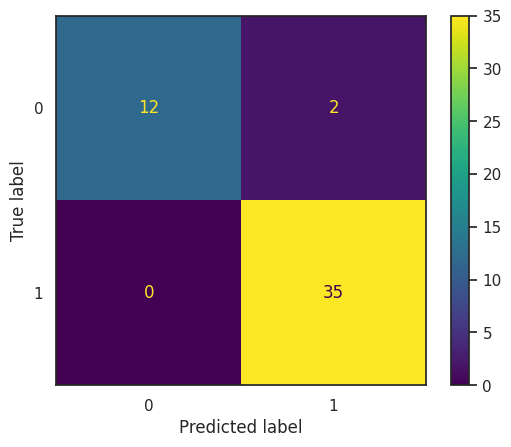

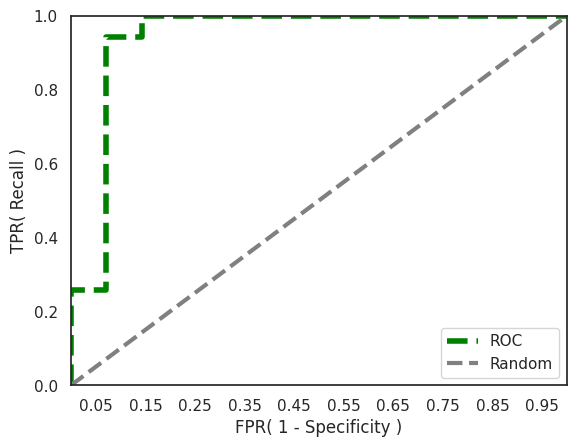

In [91]:
if optuna_switch == True:
    lgb = LGBMClassifier(random_state=seed, **study_lgb.best_params)
else:
    lgb = LGBMClassifier(random_state=seed, max_depth=8, subsample=0.7685741440530103, colsample_bytree=0.33159946082189473, learning_rate = 0.262816149189883, min_child_weight = 7, reg_alpha = 2.4513434563232432, reg_lambda=2.758468600865858, n_estimators=1800, scale_pos_weight=1.0020536704974063)

lgb_model = lgb.fit(X_train, y_train)

pred = lgb_model.predict(X_valid)
pred_proba = lgb_model.predict_proba(X_valid)[:, 1]
metrics_train_lgb = get_clf_eval(y_valid.values, pred, pred_proba)

In [93]:
# metrics_train_lgb

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'LightGBM_Train'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_train_lgb['accuracy'], 3), round(metrics_train_lgb['precision'], 3), round(metrics_train_lgb['recall'], 3), round(metrics_train_lgb['f1'], 3), round(metrics_train_lgb['roc_auc'], 3)]], height=50, font_size=16)))

fig.show()

In [94]:
!pip install --upgrade ipywidgets
fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80, 100],
             header=dict(values=['Metrics', 'LightGBM_Train'],
                         height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_train_lgb['accuracy'], 3),
                                 round(metrics_train_lgb['precision'], 3),
                                 round(metrics_train_lgb['recall'], 3),
                                 round(metrics_train_lgb['f1'], 3),
                                 round(metrics_train_lgb['roc_auc'], 3)]],
                        height=50, font_size=16)))
fig.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Evaluate the Model

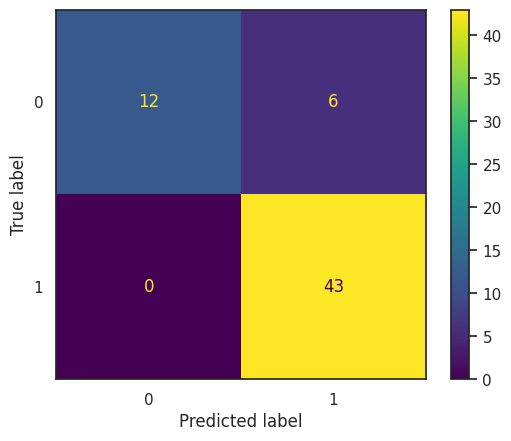

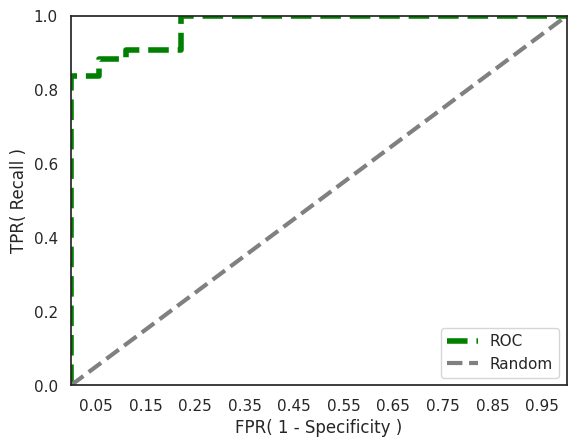

In [95]:
pred = lgb_model.predict(X_test)
pred_proba = lgb_model.predict_proba(X_test)[:, 1]
metrics_test_lgb = get_clf_eval(y_test.values, pred, pred_proba)

In [97]:
# metrics_test_lgb

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'LightGBM_Test'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_test_lgb['accuracy'], 3), round(metrics_test_lgb['precision'], 3), round(metrics_test_lgb['recall'], 3), round(metrics_test_lgb['f1'], 3), round(metrics_test_lgb['roc_auc'], 3)]], height=50, font_size=16)))

fig.show()

# 3.8 - Ensemble

We will build three *Ensemble Models*:

***Ensemble1***
- *Stacking (AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, Logistic Regression, CatBoost, XGBoost, LightGBM) + Logistic Regression*

***Ensemble2***
- *StratifiedKFold + Stacking (CatBoost, XGBoost, LightGBM)*

***Ensemble3***
- *Stacking (AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, Logistic Regression, CatBoost, XGBoost, LightGBM) + LogisticRegression + VotingClassifier*

## ***Ensemble1***

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV

In [99]:
ABC = AdaBoostClassifier(random_state=seed)
BAG = BaggingClassifier(random_state=seed)
DTC = DecisionTreeClassifier(random_state=seed)
GB = GradientBoostingClassifier(random_state=seed)
LR = LogisticRegression(random_state=seed)
NB = GaussianNB()
RC = RidgeClassifier(random_state=seed)
RCC = RidgeClassifierCV()
RF = RandomForestClassifier(random_state=seed)
SVM_RBF = SVC(random_state=seed)

lr_final = LogisticRegression(random_state=seed)

In [100]:
oversample = SMOTENC(random_state=seed, categorical_features=catord_cols)
X_train_en1, y_train_en1 = oversample.fit_resample(X_train_en, y_train_en)

ABC.fit(X_train_en1, y_train_en1)
BAG.fit(X_train_en1, y_train_en1)
RF.fit(X_train_en1, y_train_en1)
LR.fit(X_train_en1, y_train_en1)

cat_model.fit(X_train_en1, y_train_en1, cat_features=catord_cols)
xgb_model.fit(X_train_en1, y_train_en1)
lgb_model.fit(X_train_en1, y_train_en1)

ABC_pred = ABC.predict(X_test)
BAG_pred = BAG.predict(X_test)
RF_pred = RF.predict(X_test)
LR_pred = LR.predict(X_test)

cat_pred = cat_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 173, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1393
[LightGBM] [Info] Number of data points in the train set: 346, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [101]:
en_pred = np.array([ABC_pred, BAG_pred, RF_pred, LR_pred, cat_pred, xgb_pred, lgb_pred])
en_pred.shape

(7, 61)

In [102]:
en_pred = np.transpose(en_pred)
en_pred.shape

(61, 7)

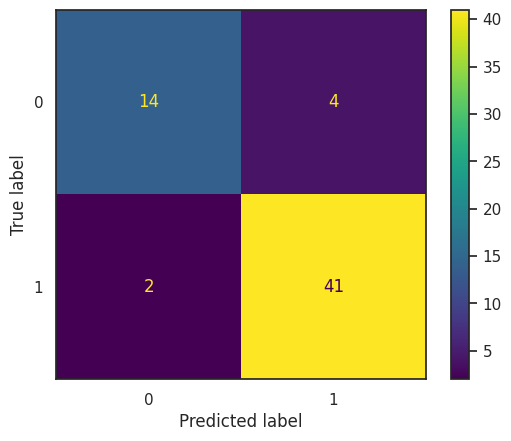

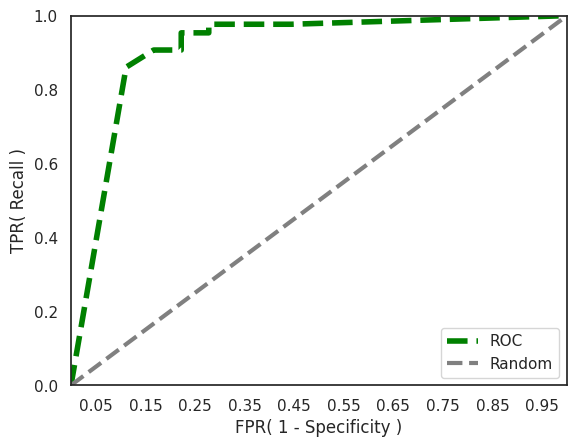

In [103]:
lr_final.fit(en_pred, y_test)
final = lr_final.predict(en_pred)
pred_proba = lr_final.predict_proba(en_pred)[:,1]
metrics_test_en1 = get_clf_eval(y_test.values, final, pred_proba)

In [105]:
# metrics_test_en1

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'Ensemble1_Test'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_test_en1['accuracy'], 3), round(metrics_test_en1['precision'], 3), round(metrics_test_en1['recall'], 3), round(metrics_test_en1['f1'], 3), round(metrics_test_en1['roc_auc'], 3)]], height=50, font_size=16)))

fig.show()

## ***Ensemble2***

In [106]:
from sklearn.model_selection import StratifiedKFold, KFold

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):

    skf = StratifiedKFold(n_splits = n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    Xy_concat = pd.concat([X_train_n, pd.DataFrame(data=y_train_n, columns=['Cath'])], axis=1)

    for i, (train_index, valid_index) in enumerate(skf.split(Xy_concat, Xy_concat['Cath'])):
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]

        oversample = SMOTENC(random_state=seed, categorical_features=catord_cols)
        X_tr, y_tr = oversample.fit_resample(X_tr, y_tr)

        X_te = X_train_n.iloc[valid_index]

        model.fit(X_tr, y_tr)

        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)

        test_pred[:, i] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean

In [107]:
cat_train, cat_test = get_stacking_base_datasets(cat_model, X_train_en, y_train_en, X_test, 7)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_model, X_train_en, y_train_en, X_test, 7)
lgb_train, lgb_test = get_stacking_base_datasets(lgb_model, X_train_en, y_train_en, X_test, 7)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

In [111]:
Stack_final_X_train = np.concatenate((cat_train, xgb_train, lgb_train), axis=1)
Stack_final_X_test = np.concatenate((cat_test, xgb_test, lgb_test), axis=1)

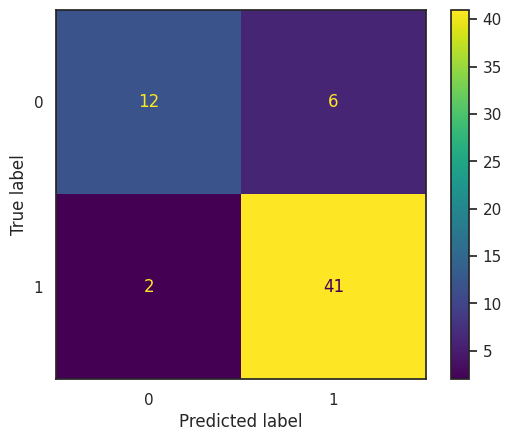

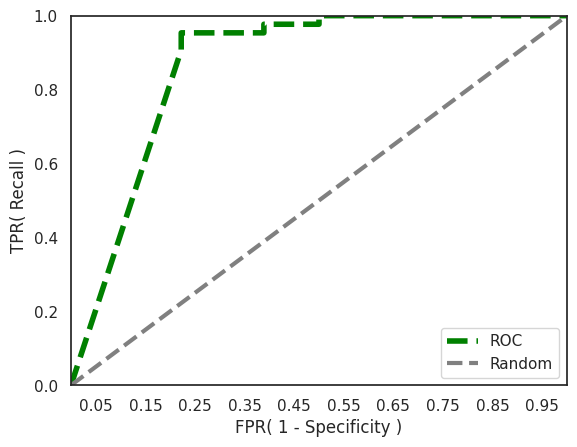

In [112]:
lr_final = LogisticRegression(random_state=seed)
lr_final.fit(Stack_final_X_train, y_train_en)
stack_final = lr_final.predict(Stack_final_X_test)
pred_proba = lr_final.predict_proba(Stack_final_X_test)[:,1]
metrics_test_en2 = get_clf_eval(y_test.values, stack_final, pred_proba)

In [114]:
# metrics_test_en2

fig = go.Figure()
fig.add_trace(
    go.Table(columnwidth=[80,100],
             header=dict(values=['Metrics', 'Ensemble2_Test'], height=50, font_size=22),
             cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'],
                                [round(metrics_test_en2['accuracy'], 3), round(metrics_test_en2['precision'], 3), round(metrics_test_en2['recall'], 3), round(metrics_test_en2['f1'], 3), round(metrics_test_en2['roc_auc'], 3)]], height=50, font_size=16)))

fig.show()

## ***Ensemble3***

In [115]:
score_list = pd.DataFrame()

#oversample = SMOTENC(random_state=seed, categorical_features=catord_cols)
#X_train_en3, y_train_en3 = oversample.fit_resample(X_train_en, y_train_en)

pred_cat = cat_model.predict_proba(X_valid)
pred_cat = [i[1] for i in pred_cat]
score_list['cat'] = pred_cat

pred_xgb = xgb_model.predict_proba(X_valid)
pred_xgb = [i[1] for i in pred_xgb]
score_list['xgb'] = pred_xgb

pred_lgb = lgb_model.predict_proba(X_valid)
pred_lgb = [i[1] for i in pred_lgb]
score_list['lgb'] = pred_lgb

add_model = [ABC, BAG, LR, RF]
add_model_name = ['ABC', 'BAG', 'LR', 'RF']

for addmodel, modelname in zip(add_model, add_model_name):
    x = addmodel.predict_proba(X_valid)
    x = [i[1] for i in x]
    score_list[modelname] = x

In [116]:
score_list.head()

cat       xgb       lgb       ABC  BAG        LR    RF
0  0.004500  0.035909  0.037583  0.380729  0.2  0.073031  0.09
1  0.029370  0.035567  0.075884  0.386219  0.3  0.180974  0.23
2  0.998608  0.990816  0.991540  0.681483  1.0  0.999691  0.96
3  0.026590  0.073631  0.097582  0.440941  0.2  0.106403  0.18
4  0.969308  0.896514  0.869144  0.543395  0.9  0.540740  0.94

In [117]:
from sklearn.ensemble import VotingClassifier

weights = LogisticRegression(random_state=seed).fit(score_list, y_valid).coef_[0]

In [118]:
pd.DataFrame(weights, index = score_list.columns, columns = ['weight per model'])

weight per model
cat          1.014633
xgb          0.917781
lgb          0.764534
ABC          0.259383
BAG          1.337737
LR           0.803956
RF           1.301231

# **4 - Explainable AI using SHAP value**

# 4.1 - Introduction

In [122]:
cat_explainer = shap.TreeExplainer(cat_model, X_train, feature_names = X_train.columns.tolist())
shap_values = cat_explainer.shap_values(X_train, y_train)
shap_values.shape

(193, 53)

In [123]:
pd.DataFrame(shap_values, columns=X_train.columns.tolist()).head()

Sex_Male      DM_1     HTN_1  Current Smoker_1  EX-Smoker_1      FH_1  \
0  0.108810 -0.202689  0.249442         -0.155950     0.000103 -0.092685   
1  0.065907 -0.171970 -0.267807          0.638678    -0.001128  0.345817   
2  0.058804 -0.162011  0.183088         -0.125054     0.001198 -0.072712   
3 -0.086104 -0.184836  0.167304          0.546736    -0.000198 -0.058738   
4 -0.176944 -0.229592 -0.333148         -0.156206    -0.000500 -0.091666   

   Obesity_1  CRF_1     CVA_1  Airway disease_1  ...         K        Na  \
0  -0.032478    0.0 -0.000761         -0.002612  ...  0.397741  0.070525   
1  -0.027606    0.0  0.000272          0.000280  ... -0.165611  0.357405   
2   0.025873    0.0 -0.000353         -0.000319  ... -0.040603  0.319157   
3  -0.026768    0.0 -0.000043          0.001400  ...  0.007749 -0.144417   
4  -0.032031    0.0 -0.000816         -0.002446  ... -0.267338 -0.316849   

        WBC     Lymph      Neut       PLT    EF-TTE  Function Class  \
0  0.031836  0.069242  0.171437 -0.087620  0.352806       -0.163654   
1  0.325698  0.055578  0.257083  0.047436 -0.949866       -0.165761   
2 -0.350679  0.038251  0.058942 -0.023994  0.614515        0.294974   
3 -0.117165 -0.027471 -0.227088 -0.099631 -1.042996       -0.179575   
4  0.074011 -0.095127 -0.135405 -0.281579 -1.089502       -0.175992   

   Region RWMA       VHD  
0    -0.213173  0.364908  
1     0.582508  0.257375  
2     0.469350 -0.176663  
3    -0.148271  0.315275  
4    -0.193007  0.262594  

[5 rows x 53 columns]

In [124]:
pd.DataFrame(pd.DataFrame(shap_values, columns=X_train.columns.tolist()).abs().sum().sort_values(ascending=False), columns=["sum(|SHAP value|)"])

sum(|SHAP value|)
Typical Chest Pain_1            285.846863
EF-TTE                          123.154258
Age                             111.413782
Atypical_1                       79.303390
FBS                              76.644747
TG                               73.169619
ESR                              64.452106
CR                               63.121385
BP                               57.381475
Tinversion_1                     56.073644
DM_1                             51.778712
K                                49.639747
HTN_1                            48.867061
Region RWMA                      48.633823
BUN                              47.019108
VHD                              43.157476
Current Smoker_1                 40.494973
Function Class                   39.320919
Na                               36.512200
WBC                              28.586212
St Depression_1                  28.279959
Weight                           26.680376
Neut                             26.422594
PLT                              25.460834
BMI                              25.099189
FH_1                             24.430697
HB                               23.271191
Nonanginal_1                     21.921261
LDL                              20.624247
HDL                              19.539023
Sex_Male                         16.467729
PR                               15.645109
DLP_1                            15.537528
Length                           14.168555
Lymph                            13.175536
Dyspnea_1                         9.372471
Obesity_1                         5.783516
St Elevation_1                    5.096046
Systolic Murmur_1                 2.373040
Q Wave_1                          1.441594
Thyroid Disease_1                 0.541852
Airway disease_1                  0.471273
Lung rales_1                      0.425261
Weak Peripheral Pulse_1           0.418351
Edema_1                           0.405313
Poor R Progression_1              0.350282
CVA_1                             0.291295
EX-Smoker_1                       0.243209
LVH_1                             0.175548
Diastolic Murmur_1                0.145910
LowTH Ang_1                       0.087372
CRF_1                             0.018243
CHF_1                             0.000000

By calculating `sum(|SHAP values|)`, we can see that which features had more impact on model. `SHAP feature importance plot` is just the average absolute Shapley values for a feature. So value of 0.0000 for `CHF_1` means that `CHF_1` had no effect on the CatBoost model.

# ***Global Interpretability***

# 4.2 - SHAP Feature Importance Plot

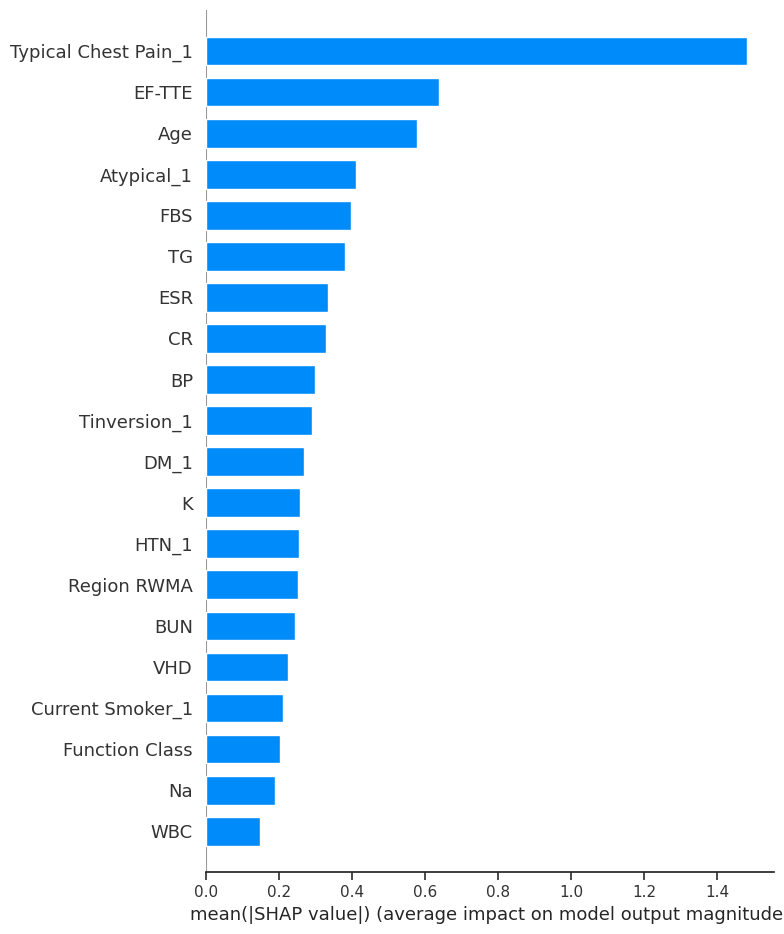

In [125]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")

`Feature Importance Plot` shows the average absolute Shapley values for feature. Top 5 features are:
- `Typical Chest Pain_1`
- `EF-TTE` (Ejection fraction)
- `Age`
- `TG`
- `Atypical_1` (Atypical chest pain)

 # 4.3 - SHAP Beeswarm Plot

Here is how to interpret the below `SHAP Beeswarm Plot`:  [Reference : [(Link)](https://www.kaggle.com/code/bextuychiev/model-explainability-with-shap-only-guide-u-need)]

1) The left vertical axis denotes feature names, ordered based on importance from top to bottom.

2) The horizontal axis represents the magnitude of the SHAP values for predictions.

3) The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points.

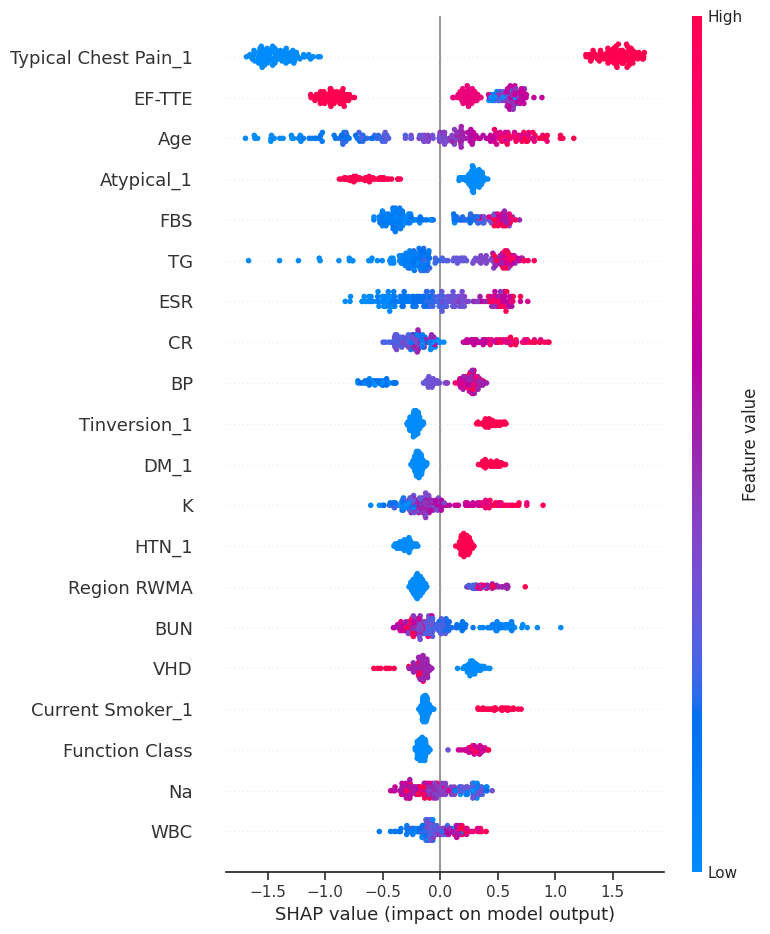

In [126]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

- `Typical Chest Pain`, `HTN_1`, `Tinversion_1`, `DM_1`, `Current Smoker_1`, `ST Depression_1` shows clear positive correlations with target values `CAD`.

- `Atypical_1` shows clear negative correlations with target values `CAD`.

- Other features are a bit tricky with a cluster of mixed points.

# 4.4 - SHAP Dependence Plot

We can get a deeper insight into each feature's effect on the entire dataset with dependence plots.

## Numerical Features

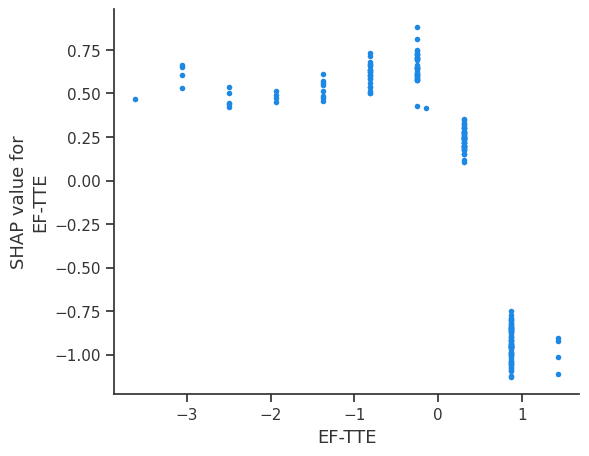

In [127]:
shap.dependence_plot("EF-TTE", shap_values, X_train, interaction_index=None)

This plot aligns with what we saw in the summary plot before. We can see the negative correlations between `EF-TTE` and target value `Cad`, since EF-TTE increases, its SHAP value decreases. By changing the `interaction_index` parameter to `auto`, we can color the points with a feature that most strongly interacts with `EF-TTE`.

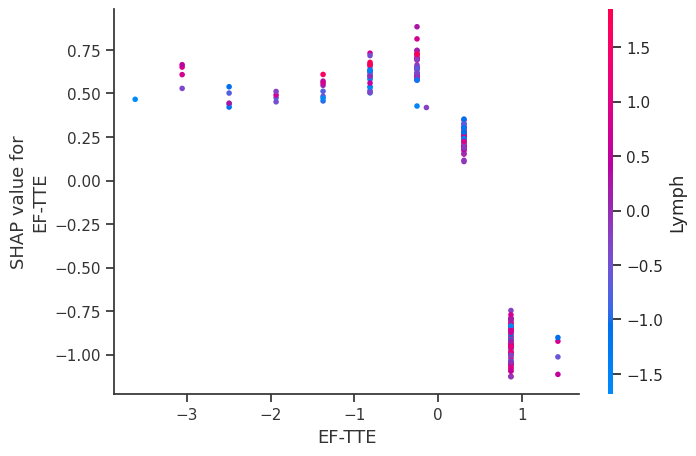

In [128]:
shap.dependence_plot("EF-TTE", shap_values, X_train, interaction_index='auto')

It seems that the `EF-TTE` interacts with the `Lymph` (lymphocyte to WBC ratio) much stronger than other features.

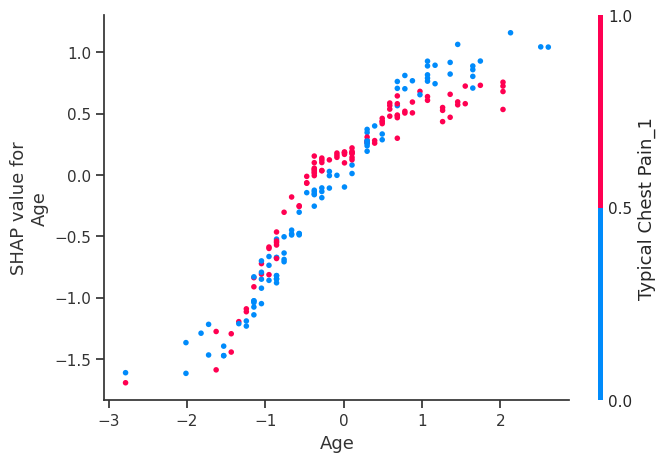

In [129]:
shap.dependence_plot("Age", shap_values, X_train, interaction_index='auto')

We can see the positive correlations between `Age` and `Cad`. As `Age` increases, its SHAP value increases. And it seems that `Age` interacts with `Typical Chest Pain_1` much stronger than other features.

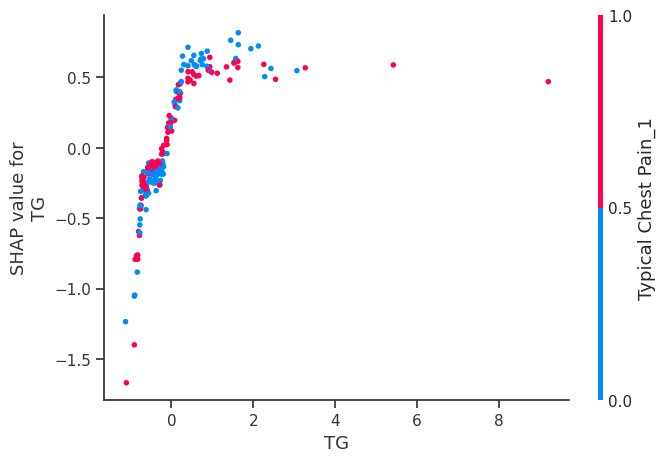

In [130]:
shap.dependence_plot("TG", shap_values, X_train, interaction_index='auto')

We can see the positive correlations between `TG` and `Cad`, and `Typical Chest Pain_1` has the strongest interaction with `TG`.

## Categorical Features

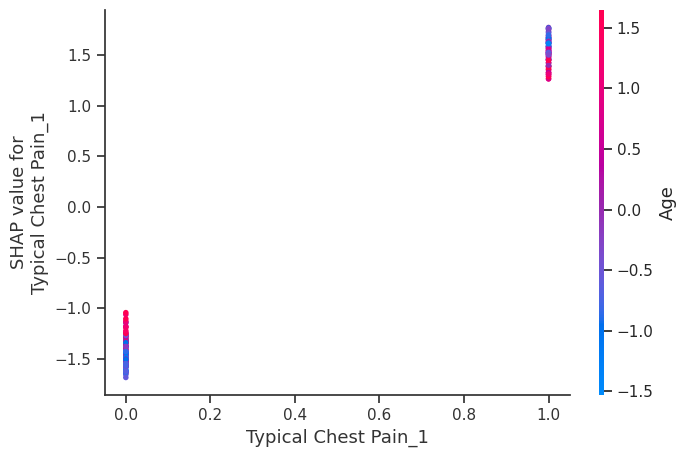

In [131]:
shap.dependence_plot("Typical Chest Pain_1", shap_values, X_train, interaction_index='auto')

`Typical Chest Pain_1` has the positive correlation with `Cad`, while interacting with `Age`.

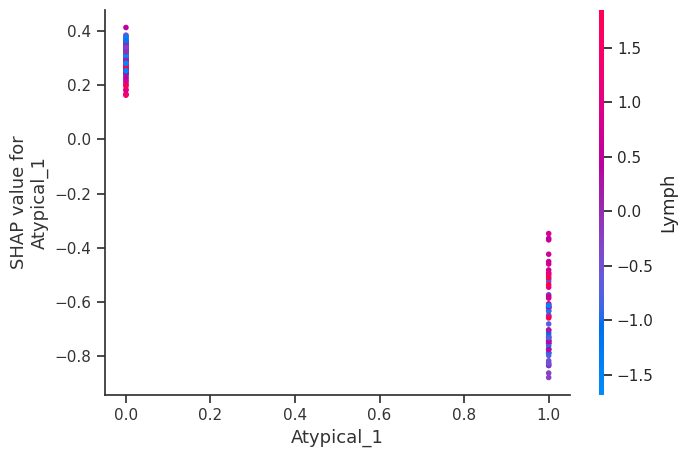

In [132]:
shap.dependence_plot("Atypical_1", shap_values, X_train, interaction_index='auto')

`Typical Chest Pain_1` has the negative correlation with `Cad`, while interacting with `Lymph`.

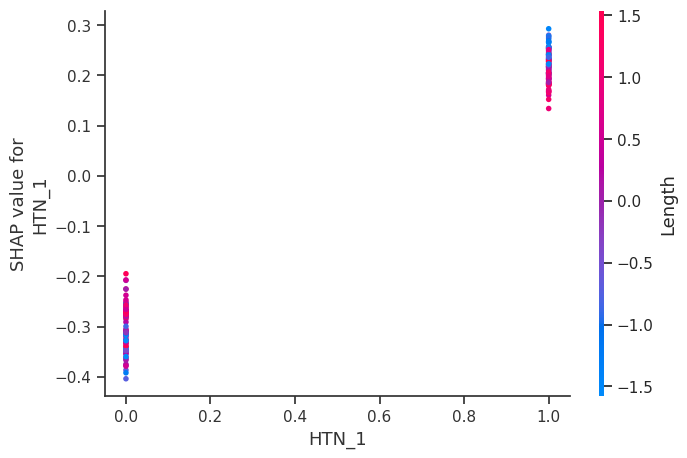

In [133]:
shap.dependence_plot("HTN_1", shap_values, X_train, interaction_index='auto')

`HTN_1` has the positive correlation with `Cad`, while interacting with `Length` (height).

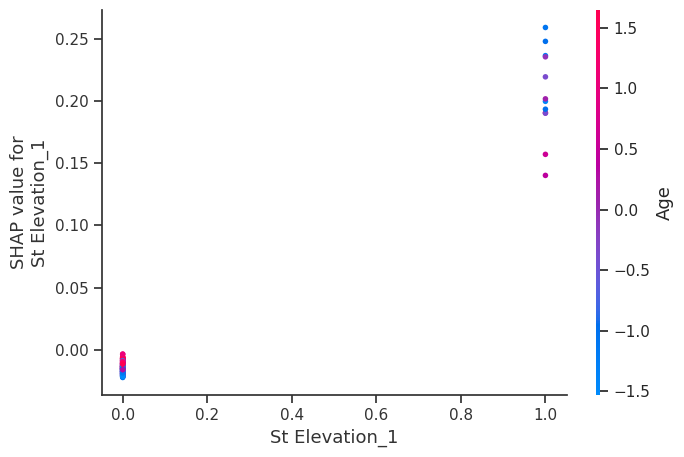

In [134]:
shap.dependence_plot("St Elevation_1", shap_values, X_train, interaction_index='auto')

`St Elveation_1` has the positive correlation with `Cad`, while interacting with `Age`.

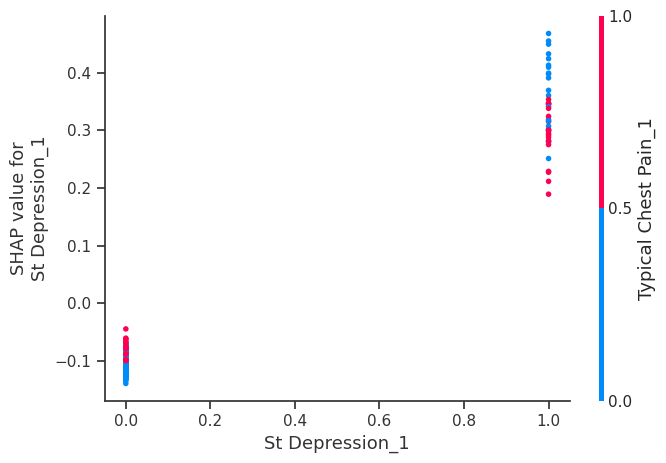

In [135]:
shap.dependence_plot("St Depression_1", shap_values, X_train, interaction_index='auto')

`St Depression_1` has the positive correlation with `Cad`, while interacting with `Typical Chest Pain_1`.

## Ordinal Features

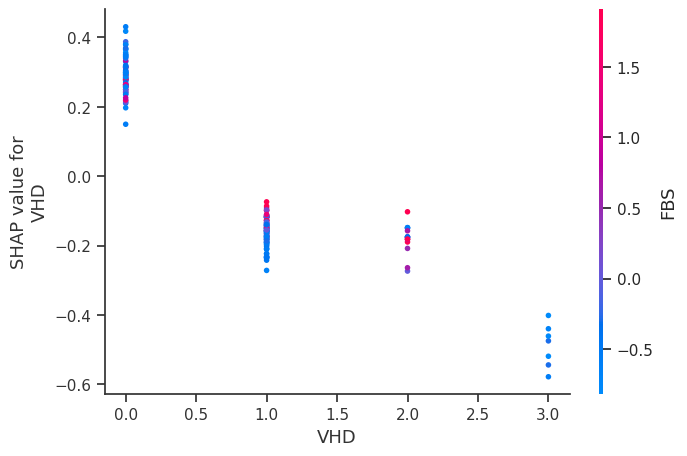

In [136]:
shap.dependence_plot("VHD", shap_values, X_train, interaction_index="auto")

`VHD` has the negative correlation with `Cad`, while interacting with `WBC`.

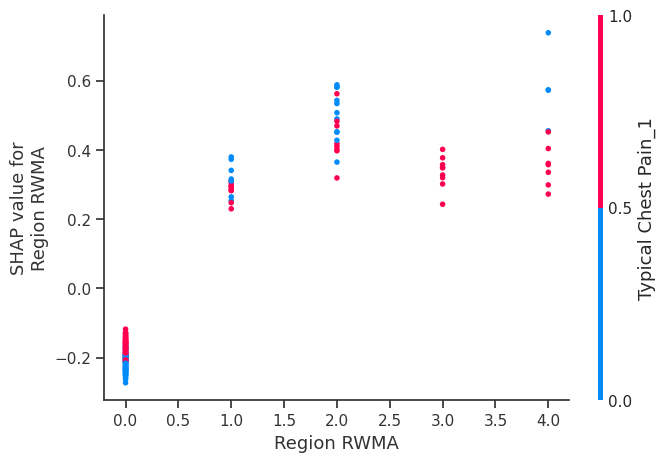

In [137]:
shap.dependence_plot("Region RWMA", shap_values, X_train, interaction_index="auto")

`Region RWMA` has the positive correlation with `Cad`, while interacting with `Typical Chest Pain_1`.

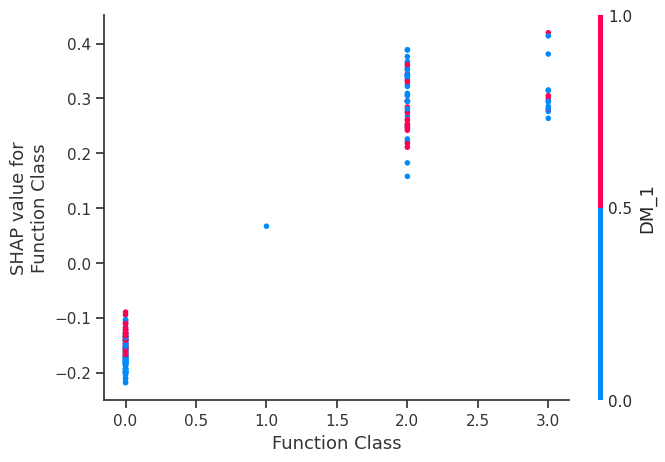

In [138]:
shap.dependence_plot("Function Class", shap_values, X_train, interaction_index="auto")

`Function Class` has the positive correlation with `Cad`, while interacting with `BMI`.

# ***Local Interpretability***

# 4.5 - Background Knowledge

 For patients who came into hospital because of chest pain, they can be diagnosed into five groups. which are:

 - Noncardiac chest pain
 - Stable angina
 - Unstable angina
 - Non ST segment elevation Myocardial Infarction (NSTEMI)
 - ST segment elevation Myocardial Infarction (STEMI)


If there is no clue about noncardiac chest pain (problems of lung, esophagus, chest wall, or maybe psychogenic), then we can suppose that the chest pain is originated from heart. Diagnosis between stable angina and unstable angina is based on symptoms of the patient. *Unstable angina* can be characterized by three symptoms, which are "at rest, new onset, crescendo pattern".

If cardiac enzymes are elevated, then patient can be diagnosed as "myocardial infarction". And If the ECG shows ST elevation, then patient is diagnosed as *STEMI*, otherwise *NSTEMI*. Unstable angina and NSTEMI are called as NSTE-ACS. **STEMI patients need immediate reperfusion by coronary angiography. And NSTE-ACS patients get coronary angiography if the patient meets the following criteria:**


___
### ***Class I Recommendations for use of an early invasive strategy***
#### *1. Reucrrent angina/ischemia at rest or minimal exertion despite anti-ischemic therapy*
#### *2. Elevated cardiac enzyme (TnT or TnI)*
#### *3. New ST-segment depression*
#### *4. CHF symptoms, rales or worsening mitral regurgitation*
#### *5. Positive stress test*
- Exercise stress test to provoke ischemic ST-T changes [low sensitivity (50-75%) for coronary heart disease]

#### *6. LVEF < 0.40*
#### *7. Hemodynamic instability or hypotension*
#### *8. Sustained ventricular tachycardia*
#### *9. Diabetes*
#### *10. Renal dysfunction*
#### *11. High TIMI Risk Score (>3)*
- Age>=65
- CAD risk factors >= 3 (Hypertension, Hypercholesterolemia, Diabetes, Family history of CAD, Current smoker)
- Known CAD
- Aspirin use in past 7 days
- Severe Angina (>=2 episodes in 24 hours)
- EKG ST changes >=0.5mm
- Positive cardiac marker
___

Now, let's assume a situation that you become a doctor. And you are responsible for caring the patient who came into your office because of chest pain. **Will you recommend the patient to get invasive coronary angiography or not?**  SHAP Waterfall plot and SHAP Force plot will help you explain the patient why you recommend or not. Or you can explain the patient with reference to above recommendations. We chose two patients from the dataset. Now let's begin:

# 4.6 - SHAP Waterfall Plot & Force Plot

In [139]:
cat_explainer = shap.TreeExplainer(cat_model, X_train, feature_names = X_train.columns.tolist())

In [140]:
shap_explainer_values = cat_explainer(X_train, y_train)

We first recalculate the SHAP values using the explainer object. This is different than `shap_values` function, because this time, the Shapley values are returned with a few more properties we need for local interpretability.

In [141]:
type(shap_explainer_values)

shap._explanation.Explanation

## ***Patient No.77***

In [142]:
pd.DataFrame(X_train.iloc[77])

236
Sex_Male                 1.000000
DM_1                     1.000000
HTN_1                    1.000000
Current Smoker_1         0.000000
EX-Smoker_1              0.000000
FH_1                     1.000000
Obesity_1                0.000000
CRF_1                    0.000000
CVA_1                    0.000000
Airway disease_1         0.000000
Thyroid Disease_1        0.000000
CHF_1                    0.000000
DLP_1                    1.000000
Edema_1                  0.000000
Weak Peripheral Pulse_1  0.000000
Lung rales_1             0.000000
Systolic Murmur_1        0.000000
Diastolic Murmur_1       0.000000
Typical Chest Pain_1     0.000000
Dyspnea_1                1.000000
Atypical_1               1.000000
Nonanginal_1             0.000000
LowTH Ang_1              0.000000
Q Wave_1                 0.000000
St Elevation_1           0.000000
St Depression_1          1.000000
Tinversion_1             1.000000
LVH_1                    0.000000
Poor R Progression_1     0.000000
Age                     -1.146753
Weight                  -0.654409
Length                   0.567406
BMI                     -1.077924
BP                      -0.505344
PR                      -0.577933
FBS                     -0.195886
CR                       1.305199
TG                      -0.392067
LDL                     -1.093534
HDL                     -0.970816
BUN                     -0.504178
ESR                     -0.343306
HB                      -0.655225
K                       -0.067097
Na                      -1.314369
WBC                      0.804213
Lymph                    0.763416
Neut                    -0.014609
PLT                     -0.403462
EF-TTE                  -0.250327
Function Class           2.000000
Region RWMA              1.000000
VHD                      1.000000

In [143]:
pd.DataFrame(data.iloc[236])

236
Age                          47
Weight                       66
Length                      170
Sex                        Male
BMI                    22.83737
DM                            1
HTN                           1
Current Smoker                0
EX-Smoker                     0
FH                            1
Obesity                       0
CRF                           0
CVA                           0
Airway disease                0
Thyroid Disease               0
CHF                           0
DLP                           1
BP                          120
PR                           70
Edema                         0
Weak Peripheral Pulse         0
Lung rales                    0
Systolic Murmur               0
Diastolic Murmur              0
Typical Chest Pain            0
Dyspnea                       1
Function Class                2
Atypical                      1
Nonanginal                    0
Exertional CP                 0
LowTH Ang                     0
Q Wave                        0
St Elevation                  0
St Depression                 1
Tinversion                    1
LVH                           0
Poor R Progression            0
FBS                         109
CR                          1.4
TG                          112
LDL                          66
HDL                        30.0
BUN                          14
ESR                          14
HB                         12.1
K                           4.2
Na                          136
WBC                        9500
Lymph                        40
Neut                         60
PLT                         197
EF-TTE                       45
Region RWMA                   1
VHD                           1
Cath                        Cad

This is the real data of *Patient No.77*.

In [144]:
cat_model.predict_proba(X_train.iloc[77])[1]*100

98.6544885285057

Catboost model predicted the probability of coronary artery disease as 98.7%.

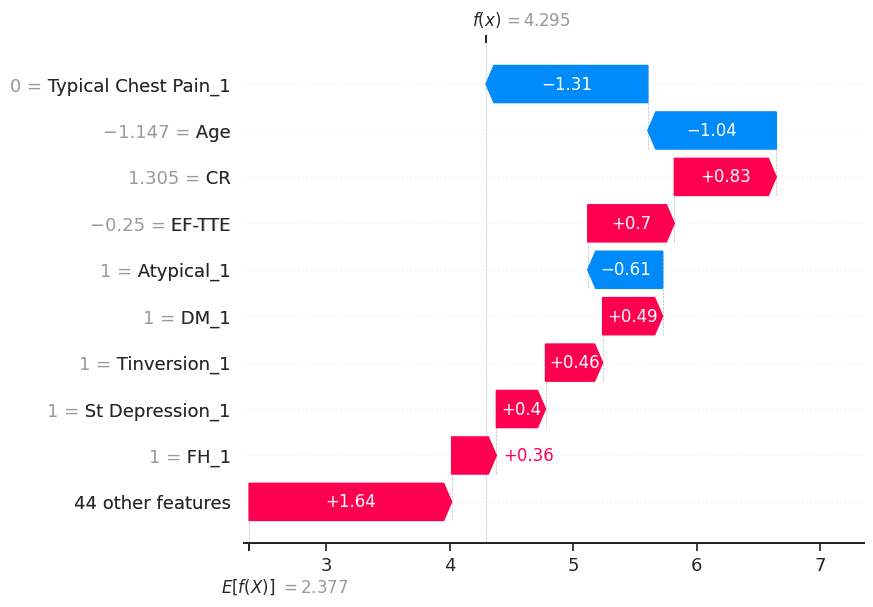

In [145]:
shap.waterfall_plot(shap_explainer_values[77])

The E[f(x)] = 2.379 is the mean prediction of CAD for the train set. The f(x) = 4.333 is the prediction of CAD for the patient No.77. The vertical axis shows the feature values of the No.77. The bars represent how each feature shifted the CAD from mean prediction. The red bars represents positive shifts, and the blue bars represent negative shifts.

In [146]:
shap.initjs()

shap.force_plot(shap_explainer_values[77])

Force plot is just an ordered, organized version of waterfall plots. All negative and positive bars are grouped to either side of the prediction of coronary artery disease. The bars show how much each feature shifts the value.

From clinician perspective, we could not know the patient can be diagnosed as myocardial infarction since the cardiac enzyme data is not provided. But, the ECG data is showing ST depression and T inversion, which are suggestive of ischemic change.

Even though the pattern of chest pain is not "typical", patient has **diabetes**, and creatinine is upper normal limit which is suggestive of renal dysfunction. Therefore, the patient should take invasive coronary angiography as an early invasive strategy. In reality, many diabetes patients with coronary artery disease manifests atypical chest pain, like *Patient No.77*.

SHAP Force Plot is consistent with above analysis. Even though `Typical Chest Pain_1` is 0 and `Atypical_1` is 1 (which pushes the model to predict as normal), the patient ECG is showing `St Depression_1 = 1` and `Tinversion_1 = 1`, and the patient has `DM_1`, `HTN_1`, and `FH`=1 (family history of coronary artery disease). And also high `Creatinine` level and low `EF-TTE` and `Region RWMA = 1` pushes the model to predict the person as `CAD` patient, which is consistent with the result.

***So you can explain the patient that: "Even though your chest pain type is atypical, the ECG data shows signs of ischemia (T inversion and ST Depression) and your creatinine level is upper normal limit, which is suggestive of renal dysfunction, and you have diabetes and there is regional wall motion abnormality in echocardiography. Our model predicted the probability of coronary artery disease as 98.7%. I think you should get coronary angiography as early invasive strategy. And also your information meets the clinical criteria."***



## ***Patient No.7***

In [147]:
pd.DataFrame(X_train.iloc[7])

204
Sex_Male                 0.000000
DM_1                     0.000000
HTN_1                    0.000000
Current Smoker_1         0.000000
EX-Smoker_1              0.000000
FH_1                     1.000000
Obesity_1                1.000000
CRF_1                    0.000000
CVA_1                    0.000000
Airway disease_1         0.000000
Thyroid Disease_1        0.000000
CHF_1                    0.000000
DLP_1                    1.000000
Edema_1                  0.000000
Weak Peripheral Pulse_1  0.000000
Lung rales_1             0.000000
Systolic Murmur_1        0.000000
Diastolic Murmur_1       0.000000
Typical Chest Pain_1     1.000000
Dyspnea_1                1.000000
Atypical_1               0.000000
Nonanginal_1             0.000000
LowTH Ang_1              0.000000
Q Wave_1                 0.000000
St Elevation_1           0.000000
St Depression_1          0.000000
Tinversion_1             0.000000
LVH_1                    0.000000
Poor R Progression_1     0.000000
Age                     -0.857599
Weight                   1.267453
Length                  -0.613833
BMI                      1.944227
BP                      -1.034254
PR                      -1.139915
FBS                     -0.561315
CR                      -0.589747
TG                      -0.565895
LDL                      1.000515
HDL                     -0.496507
BUN                      0.071754
ESR                     -0.343306
HB                      -0.157648
K                        0.151509
Na                       0.526963
WBC                      0.140244
Lymph                   -0.240991
Neut                     0.477242
PLT                      0.634501
EF-TTE                   0.871699
Function Class           2.000000
Region RWMA              0.000000
VHD                      0.000000

In [148]:
pd.DataFrame(data.iloc[204])

204
Age                           50
Weight                        89
Length                       159
Sex                       Female
BMI                    35.204304
DM                             0
HTN                            0
Current Smoker                 0
EX-Smoker                      0
FH                             1
Obesity                        1
CRF                            0
CVA                            0
Airway disease                 0
Thyroid Disease                0
CHF                            0
DLP                            1
BP                           110
PR                            65
Edema                          0
Weak Peripheral Pulse          0
Lung rales                     0
Systolic Murmur                0
Diastolic Murmur               0
Typical Chest Pain             1
Dyspnea                        1
Function Class                 2
Atypical                       0
Nonanginal                     0
Exertional CP                  0
LowTH Ang                      0
Q Wave                         0
St Elevation                   0
St Depression                  0
Tinversion                     0
LVH                            0
Poor R Progression             0
FBS                           90
CR                           0.9
TG                            95
LDL                          140
HDL                         35.0
BUN                           18
ESR                           14
HB                          12.9
K                            4.3
Na                           143
WBC                         7900
Lymph                         30
Neut                          65
PLT                          260
EF-TTE                        55
Region RWMA                    0
VHD                            0
Cath                      Normal

This is the real data of *Patient No.7*.

In [149]:
cat_model.predict_proba(X_train.iloc[7])[1]*100

9.677012921467963

Catboost model predicted the probability of coronary artery disease as 7.4%.

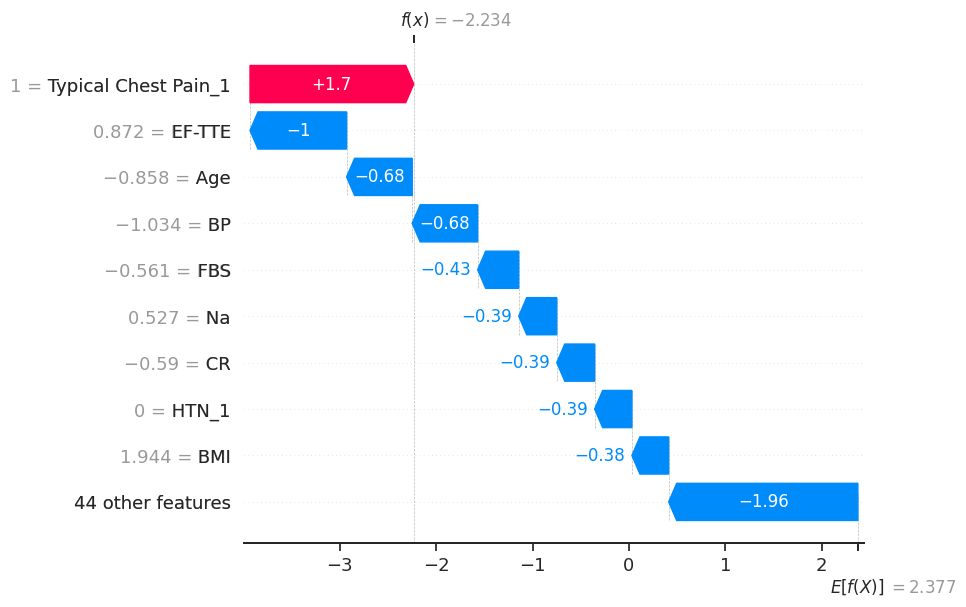

In [150]:
shap.waterfall_plot(shap_explainer_values[7])

In [151]:
shap.initjs()

shap.force_plot(shap_explainer_values[7])

From clinician perspective, even though the type of chest pain is "typical", the patient's data meets none of the criteria for early invasive strategy. Therefore invasive coronary angiography is not needed right now, and exercise stress test might be helpful.

SHAP Force Plot is consistent with above analysis. `Typical Chest Pain_1 = 1` and `FH_1 = 1` and `Function class = 2` pushes the model to predict the patient as `Cad` group. But `EF-TTE`, `BP`, `HTN_1` and other features are normal, and they pushes the model to predict the patient as normal group. The model's prediction is f(X) = -2.519, which means that the patient's prediction is normal. And it is consistent with the result.

***So you can explain the patient that: "Even though your chest pain type is typical and you have family history of coronary artery disease, you don't have any indications for invasive coronary angiography. And resting ECG is normal without signs of ischemia. Our model predicted the probability of coronary artery disease as 7.4%. I think you don't have to get invasive coronary angiography right now, but let's do exercise stress test to check if there's any signs of ischemia."***

 In conclusion, SHAP can provide a powerful and flexible way to interpret machine learning models and understand how they make their predictions. By computing feature importance scores based on Shapley values, SHAP can provide valuable insights into the contribution of each feature to a given prediction, and help you identify which features are most important for your model's performance. SHAP can be a valuable tool for improving your understanding of how your model works, and identifying areas for improvement.